# Miniproject 2: Melody generation

## Introduction

### Description

To develop a model employing ANN on real-world data requires going through several major steps, each of which with important design choices that directly impact the end results. In this project, we guide you through these choices starting from a large database of [Irish folk melodies](https://github.com/IraKorshunova/folk-rnn/tree/master/data) to your own model of symbolic music composition. 


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. Please ensure that your notebook is fully executed before handing it in. 

## Functions and imports

For your convenience we import some libraries and provide some functions below. Some libraries (`midi` and `music21==5.1.0`) should be added. If you work with the docker image, pull it `docker pull zifeo/artificial-neural-networks:cpu` before to get the latest version where these libraries are added and stop/relaunch the container (as stated in the instructions https://github.com/zifeo/artificial-neural-networks). If you work locally, be sure to import them. If you do not find the midi library for python3, install it with `python setup.py install` inside the `python3-midi` folder after cloning https://github.com/louisabraham/python3-midi.git.

Finally, fill in your sciper number(s) for the random seed and simply run the following cell.

In [84]:
#Rémy Pétremand and Arthur Père
sciper = {'student_1': 250970,
          'student_2': 245788}
seed = sciper['student_1']+sciper['student_2']

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os, sys

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = 8, 4

import keras
from keras.models import Model, load_model
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

import midi
import music21


#imports we added!
import copy
import pickle
from keras.models import load_model
from random import randint
from random import choice

In [4]:
def plotMelody(P, T, dictionaries, PrP=None, PrT=None, H=None):
    """
    P: The pitch array (integer representation) or matrix (one-hot encoding)
    T: The duration array (integer representation) or matrix (one-hot encoding)
    dictionaries: The dictionaries relating integer to a pitch or duration
    PrP: (Optional) If provided with PrT, plot the transitio
    n probabilities
    PrT: (Optional) If provided with PrP, plot the transition probabilities
    H: (Optional) Add a plot with the hidden state dynamic sorted by frequency
    """
    P = np.asarray(P)
    T = np.asarray(T)
    if len(P.shape) == 1:#if array
        P = np_utils.to_categorical(P, len(dictionaries['P']))
    if len(T.shape) == 1:#if array
        T = np_utils.to_categorical(T, len(dictionaries['T']))
    
    xlim = [-1,np.where(P==1)[0][-1]+1]
    
    activeidxes = np.where(np.sum(P, axis=0)>1.)[0]
    plt.figure(figsize=(8,4))
    if PrP is not None:
        targets = np.where(P[:,activeidxes]==1)
        plt.imshow(PrP[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
        plt.scatter(targets[0]-1,targets[1], color='red',s=10, marker='.') 
    else:
        plt.imshow(P[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
    plt.ylim([-0.5,len(activeidxes)-0.5])
    plt.yticks(range(len(activeidxes)),[dictionaries["P"][i] for i in activeidxes])
    plt.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$P[n]$")
    plt.xlim(xlim)
    plt.show()
    
    activeidxes = np.where(np.sum(T, axis=0)>1.)[0]
    plt.figure(figsize=(8,4))
    if PrT is not None:
        targets = np.where(T[:,activeidxes]==1)
        plt.imshow(PrT[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
        plt.scatter(targets[0]-1,targets[1], color='red',s=10, marker='.')
    else:
        plt.imshow(T[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
    plt.ylim([-0.5,len(activeidxes)-0.5])
    plt.yticks(range(len(activeidxes)),[dictionaries["T"][i] for i in activeidxes])
    plt.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$T[n]$")
    plt.xlim(xlim)
    plt.show()
    
    
    if H is not None:
        diff = np.mean([[abs(j-i) for i,j in zip(H[:xlim[1]-1,k], H[1:xlim[1],k])] for k in range(H.shape[1])], axis=1)
        sortidx = np.argsort(-diff)
        H = H[:,sortidx]
        plt.figure(figsize=(8,4))
        plt.imshow(H.T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.seismic, vmin=-1, vmax=1)
        plt.xlim([-1,np.where(T==1)[0][-1]+1])
        plt.tight_layout()
        plt.xlabel("$n$")
        plt.ylabel("$H[n]$")
        plt.show()


def plotLearningCurves(History):
    
    log = History.history
    
    plt.figure(figsize=(8,4))
    plt.plot(log['YP_loss'], '--', c=c[0], label='Pitch train loss')
    plt.plot(log['val_YP_loss'], c=c[0], label='Pitch val loss')
    
    plt.plot(log['YT_loss'], '--', c=c[1], label='Dur train loss')
    plt.plot(log['val_YT_loss'], c=c[1], label='Dur val loss')
    plt.legend(loc='best')
    
    plt.figure(figsize=(8,4))
    plt.plot(log['YP_acc'], '--', c=c[0], label='Pitch train acc')
    plt.plot(log['val_YP_acc'], c=c[0], label='Pitch val acc')
    
    plt.plot(log['YT_acc'], '--', c=c[1], label='Dur train acc')
    plt.plot(log['val_YT_acc'], c=c[1], label='Dur val acc')
    plt.legend(loc='best')

def sample(preds, temperature=1.):
    """Helper function to sample an index from a probability array"""
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def writeMIDI(xP, xT, dictionaries, label):

    # Instantiate a MIDI Pattern (contains a list of tracks)
    pattern = midi.Pattern(format = 0, resolution=480)
    # Instantiate a MIDI Track (contains a list of MIDI events)
    track = midi.Track()
    # Append the track to the pattern
    pattern.append(track)
    Events = []
    
    pseq = [dictionaries['P'][p] for p in xP]
    tseq = [dictionaries['T'][t] for t in xT]
    for t, p in zip(tseq, pseq):
        e = midi.NoteOnEvent(tick=0, velocity=90, pitch=p)
        track.append(e)
        e = midi.NoteOffEvent(tick=t, velocity=0, pitch=p)
        track.append(e)
        
    eot = midi.EndOfTrackEvent(tick=1)
    track.append(eot)
    # Save the pattern to disk
    midi.write_midifile(label, pattern)

## Exercise 1 : Data processing
### Description

For a real world application of ANNs, the original data should be translated into a representation understandable by an ANN. This step is often neglected but is of outmost importance. In order for you to better understand how ANN are applied to real world problems, the first step of this miniproject will guide you through a possible representation. 

Note that in general, your representation should be normalized in order to obtain homogeneous data from which a structure can be extracted by your ANN model. Importantly, all processing steps toward your representation should not (or minimally) distort your original data.

To represent MIDI files, we provide you with a Python MIDI library. You should then

0. Download the MIDI tar file from [this link](https://github.com/IraKorshunova/folk-rnn/tree/master/data) and put it in a folder named "chorpus" at the same level of this notebook.
1. Parse the chorpus to extract the label of (a random subset of) the data (code is provided)
2. Read each MIDI file in the subset with the midi [library](https://github.com/louisabraham/python3-midi)
3. For each data sequence extract the sequence of MIDI notes defined by two dimensions ("P": the sequence of note pitches (integer between 0 and 127 representing a piano key), "T": the sequence of note durations.
4. Select two melodies and display them both as sequences of MIDI events and sequence of notes in two dimensions. Control that your representation is correct.

For step 3, you should learn how MIDI files are constructed. Below, we give a minimal explanation and some code for this particular project. For a more complete explanation, look for MIDI in your favorite search engine. Given this dataset, you can observe that it is monophonic (one note at a time) and there's a small delay (1 tick) inbetween each note. You could decide to ignore this delay or correct (recommanded) for it.

A MIDI files is composed of timed events of many kinds. For this project, we focus on the events related to notes being played or stopped. Those are MIDI events "Note Off" and "Note On". Each event is timed with respect with the previous one (dt). The duration of a note is therefore given by the cummulated dt inbetween the event associated to a note's onset and the event associated with the same note's offset.
        

### Minimal code to read MIDI files

In [3]:
def display(midi_file="chorpus/sessiontune0.mid"):
    #index 0 for first track only
    events = midi.read_midifile(midi_file)[0] 
    tick = 0
    print(midi_file)
    print("#"*40)
    print("tick \t pitch \t message \t velocity")
    print("#"*40+'\n')
    for n, event in enumerate(events):
        tick += event.tick
        if event.name in ['Note On', 'Note Off']:
            if n<13 or n>len(events)-10:
                print("%i \t %i \t %s \t %i"%(tick, event.data[0], event.name, event.data[1]))
            if n in range(20,23):
                print(". \t . \t . \t \t .")
    print("#"*40+'\n')

display()

datapath = "chorpus/"
dataset = {}
np.random.seed(seed)

for filename in os.listdir(datapath):
    if filename.endswith("mid"):
        label = filename[:-4]
        #Down sample dataset
        if np.random.rand() < 0.1:
            dataset[label] = {"T":[], "P": []}
print("%i/%i melodies retained"%(len(list(dataset.keys())), len(os.listdir(datapath))))

chorpus/sessiontune0.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 67 	 Note On 	 105
240 	 67 	 Note Off 	 0
241 	 64 	 Note On 	 80
480 	 64 	 Note Off 	 0
481 	 64 	 Note On 	 80
720 	 64 	 Note Off 	 0
721 	 64 	 Note On 	 95
1200 	 64 	 Note Off 	 0
1201 	 62 	 Note On 	 80
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
33601 	 67 	 Note On 	 80
33840 	 67 	 Note Off 	 0
33841 	 69 	 Note On 	 95
34080 	 69 	 Note Off 	 0
34081 	 71 	 Note On 	 80
34320 	 71 	 Note Off 	 0
34321 	 72 	 Note On 	 80
34560 	 72 	 Note Off 	 0
########################################

4558/45853 melodies retained


### Solution

In [4]:
def parseMIDI(midi_file):
    events = midi.read_midifile(midi_file)[0] #index 0 for first track only  
    T = []
    P = []
    tick = 0
    for n, event in enumerate(events):
        if event.name in ['Note On']:
            tick = event.tick
        elif event.name in ['Note Off']:
            tick += event.tick
            T.append(tick)
            P.append(event.data[0])
        else:
            tick += event.tick
        #break
    return P, T

for label in list(dataset.keys()):
    Pseq, Tseq = parseMIDI(datapath+label+".mid")
    dataset[label]['T']= Tseq
    dataset[label]['P']= Pseq

for label in np.random.choice(list(dataset.keys()), 2):
    print(label)
    print("MIDI events")
    display(datapath+label+".mid")
    print("Note representation")
    print(dataset[label])
    print('/n')


sessiontune3970
MIDI events
chorpus/sessiontune3970.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 60 	 Note On 	 105
240 	 60 	 Note Off 	 0
241 	 62 	 Note On 	 80
480 	 62 	 Note Off 	 0
481 	 64 	 Note On 	 105
720 	 64 	 Note Off 	 0
721 	 60 	 Note On 	 80
960 	 60 	 Note Off 	 0
961 	 60 	 Note On 	 80
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
60241 	 64 	 Note On 	 80
60480 	 64 	 Note Off 	 0
60481 	 62 	 Note On 	 80
60720 	 62 	 Note Off 	 0
60721 	 59 	 Note On 	 80
60960 	 59 	 Note Off 	 0
60961 	 60 	 Note On 	 95
61440 	 60 	 Note Off 	 0
########################################

Note representation
{'P': [60, 62, 64, 60, 60, 65, 60, 60, 64, 60, 62, 64, 62, 59, 55, 53, 52, 48, 48, 52, 53, 55, 65, 64, 60, 62, 64, 62, 55, 60, 62, 64, 60, 60, 65, 62, 64, 65, 64, 60, 62, 64, 62, 59, 55, 53, 52, 48, 48, 53, 57, 55, 53, 52, 64, 62, 59, 60, 60, 62, 64, 60, 60, 65, 60, 60, 64, 60, 62, 64, 62, 59

## Exercise 2: Tokenzation and translation to integer
### Description

Now you should have a "dataset" dictionary where each entry corresponds to one melody example from a subset of the full dataset. In turn, every melody example is represented by a dictionary with two sequences: the "P" entry being the sequence of pitches and the "T" entry, the sequence of durations. Here, you will implement the first steps to translate this dataset in a language that can be read by your ANN models. To achieve that, we will later use the [one-hot encoding scheme](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/), which will associate each input (and output) unit of your network to a unique pitch or duration. In your network, these units will then be sequentially activated in the same order as their corresponding pitch/duration in your dataset. And at each note, the model will be trained to approximate the probability distributions of the upcoming pitch and duration.

1. Gather in a list of all possible pitches and durations in your dataset. These two lists will be your "dictionaries" translating a pitch/duration to a unique integer between 0 and the number of entries (-1) in the pitch/duration dictionary.
2. Translate the pitch/duration sequence of each melody to the integer representation.
3. Select randomly two melodies and display them in the note representation and translated to integer. Check that the translation is correct.

### Solution

In [6]:
def compute_dictrionary(dataset):
    T_dict = []
    P_dict = []

    for label in list(dataset.keys()):

        for duration in dataset[label]['T']:
            T_dict.append(duration)
        for pitch in dataset[label]['P']:
            P_dict.append(pitch)

    T_dict = np.sort(np.unique(T_dict))
    P_dict = np.sort(np.unique(P_dict))
    
    int_dataset = copy.deepcopy(dataset)
    for label in list(int_dataset.keys()):
        int_dataset[label]['T']  = (np.searchsorted(T_dict, int_dataset[label]['T']))
        int_dataset[label]['P'] = (np.searchsorted(P_dict, int_dataset[label]['P']))
    return T_dict, P_dict, int_dataset

In [7]:
T_dict, P_dict, int_dataset = compute_dictrionary(dataset)

In [16]:
for label in np.random.choice(list(int_dataset.keys()), 2):
    print(label)
    print("MIDI events")
    display(datapath+label+".mid")
    print("Note representation")
    print(dataset[label])
    print('\n')
    print("integer representation")
    print(int_dataset[label])
    print('/n')

sessiontune32174
MIDI events
chorpus/sessiontune32174.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 73 	 Note On 	 105
240 	 73 	 Note Off 	 0
241 	 72 	 Note On 	 80
480 	 72 	 Note Off 	 0
481 	 73 	 Note On 	 80
720 	 73 	 Note Off 	 0
721 	 77 	 Note On 	 95
960 	 77 	 Note Off 	 0
961 	 75 	 Note On 	 80
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
44641 	 77 	 Note On 	 105
44880 	 77 	 Note Off 	 0
44881 	 73 	 Note On 	 80
45120 	 73 	 Note Off 	 0
45121 	 73 	 Note On 	 80
45360 	 73 	 Note Off 	 0
45361 	 73 	 Note On 	 95
45840 	 73 	 Note Off 	 0
########################################

Note representation
{'T': [240, 240, 240, 240, 240, 240, 480, 240, 480, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 480, 240, 240, 240, 240, 240, 240, 240, 480, 240, 480, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 480, 480, 240, 240, 240, 240, 240, 480, 240, 480, 240, 240, 240, 240, 240, 240, 240,

In [8]:
dictionaries = {'T': T_dict, 'P': P_dict}
for label in np.random.choice(list(int_dataset.keys()), 1):
    T = int_dataset[label]['T']
    P = int_dataset[label]['P']
    T_note = int_dataset[label]['T']
    P_note = int_dataset[label]['P']
    #print("Note representation")
    #writeMIDI(P, T, dictionaries, label)
    #print('\n')
    #print("integer representation")data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABJEAAAJNCAYAAACBYuTcAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAAWJQAAFiUBSVIk8AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMS4xLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvAOZPmwAAIABJREFUeJzs3XuULWV9J/zvloNcTAS8TVYjL8GEOCpeIlHwKMigRI1JHBh44niJZiZeZl6jju/MrFwM0THzZjmvLiHJWolG1EkcIw9OookcMPGCRyPKDAY0ZtTJIF5oR0XQIUGicPb7x64Offrsc57u3nt37139+azVq3pXPVX12/XUrj58qXr2YDgcBgAAAAAO5R7bXQAAAAAA80+IBAAAAECTEAkAAACAJiESAAAAAE1CJAAAAACahEgAAAAANAmRAAAAAGgSIgEAAADQJEQCAAAAoEmIBAAAAECTEAkAAACAJiESAAAAAE1CJAAAAACahEgAAAAANAmRAAAAAGgSIgEAAADQtGu7C9gBhttdAAAAALDjDSbdgDuRAAAAAGgSIm2R5eXl7S4BAABYYzAY7PcDsBE77RoiRAIAAACgSYgEAAAAQJMQCQAAAIAmIRIAAAAATUIkAAAAAJqESAAAAAA0CZEAAAAAaBIiAQAAANAkRAIAAACgSYgEAAAAQJMQCQAAAIAmIRIAAAAATbu2u4BpKqU8P8lbG8321VoP69q/LcnzGu0/WGt90uTVAQAAACyuXoVISa5L8uqDLDsjydlJrlg1791JbjxI++cmedCa9gAAAAA70mA4HG53DVuilHJ1ktOTPKPW+ieNtscmWU5yWJLja603T7DrYZIsLy9naWlpgs0AAADTNhgM9nu9U/77CJiOBbuGDNpNDm1HjIlUSjklowDppiSXr2OV5yY5KskfTRggAQAAAPTCjgiRkryom15Sa71rHe1f0E3fNKN6AAAAABZK38ZEOkAp5agkz0myL8mb19H+cUkenuTztdYPbWA/146bX2td7yYAAAAA5tZOuBOpJDk2yRW11i+vo/0Lu+nvza4kAAAAgMXS+zuRcnco9MZWw1LKMRmFTt9N8raN7KTWeupBFs31qFoAAAAA69HrO5FKKQ9NsjvJV5LsWccqz0lydAyoDQAAALCfXodI2fyA2s27lgAAAAB2kt6GSKWUI5M8N6MBtS9ZR/vTkjwyowG1r5ptdQAAAACLpbchUpILkhyXZM8GB9R+0+xKAgAAAFhMfQ6R1h0KlVLuneRnMhpQ+z/PsigAAACARdTLEKmU8pAkT8j6B9R+dpJ7xYDaAAAAAGMNhkPfQD9jwyRZXl7O0tLSdtcCAACsMhgM9nvtv4+AjViwa8ig3eTQenknEgAAAADTJUQCAAAAoEmIBAAAAECTEAkAAACAJiESAAAAAE1CJAAAAACahEgAAAAANAmRAAAAAGgSIgEAAADQJEQCAAAAoEmIBAAAAECTEAkAAACApl3bXQAAANA/g8Fgv9fD4XCbKrnb2pqSdl3z+D5gJ5jHz55riDuRAAAAAFgHIRIAAAAATUIkAAAAAJqESAAAAAA0CZEAAAAAaBIiAQAAANAkRAIAAACgSYgEAAAAQJMQCQAAAIAmIRIAAAAATUIkAAAAAJqESAAAAAA0CZEAAAAAaNq13QVMUynl+Une2mi2r9Z6WNf+B5N84RBtL621PnM61QEAAAAsrl6FSEmuS/Lqgyw7I8nZSa4Ys+z6JO8eM/+vplQXAAAAwELrVYhUa70uoyDpAKWUq7tf3zRm8XW11lfNqi4AAACARbcjxkQqpZyS5PQkNyW5fJvLAQAAAFg4vboT6RBe1E0vqbXeNWb5UinlRUnum+SbSa6utX5qy6oDAAAAmHO9D5FKKUcleU6SfUnefJBm53Q/q9e7Ksnzaq1fWud+rh03v9a67loBAAAA5tVOeJytJDk2yRW11i+vWXZ7ktckOTXJcd3PE5N8KMlZST5QSrnX1pUKAAAAMJ96fydSkhd20zeuXVBr/XqSC9fM3ltK+fEkH01yWpKfT3Jxaye11lMPsmi4/lIBAAAA5lOv70QqpTw0ye4kX0myZ73r1VrvzN2Pvp05g9IAAAAAFkqvQ6S0B9Q+lG90U4+zAQAAADteb0OkUsqRSZ6b0YDal2xiE6d30xumVhQAAADAguptiJTkgowGyt4zZkDtJEkp5bRSyj3HzD87yb/pXr59diUCAAAALIY+D6y9MqD2mw7R5rVJHlZKuSqjcZOS5BFJzu5+/9Va68dmUx4AAADA4uhliFRKeUiSJ6Q9oPYfJDk3yWOSPC3J4Um+lqQm+e1a60dmXCoAAADAQhgMh76BfsaGSbK8vJylpaXtrgUAALbEYDDY7/U8/HfH2pqSdl3z+D5gJ5jHz14PriEHvoEN6vOYSAAAAABMiRAJAAAAgCYhEgAAAABNQiQAAAAAmoRIAAAAADQJkQAAAABoEiIBAAAA0CREAgAAAKBJiAQAAABAkxAJAAAAgCYhEgAAAABNQiQAAAAAmnZtdwE7yWAw2O/1cDjcpkrYjEn7T/8vtmn3/2a2wfaZxufXNWBx+fzezXk8nuMyspnjMOtjN4uaNrpN15C7+ayM57iMuIasb3vrrWNW3IkEAAAAQJMQCQAAAIAmIRIAAAAATUIkAAAAAJqESAAAAAA0CZEAAAAAaBIiAQAAANAkRAIAAACgSYgEAAAAQJMQCQAAAIAmIRIAAAAATUIkAAAAAJqESAAAAAA07druAqaplPL8JG9tNNtXaz2sa39Ckl9KcmqSE5Mcl+SbSf5XkrckeXut9XszKxgAAABgQfQqREpyXZJXH2TZGUnOTnLFqnk/lOTZST6R5N1Jbkly3yRPyyhE+tlSyjm11jtnVjEAAADAAuhViFRrvS6jIOkApZSru1/ftGr2x5IcV2vdt6bt4Un+LMlZSc5LUqdeLAAAAMAC2RFjIpVSTklyepKbkly+Mr/W+t21AVI3/3sZ3ZmUJCdvSZEAAAAAc2xHhEhJXtRNL6m13tVqXEo5LMlPdC8/NbOqAAAAABZErx5nG6eUclSS5yTZl+TNB2lzvyQvSTJIcv8k5yT54STvSPLede7n2nHza/UkHAAAALD4eh8iJSlJjk1yea31ywdpc78kv7bq9TDJ65L8cq11OOP6AAAAAObeTgiRXthN33iwBrXWzyYZdI+xHZ/k3CT/IckTSilPr7Xe0tpJrfXUgywSQgEAAAALr9chUinloUl2J/lKkj2t9t14SV9KcnEp5WtJ/jCjMOkls6wTAAAAYN71fWDtDQ2ovcYV3fSs6ZUDAAAAsJh6GyKVUo5M8tyMBtS+ZBObOL6b3jm1ogAAAAAWVG9DpCQXJDkuyZ6DDahdSjmtlHL0mPnfl+Ti7uXlsysRAAAAYDH0eUyklQG133SINr+U5KxSyoczGgvp9iQnJHlaRt/o9rEkvzHLIgEAAAAWQS9DpFLKQ5I8Ie0BtX8vyd8leUxGYx8dneTWJNcmqUneUmv1OBsAAACw4w2GQ99AP2PDJFleXs7xxx+//wLHfqEMBoP9Xm+0/yZdn+017f7fzDbYPtP4/LoGLC6f37s5j8dzXEY2cxxmfexmUdNGt+kacjeflfEclxHXkPVtb711HGxzm11xRZ/HRAIAAABgSoRIAAAAADQJkQAAAABoEiIBAAAA0CREAgAAAKBJiAQAAABAkxAJAAAAgCYhEgAAAABNQiQAAAAAmoRIAAAAADQJkQAAAABoEiIBAAAA0LRruwvYSYbD4XaXwAYMBoP9Xk/af/p/sej/nW3a/T+tbbA1ZtH/i2jtcUh27rFYyzkystHjsB3n1Ga231pno+/T+XG3nXos1nKOjLiGjDfv54c7kQAAAABoEiIBAAAA0CREAgAAAKBJiAQAAABAkxAJAAAAgCYhEgAAAABNQiQAAAAAmoRIAAAAADQJkQAAAABoEiIBAAAA0CREAgAAAKBJiAQAAABAkxAJAAAAgKZd213ANJVSnp/krY1m+2qth3XtT05yXpKnJDk5yT9KcmuSjye5qNb6odlVCwAAALA4ehUiJbkuyasPsuyMJGcnuWLVvNck+Zkkf51kT5Jbkjw4yU8n+elSystqrb85u3IBAAAAFkOvQqRa63UZBUkHKKVc3f36plWzr0zy2lrrX65p+8Qkf57k/yulXFZr/eos6gUAAABYFDtiTKRSyilJTk9yU5LLV+bXWt+2NkDq5n84yVVJ7plk9xaVCQAAADC3dkSIlORF3fSSWutd61zne930zhnUAwAAALBQevU42zillKOSPCfJviRvXuc6JyZ5UpLbk+xd5zrXjptfa11foQAAAABzrPchUpKS5Ngkl9dav9xsXMoRSf5LkiOS/Pta660zrg8AAABg7u2EEOmF3fSNrYallMOS/EGSxye5NMnr1ruTWuupB1k0XO82AAAAAOZVr8dEKqU8NKOBsb+SZE+j7WFJ3p7kgiQ1yXNqrQIgAAAAgPQ8RMo6B9QupexK8odJnpnkHUmeVWs1oDYAAABAp7ePs5VSjkzy3IwG1L7kEO3umdGdR89I8vtJfq7Wum9LigQAAABYEH2+E+mCJMcl2XOwAbW7QbT/OKMA6ZIIkAAAAADG6u2dSLl7QO03HaLN7yb5iSQ3J7kpyYWllLVtrqq1XjX16gAAAAAWSC9DpFLKQ5I8Ie0BtU/qpvdLcuEh2l01ncoAAAAAFtNgOPQFZDM2TJLl5eUsLS1tdy1swGAw2O+1z8rOov93Nv2/s+n/kbXHIdm5x2It58jIRo/DTjmnnB8jO6W/N8M5MuIaMt6Mz48DD+IG9XlMJAAAAACmRIgEAAAAQJMQCQAAAIAmIRIAAAAATUIkAAAAAJqESAAAAAA0CZEAAAAAaBIiAQAAANAkRAIAAACgSYgEAAAAQJMQCQAAAIAmIRIAAAAATbu2u4CdbDAY7Pd6OBxuUyWLb9JjuXb9zWxjo/T/9EzjWG5HfzgHpkP/M+2/AYvaF47DeIt6jZi2eTgO62m/iOdxH86PZDGP/VaYh8/OPJiH4+AaMh/ciQQAAABAkxAJAAAAgCYhEgAAAABNQiQAAAAAmoRIAAAAADQJkQAAAABoEiIBAAAA0CREAgAAAKBJiAQAAABAkxAJAAAAgCYhEgAAAABNQiQAAAAAmoRIAAAAADTt2u4CpqmU8vwkb20021drPWzNeruTvDLJ6UmOTPI3Sd6S5LdqrXfNoFQAAACAhdKrECnJdUlefZBlZyQ5O8kVq2eWUp6R5L8muSPJpUluSfJTSd6Q5PFJLphVsQAAAACLYjAcDre7hi1RSrk6ozuNnlFr/ZNu3r0zuuvomCSPr7X+927+kUk+mORxSf55rfWdE+x6mCTLy8tZWlrab8FgMNi/4Q7pi1mY9FiuXX8z29go/T890ziW29EfzoHp0P9M+2/AovaF4zDeol4jpm1RjsMinsd9OD+SxTz2W2FRPjuztijHYRHP4y3e54H/4btBO2JMpFLKKRkFSDcluXzVovOT3D/JO1cCpCSptd6R0eNtSfKvtqpOAAAAgHm1I0KkJC/qppesGePo7G565Zh19ia5PcnuUsoRsywOAAAAYN71bUykA5RSjkrynCT7krx5zeIHd9PPr12v1npnKeULSR6W5EFJ/kdjP9eOm19r3WjJAAAAAHNnJ9yJVJIcm+SKWuuX1yw7ppt++yDrrsw/dhaFAQAAACyK3t+JlOSF3fSNm1h3ZdCp5shWtdZTD7Jo8UZNAwAAAFij13cilVIemmR3kq8k2TOmycqdRseMWZYk917TDgAAAGBH6nWIlIMPqL3ic930R9YuKKXsSnJSkjuT3DCb8gAAAAAWQ29DpFLKkUmem9GA2pccpNkHu+lTxyw7M8nRST5Wa/376VcIAAAAsDh6GyIluSDJcUn2jBlQe8W7ktyc5JmllB9bmdkFUL/evfydmVYJAAAAsAD6PLD2yoDabzpYg1rr/ymlvCCjMOmqUso7k9yS5KeTPLibf+msCwUAAACYd728E6mU8pAkT8jBB9T+B7XWdyd5YpK9Sf5Zkl9I8r0kr0jyzFqrb1cDAAAAdrzBcCgjmbFhkiwvL2dpaWm/BYPBYP+G+mLTJj2Wa9ffzDY2Sv9PzzSO5Xb0h3NgOvQ/0/4bsKh94TiMt6jXiGlblOOwiOdxH86PZDGP/VZYlM/OrC3KcVjE83iL93ngf/huUC/vRAIAAABguoRIAAAAADQJkQAAAABoEiIBAAAA0CREAgAAAKBJiAQAAABAkxAJAAAAgCYhEgAAAABNQiQAAAAAmoRIAAAAADQJkQAAAABoEiIBAAAA0LRruwvYyYbD4X6vB4PBIZdzt9axmnT5NGpoadW02bp2gmn076T9N41zyDVgczba/+tpo/8XxzT6dx7+BkxDH/4WzsK0j8u4NpPWsBXm4Vq5GdtxHk9qUT87riHj9eXfmZNyDdk6i/bZcScSAAAAAE1CJAAAAACahEgAAAAANAmRAAAAAGgSIgEAAADQJEQCAAAAoEmIBAAAAECTEAkAAACAJiESAAAAAE1CJAAAAACahEgAAAAANAmRAAAAAGgSIgEAAADQtGu7C5iVUsoZSV6eZHeS+yS5Jcmnk1xUa92zqt0RSX4+yfOSPCjJkUm+nOTPk7y+1vrFLS4dAAAAYO708k6kUsork+xNcmaSK5O8PsmfJjkuyVmr2u1K8oEkv53k+5P8YZLfTfL1JL+Q5PpSykO3snYAAACAedS7O5FKKRckeU2S9yc5r9Z625rlh696eW6Sx2cUJP14rXXfqnavTnJhkn+b5F/Mum4AAACAedarO5FKKfdI8toktyd51toAKUlqrd9b9fJB3fTy1QFS5z3d9P5TLxQAAABgwUx0J1Ip5cxpFbLGd2utH9/EeruTnJTkXUluLaU8PckpSe5Ick2t9eo17T/TTZ9WSrl4TZD0k930/ZuoAwAAAKBXJn2c7aokwynUsdb/TnL8JtZ7TDf9WpJPJnn46oWllL1Jzq+1fqObdXmSP0pyXpJPl1Len+S7SU5N8oQkv5XReElNpZRrx82vtW7wLQAAAADMn2mMibQvyVemsJ0VJyYZbHLdB3TTFyf5QpInJ/lEt83XJ3lKksvSDa5dax2WUs7PaOyjX02yehDtDyR5R631rk3WAgAAANAb0wiRvlFrPWkK20mSlFLWjk20EYd100FGdxxd373+TCnl3CSfT/LEUsrjaq1Xl1KOTPL7SZ6W5P/OaByk2zMabPs3k+wtpVxQa31PGmqtpx5k0Szu1AIAAADYUn37drZbu+kNqwKkJEmt9TullPcl+ZdJHpvk6iS/mOSCJC+rtb5xVfMrujuUrktyce4eZBsAAABgR5r029n+JMmV0yhkStv8XDf91kGWr4RMR3XTlcGzP7S2YRdC3ZLkxFLKfTdZDwAAAEAvTHQnUq31n06rkCltc2+SO5OcXEq5Z631u2uWn9JNb+ymR3TT+6/dUCnliCT37l6u3Q4AAADAjjLpnUhzpdZ6c5JLkxyT0WDZ/6CUck5GA2t/O3ff6fSRbvrLXWi02qsyCtn+W631tlnVDAAAALAI+jYmUpK8IslpSX6llHJmkmsy+na2c5PcleQFtdaVx93+Y5KfSvKkJJ8tpVyZ5DsZDaz92O73l21t+QAAAADzp1d3IiVJrfXrGYVIb0hyQpKXJjk7yeVJzqi1Xraq7U1JHp3k9UnuSPJzSV6S5AeSvC3Jo2utV29l/QAAAADzaDAcTv8b6EspRyf5mSQ/ktFX3N+Y5K+SXF9r/bup73C+DZNkeXk5S0tLh2w4GAz2X3EGfdMXrWM16fJp1DDp9qaxzb6aRv9O2n+z+Ly6BqzPRvt/PW30/+KYRv/O49+Azejj38JpmPZxGddm0hq2wjxcK6dhK87j7TAPdbuGjNfXf2dulGvIfJug7gM7boOm/jhbKeWkJFcleeCYxcNSyheSXJfk+pVprfXL064DAAAAgOmZxeNsr8voMbK7krwno8fC9ia5tdvfDyX5Z0le3S2/sZRy8wzqAAAAAGBKZjGw9u6MHuH6mVrrH69eUEo5Icmjkjyymz4qyUlJjptBHQAAAABMySxCpKOTfGdtgJQk3WNrX07ypyvzSinfl1GoBAAAAMCcmkWI9NkkD11v41rr3yb5ixnUAQAAAMCUzGJMpLcnObqU8tgZbBsAAACAbTCLEOl3knwmyetKKbO40wkAAACALTaLEOmlSS5K8pAkHy6lnDiDfQAAAACwhWZxp9DrMvp2tiQ5PcnnSykfymgw7WuTfKrWevsM9gsAAADAjMwiRNqT5OFJTuheH57kx5Oc073eV0r5myTXJfnLbnpdrfXrM6gFAAAAgCmYeohUa/3JJCmlHJvkEUkeuWr6sCRHJXlw91O61YazqAUAAACA6ZhZcFNr/VaSvd1PkqSUco8kJ2f/YOmRSR44qzoAAAAAmNxgOBy2W81YKeXYLnTqo2GSLC8vZ2lpaUMrDgaDAze2pr/Wttlof066/lZZhPc5i320tjnt47KZbWyFRXifi9j/09rGrC3C+5zFObbR/t/MPvX/9CzC9XoejsMs9OHfCPPSvzvlmjCPFuFv/jx8VmZhHq7PG92Ha8jmLUKNm7GB93XgybJBs/h2tg3rcYAEAAAA0AtzESIBAAAAMN8mCpFKKftKKTdNq5hZbRMAAACAyUzjTqSJn6nbom0CAAAAsEnT+Ha2w0opJ0TwAwAAANBb0wiR7pfkxilsZ0U/hkcHAAAA6JFphEjuQAIAAADouYlCpFqrb3cDAAAA2AGmcSdSkqSUclySM5PcP8m3k1xfa/38tLYPAAAAwPaZSohUSnlpkv83yVFr5l+b5CW11mumsR8AAAAAtsfEj6OVUp6a5KIkR2c0PtLqnx9LclUp5exJ9wMAAADA9pnGmEYv76ZfSHJukgcmOSnJs5N8OsmRSd5eSjl6CvsCAAAAYBtM43G2H0syTPLsWuvHV83/Yinlj5N8JMmjMwqVfm8K+wMAAABgi00jRDouye1rAqQkSa31jlLKhUkuT/LUbGGIVEo5I6O7pHYnuU+SWzK6M+qiWuuers0PZnQH1cFcWmt95oxLBQAAAJh70wiRBkluO8Tyj3bTH5nCvtallPLKJK9JcnOS9yb5apL7JfnRJGcl2bNmleuTvHvMpv5qdlUCAAAALI6pfDvbodRabyulJMkxs95XkpRSLsgoQHp/kvNqrbetWX74mNWuq7W+agvKAwAAAFhI0xhYe71mHliVUu6R5LVJbk/yrLUBUpLUWr836zoAAAAA+mZawc4/KqWsjDn0qe7n00k+XWv9uyntYz12Z/TNcO9Kcmsp5elJTklyR5Jraq1XH2S9pVLKi5LcN8k3k1xda/3UVhQMAAAAsAimESINMxoX6dgkZyR5wuplpZQbu9+PKqU8KaNHx745hf2O85hu+rUkn0zy8NULSyl7k5xfa/3GmvXO6X5Wt70qyfNqrV9az45LKdeOm19rXc/qAAAAAHNtGiHS9yd5REaDVv9okkdldPfPkRmFSw/q2t07yZ8lSSnlpiR/ufpnvWFNwwO66Ysz+ta1Jyf5RJITk7w+yVOSXJbR4NrJ6LG312Q0qPYN3bxHJHlVkn+S5AOllEdt8d1UAAAAAHNnMBwOp77RUsphSR6SUaC0Ei49Mslxa5qu7HxYa5040Cql/Kck/y7JviSPrrVev2rZUUk+n+SBSXYf4tG2lFJ2ZfStcqcleXmt9eIJyhomyfLycpaWlja04mAwOHBja/prbZuN9uek62+VRXifs9hHa5vTPi6b2cZWWIT3uYj9P61tzNoivM9ZnGMb7f/N7FP/T88iXK/n4TjMQh/+jTAv/btTrgnzaBH+5s/DZ2UW5uH6vNF9uIZs3iLUuBkbeF8HniwbNJPBrmutdyX5q+7n7SvzSykn5u67lVbCpQdOcde3dtMbVgdIXU3fKaW8L8m/TPLYJAcNkWqtd5ZS3pxRiHRmkklCJAAAAICFN/NvTFut1vrFJF/M6PGxJEkp5T4ZhUnT8Llu+q2DLF8JmY5ax7ZWxk2610QVAQAAAPTAPba7gFrrLbXWD0xpc3uT3Jnk5FLKPccsP6Wb3riObZ3eTW84ZCsAAACAHWDbQ6RpqrXenOTSJMckuXD1slLKORkNrP3tJFd2804bFzaVUs5O8m+6l29fuxwAAABgp9nSx9m2yCsyGsvoV0opZya5JqNvZzs3yV1JXlBrXXnc7bVJHlZKuSrJV7p5j0hydvf7r9ZaP7ZVhQMAAADMq17diZQktdavZxQivSHJCUlemlEodHmSM2qtl61q/gdJPpHkMUlekORfJzk5SU1yZq3117ewdAAAAIC5NejLV9rNsWGSLC8vZ2lpaUMrruerGhfhqzqnYRHe5yJ+xftWfCXpNCzC+1zE/p/WNmZtEd7nLM6xRfk631lbhP5fzz7m4To2D8dhFvrwb4R56d+dck2YR4vwN38ePiuzMA/X543uwzVk8xahxs3YwPs68GTZoN7diQQAAADA9AmRAAAAAGgSIgEAAADQJEQCAAAAoEmIBAAAAECTEAkAAACAJiESAAAAAE1CJAAAAACahEgAAAAANAmRAAAAAGgSIgEAAADQJEQCAAAAoGnXdhfAwQ2HwwPmDQaDZptD2ej6a9tvZp8bNYt9zrrmcfuYtK9msc3NrD+N97FR097ndvT/LLY5jeMy6TVgEft/WtvY6PYnfR/6f3r7nIdrwEb7sy/HYRbvow9/I9bzHvp6jkxqEWrcjFlfQ9azj5Z5/axslGvI+rexUYvw+VyEGjdjK9+XO5EAAAAAaBIiAQAAANAkRAIAAACgSYgEAAAAQJMQCQAAAIAmIRIAAAAATUIkAAAAAJqESAAAAAA0CZEAAAAAaBIiAQAAANAkRAIAAACgSYgEAAAAQJMQCQAAAICmXdtdwKyUUs5I8vIku5PcJ8ktST6d5KJa656uzQlJfinJqUlOTHJckm8m+V9J3pLk7bXW72199QAAAADzpZd3IpVSXplkb5Izk1yZ5PVJ/jSjkOisVU1/KMmzk3w7ybtXtTsxoxDpz0opvQ3aAAAAANardwGKp1kyAAAe1UlEQVRJKeWCJK9J8v4k59Vab1uz/PBVLz+W5Lha674xbf4so8DpvCR1ljUDAAAAzLte3YlUSrlHktcmuT3Js9YGSEmy+vG0Wut31wZIq9q8u3t58ozKBQAAAFgYfbsTaXeSk5K8K8mtpZSnJzklyR1Jrqm1Xr2ejZRSDkvyE93LT82iUAAAAIBF0rcQ6THd9GtJPpnk4asXllL2Jjm/1vqNNfPvl+QlSQZJ7p/knCQ/nOQdSd67nh2XUq4dN79WT8IBAAAAi69vIdIDuumLk3whyZOTfCKjgbJfn+QpSS7L/oNrJ8n9kvzaqtfDJK9L8su11uEM6wUAAABYCIPhsD8ZSSnlPyX5d0n2JXl0rfX6VcuOSvL5JA9Msnvco23dY2zHJzk3yX9I8tdJnl5rvWWCsoZJsry8nKWlpQk2MzIYDPbf+Ab7b6Prr22/mX1u1HbscxYm7atZbHMz68/ifczjPhfBNI7LpNcA/b9+034f+r9fWu+zL8dhHv8WzoP1vIedco6wORs9P8a1WQSuIeO5hjCBAy8OG9SrgbWT3NpNb1gdICVJrfU7Sd7XvXzsuJVrrXfVWr9Ua704yYuSnJ5RmAQAAACwo/UtRPpcN/3WQZavhExHrWNbV3TTsyYpCAAAAKAP+hYi7U1yZ5KTSyn3HLP8lG564zq2dXw3vXMKdQEAAAAstF6FSLXWm5NcmuSYJBeuXlZKOSejgbW/neTKbt5ppZSj126nlPJ9SS7uXl4+y5oBAAAAFkHfvp0tSV6R5LQkv1JKOTPJNRl9O9u5Se5K8oJa68rjbr+U5KxSyoeTfCnJ7UlOSPK0JMcm+ViS39ja8gEAAADmT6/uREqSWuvXMwqR3pBRIPTSJGdndEfRGbXWy1Y1/71u/kOS/GxGAdSTk1yb0cDaT6y1/u3WVQ8AAAAwnwa+ym/mhkmyvLycpaWliTe21V/xvh1fD+orSWe3zc2s7yu+54eveF8s034f+r9fdspXL8/j38J54Ou5mdRGz49xbRaBa8h4riFM4MCLwwb17k4kAAAAAKZPiAQAAABAkxAJAAAAgCYhEgAAAABNQiQAAAAAmoRIAAAAADQJkQAAAABoEiIBAAAA0CREAgAAAKBJiAQAAABAkxAJAAAAgCYhEgAAAABNu7a7ADZmOBwecvlgMJjq+uPat9qsZxuTtF8Us3gfs+7/cdvYaP9upj/7eA7M4j1N2v+b2cak/T+NfS6qab+PzXyWNrqNaXy+/Q0Yab2vaVw7F4G/EeOt5z3slHOE8VxDRlxDxnMNoWWW/e1OJAAAAACahEgAAAAANAmRAAAAAGgSIgEAAADQJEQCAAAAoEmIBAAAAECTEAkAAACAJiESAAAAAE1CJAAAAACahEgAAAAANAmRAAAAAGgSIgEAAADQJEQCAAAAoGnXdhcwK6WUM5K8PMnuJPdJckuSTye5qNa6p2tzeJJ/neRRSX40yUOTHJ7kBbXWN29H3QAAAADzqJchUinllUlek+TmJO9N8tUk98soKDoryZ6u6b2SXNT9/rUk/zvJCVtZKwAAAMAi6F2IVEq5IKMA6f1Jzqu13rZm+eGrXt6e5CeSXFdr/Wop5VVJfm2ragUAAABYFL0KkUop90jy2ozCoWetDZCSpNb6vVW/fzfJFVtXIQAAAMBi6lWIlNH4RycleVeSW0spT09ySpI7klxTa716O4sDAAAAWFR9C5Ee002/luSTSR6+emEpZW+S82ut35j2jksp146bX2ud9q4AAAAAttw9truAKXtAN31xkqOSPDnJ92d0N9L7kpyZ5LLtKQ0AAABgcfXtTqTDuukgozuOru9ef6aUcm6Szyd5YinlcdN+tK3WeupBFg2nuR8AAACA7dC3O5Fu7aY3rAqQkiS11u9kdDdSkjx2S6sCAAAAWHB9C5E+102/dZDlKyHTUVtQCwAAAEBv9C1E2pvkziQnl1LuOWb5Kd30xi2rCAAAAKAHehUi1VpvTnJpkmOSXLh6WSnlnCRPSfLtJFdufXUAAAAAi2swHPZr3OdSygOS/EWSH07ykSTXJDkxybkZDXL9rFrrZava/2KSf9y9fFSSRyb5WJL/2c37aK31zROUNEyS5eXlLC0tTbCZ9RkMBocuptHfa9cf177VZj3bmKQ9Bzdp/4/bxkb7dzP92cdzYDveU6v/11PHtPt/Gvtk/Wb9N2AafyMmbb8oHIfx/I3YPMdhZ3ENGc81ZPMch53lEP3d/g+Ghr59O1tqrV8vpZyW5JUZBUenJ7ktyeVJfqPW+vE1qzw1yRPXzNvd/ayYJEQCAAAAWHi9uxNpDrkTyf852TLuRJof7kSa3j5ZP3cizQ/HYTx/IzbPcdhZXEPGcw3ZPMdhZ5nlnUi9GhMJAAAAgNkQIgEAAADQJEQCAAAAoEmIBAAAAECTEAkAAACAJiESAAAAAE1CJAAAAACahEgAAAAANAmRAAAAAGgSIgEAAADQJEQCAAAAoEmIBAAAAEDTru0ugOkaDoczX7/VZqM1TFozd5vGsZy0fzdTQx/Pge14T/qfWf8NmMbfiEnbLwrHYbzW+xwMBhteZ6dwHHYW15DxXEM2z3HYWWbZ3+5EAgAAAKBJiAQAAABAkxAJAAAAgCYhEgAAAABNQiQAAAAAmoRIAAAAADQJkQAAAABoEiIBAAAA0CREAgAAAKBJiAQAAABAkxAJAAAAgCYhEgAAAABNQiQAAAAAmnZtdwGzUko5I8nLk+xOcp8ktyT5dJKLaq171rTdneSVSU5PcmSSv0nyliS/VWu9ayvrBgAAAJhHvQyRSimvTPKaJDcneW+Srya5X5IfTXJWkj2r2j4jyX9NckeSSzMKm34qyRuSPD7JBVtYOgAAAMBcGgyHw+2uYapKKRckqUnen+S8Wutta5YfXmv9Xvf7vTO66+iYJI+vtf73bv6RST6Y5HFJ/nmt9Z0TlDRMkuXl5SwtLU2wGQCAfhsMBgfM69u/VYHZcQ2BpgM/JBvUqzGRSin3SPLaJLcnedbaAClJVgKkzvlJ7p/knSsBUtfmjoweb0uSfzW7igEAAAAWQ98eZ9ud5KQk70pyaynl6UlOyehRtWtqrVevaX92N71yzLb2ZhRG7S6lHFFr/fsZ1QwAAAAw9/oWIj2mm34tySeTPHz1wlLK3iTn11q/0c16cDf9/NoN1VrvLKV8IcnDkjwoyf841I5LKdeOm19rXXfxAAAAAPOqV4+zJXlAN31xkqOSPDnJ92d0N9L7kpyZ5LJV7Y/ppt8+yPZW5h873TIBAAAAFkvf7kQ6rJsOMrrj6Pru9WdKKedmdMfRE0spjxvzaNs4K4NONUdjq7WeepBFRnIDAAAAFl7f7kS6tZvesCpASpLUWr+T0d1ISfLYbrpyp9ExGe/ea9oBAAAA7Eh9C5E+102/dZDlKyHTUWva/8jahqWUXRkN0n1nkhumVSAAAADAIupbiLQ3o9Dn5FLKPccsP6Wb3thNP9hNnzqm7ZlJjk7yMd/MBgAAAOx0vQqRaq03J7k0o8fTLly9rJRyTpKnZPRo2pXd7HcluTnJM0spP7aq7ZFJfr17+TszLhsAAABg7g2Gw36N+1xKeUCSv0jyw0k+kuSaJCcmOTejQa6fVWu9bFX7f5pRmHRHkncmuSXJTyd5cDe/1FonOUjDJFleXs7S0tIEmwEA6LfBYHDAvL79WxWYHdcQaDrwQ7LRDfTxQ1VKuU+SV2YUHB2f5LYkH03yG7XWj49p//gkv5LkcUmOTPI3Sd6S5DdrrXdNWI4QCQBgHfwHIDAJ1xBoEiItACESAMA6+A9AYBKuIdA0cYjUqzGRAAAAAJgNIRIAAAAATUIkAAAAAJqESAAAAAA0CZEAAAAAaBIiAQAAANAkRAIAAACgSYgEAAAAQJMQCQAAAIAmIRIAAAAATUIkAAAAAJqESAAAAAA07druAlh8g8Fgv9fD4XCq7Zlvk/b/etZhfm3m8+wa0B+b+Tzrf1ZzPgCTcA2BredOJAAAAACahEgAAAAANAmRAAAAAGgSIgEAAADQJEQCAAAAoEmIBAAAAECTEAkAAACAJiESAAAAAE1CJAAAAACahEgAAAAANAmRAAAAAGgSIgEAAADQJEQCAAAAoGnXdhcwbaWUG5OceJDFX6u1/sCa9kck+fkkz0vyoCRHJvlykj9P8vpa6xdnVy0AAADAYuhdiNT5dpKLxsz/29UvSim7knwgyeOTfDbJHyb5+ySPSfILSX62lLK71vrXsy0XAAAAYL71NUT6Vq31Vetod25GAdIHkvx4rXXfyoJSyquTXJjk3yb5F7MoEgAAAGBR7PQxkR7UTS9fHSB13tNN77+F9QAAAADMpb7eiXREKeU5Sf6vJH+X5FNJ9tZa71rT7jPd9GmllIvXBEk/2U3fP9tSAQAAAOZfX0OkH0jyB2vmfaGU8nO11g+vmnd5kj9Kcl6ST5dS3p/ku0lOTfKEJL+V5LfXs8NSyrXj5tdaN1g6AAAAwPzp4+Nsb03ypIyCpHsleXiSNyb5wSRXlFIeudKw1jpMcn6SVyV5cJKXZjQG0j9JsjfJO8bcvQQAAACw4wyGw+F217AlSimvS/L/JHl3rfXcbt6RSX4/ydMyCo/ek+T2jAbb/s0kJya5oNb6nrEbXZ9hkiwvL2dpaWmCzcyvwWCw3+vWObXR9sy3Sft/PeswvzbzeXYN6I/NfJ71P6s5H4BJuIbAhh34j7cN6uvjbOP8bkYh0pmr5v1ikguSvKzW+sZV868opZyf5LokF+fuQbYBAAAAdqQ+Ps52MF/vpvdaNW9l8OwPrW1ca70+yS1JTiyl3HfGtQEAAADMtZ0UIj2um96wat4R3fT+axuXUo5Icu/u5XdnWBcAAADA3OtViFRKeVgp5T5j5p+Yu79l7e2rFn2km/5yFxqt9qqMHvf7b7XW26ZdKwAAAMAi6duYSBck+cVSyoeSfCHJbUl+KMnTkxyZZE+S161q/x+T/FRG3+b22VLKlUm+k9HA2o/tfn/ZllUPAAAAMKd6dSdSRmMb/XGSk5I8K8krkjwxyUeTPC/JT9Za/+HRtFrrTUkeneT1Se5I8nNJXpLkB5K8Lcmja61Xb2H9AAAAAHNp4GsQZ26YJMvLy1laWtruWmZi0q94dw4utkn7fz3rML8283l2DeiPzXye9T+rOR+ASbiGwIYd+I+3DerbnUgAAAAAzIAQCQAAAIAmIRIAAAAATUIkAAAAAJqESAAAAAA0CZEAAAAAaBIiAQAAANAkRAIAAACgSYgEAAAAQJMQCQAAAIAmIRIAAAAATUIkAAAAAJp2bXcBLL7hcHjI5YPBYEPtWSz6f2dbT386B/pL/zMp5wMwCdcQ2HruRAIAAACgSYgEAAAAQJMQCQAAAIAmIRIAAPD/t3fvMbZV9R3Av1NRUESKWKVXHleIVOXlsyqkIBhfQVtp4OcjKLVtWlqVVqWpqVLF1j5SrA+wamtECm10VaJGK2oiV1CxUVGh1voAwYaioggWREVg+sfeYw7Hmdl3hnvmnJn5fJKbdffea59Z58787jrzPWvvAwCDhEgAAAAADBIiAQAAADBIiAQAAADAICESAAAAAIOESAAAAAAMEiIBAAAAMEiIBAAAAMAgIRIAAAAAg4RIAAAAAAzaadoD2NGq6uok+y1x+Duttb0WOWcuyfOTvCDJoUnumeTbST6b5JWtta9NZrQAAAAA68OGC5F6P0jyhkX23zy+o6p2SfJvSZ6e5KtJ/jXJTUm2JPm1JAcmESIBAAAAm9pGDZFubK29ejv7vi5dgPTX6VYd3TF6sKruvoPHBgAAALDubNQQabtU1QFJTk532dorWmvz431aaz9d84EBAAAAzJiNGiLtXFUnJtk3yQ+TXJ7k4tba7WP9npPu5uLnJLlPVT0jyT5Jrk9yYWvtijUcMwAAAMDM2qgh0l5Jzh3bd1VVvaC1dtHIvsf07e5Jrkyy58ix+ap6S5JTFgmffk5VXbrY/tba9o8aAAAAYEb9wrQHMAFnJ3liuiBp1ySHJHlbkq1JLqiqw0b63r9vX5Pkc33f3frzr0zyh0lOW5NRAwAAAMywufn5n7sN0IZUVWckeVmS97XWjuv3fSbdaqRrkhzYWvvRSP/Dknw+3eVw92ut3brKLz2fJNdee222bNlyF57B+jU3N3en7c3yM0fH9x8/A5ub7z8AwMyYG+6yvI24Emkpb+3bI0f23dC3Hx4NkJKktXZZkqvSrUx66OSHBwAAADC7NlOIdF3f7jqy76t9e+MS5yyETPecyIgAAAAA1onNFCI9vm+/MbLvY3178Hjnqto5yYP7zasnNywAAACA2behQqSqOqiq7rvI/v2SnNVvnjdy6IJ0odJTqupJY6edlu5T2y5qrX17EuMFAAAAWC92mvYAdrATkry8qralu5/RTUkOSHJskl2SfCjJGQudW2u3VtVJST6a7pPb3pvkm+lutn1kku8m+b01fQYAAAAAM2hDrURKsi3Je5M8KMlzk7w0yVFJPpnkpCRPH/+UtdbaJ5M8Osn5fd9Tkuyf5B+TPLK19rU1Gz0AAADAjJrzUbsTN58k1157bbZs2TLtsUyFj3fe3Hz/8TOwufn+AwDMjLnhLsvbaCuRAAAAAJgAIRIAAAAAg4RIAAAAAAwSIgEAAAAwSIgEAAAAwCAhEgAAAACDhEgAAAAADBIiAQAAADBIiAQAAADAICESAAAAAIOESAAAAAAMmpufn5/2GDY6/8AAAADAtM3d1QewEgkAAACAQTtNewCbwJ2Svqq6NElaa4+aznBgfVI7sHLqBlZH7cDqqB1YufVWN1YiAQAAADBIiAQAAADAICESAAAAAIOESAAAAAAMEiIBAAAAMGhufn5+2mMAAAAAYMZZiQQAAADAICESAAAAAIOESAAAAAAMEiIBAAAAMEiIBAAAAMAgIRIAAAAAg4RIAAAAAAzaadoD2Cyqau8kr0ny1CR7JvlWkvclOb21dsM0xwbTVFVXJ9lvicPfaa3ttcg5hyd5ZZLHJdklyRVJ3pHkzNba7RMaKqy5qjo+yVFJHp7ksCS7JfmX1tqJy5yz4vqoqqcnOTXJI5LcLcl/JfmH1to5O+7ZwNpZSe1U1dYkVy3zcO9urT17ia9zUpIXJnlYktuTfCHJGa21D96lJwBTUFV7JjkuybFJDknywCS3JvnPJGcnObu1dsci55l32NRWWjvrfd4RIq2BqjogySVJ7p/k/Um+kuRXk/xRkqdW1RGtteunOESYth8kecMi+28e31FVv5Hk/CQ/TvLuJN9P8owkr09yRJITJjdMWHOvTPcL8M1JrknykOU6r6Y+qupFSc5Mcn2S89K96Dk+yTur6pDW2qk76snAGlpR7fQuS/cG37gvLda5qs5I8rL+8f8pyT2SPDvJB6rqxa21s1YxbpimE5K8Jd2b3duS/E+SByT5zSRvT/K0qjqhtTa/cIJ5B5KsonZ663LemZufH38e7GhV9ZEkT05ySmvtzJH9f5/kJUne1lo7eVrjg2nqVyKltbZ1O/reJ927W7snOaK19rl+/y5JLkzy+CTPaa29a1LjhbVUVUene6FwRbpVFduy9GqKFddH/07YV5L8MMmjWmtX9/v3SPLZJAckOby19ukJPUWYiBXWztZ07wif01r7re18/MOTfCrJlUkes7CqvH+sS5PsmuQhCzUF60FVHZPuZ/ffx1ZN7JXkM0n2SXJ8a+38fr95B7Kq2tmadTzvuCfShFXV/ukCpKuTvHns8KvS/Qf6vKradY2HBuvR8Ul+Kcm7Fl6oJElr7cfp3nVOkj+YxsBgElpr21prX1/knavFrKY+fjvJzknOGn3R0b8w+at+05scrDsrrJ3VWKiL147elqCvozenq6sXTOhrw0S01i5srX1g/JK11tq3k7y133zCyCHzDmRVtbMaMzPvuJxt8o7p248u8kN1U1V9Kl3I9LgkH1vrwcGM2LmqTkyyb7pg9fIkFy9yHf1CPX14kce4OMktSQ6vqp1baz+Z2GhhNq2mPpY754KxPrDRbamq309378rrk3y6tXb5En2Haue0vs+rdvgoYTp+2re3jewz78CwxWpnwbqcd6xEmrxf6duvLXH863174BqMBWbVXknOTfLadPdGujDJ16vqqLF+S9ZTa+22dMtCd0qy/+SGCjNrNfWx3DnfShfq7l1V99qxQ4WZ9KR07xi/tm8vq6ptVbXvaKd+9fgDk9zc18k4r+3YUKpqpyTP7zdHf4E178AylqmdBety3hEiTd7uffuDJY4v7P/FNRgLzKKzkzwxXZC0a7pPNHhbkq1JLqiqw0b6qidY2mrqY3vP2X2J47AR3JLkL5I8Kske/Z+F+yg9IcnHxm47YC5is/mbJAcn+VBr7SMj+807sLylamddzzsuZ5u+ub51h3M2pdba6WO7vpTk5Kq6Od2nD7w63Udmbg/1BEtbTX2oKTa81tp1Sf58bPfFVfXkJJ9M8tgkv5vkjSt8aHXDuldVp6R7PfaVJM9b4enmHTat5Wpnvc87ViJN3lCafp+xfkBn4SZ0R47sU0+wtNXUx/ae8393YVywLvWX47y931zJXDT0jjGsC1X1wnS/xH45ydGtte+PdTHvwCK2o3YWtV7mHSHS5H21b5e6PvHBfbvUPZNgs7qub0eXci5ZT/01xw9Kd9O6b0x2aDCTVlMfy53zy+nq75rW2i07dqiwbny3b382F7XWfpjkf5Pcu6+TcV7bse5V1R8nOSvdCvGj+0+ZGmfegTHbWTvLmfl5R4g0edv69slVdad/76raLckRSX6U5D/WemAw4x7ft6MvPC7s26cu0v/IJPdKcolPZmOTWk19LHfO08b6wGb0uL4df3NC7bBhVdWfJnl9ki+m+yX4uiW6mndgxApqZzkzP+8IkSastXZlko+mu0nwC8cOn54uYfznPl2ETaWqDqqq+y6yf790CX6SnDdy6D1Jvpfk2VX16JH+uyT5y37zLRMaLsy61dTH2Ul+kuRFVbV15Jw9kvxZv/nWwAZWVY+tqnsssv+YJC/pN88bO7xQF6/o62XhnK3pXu/9JF19wbpSVaeluxnwpUme2Fr73jLdzTvQW0ntrPd5Z25+3j3LJq2qDkhySZL7J3l/kv9Od7Oso9MtOTu8tXb99EYI01FVr07y8nQr9q5KclOSA5Icm2SXJB9Kclxr7daRc56Z7kXLj5O8K8n3k/x6uo+MfU+Saq35j40Nof95f2a/uVeSp6R7Z+oT/b7vtdZOHeu/ovqoqhcneVOS65O8O8mtSY5PsneS140+PqwXK6mdqvp4koOSfDzJNf3xQ5Mc0//9tNbawi/Eo1/jdUle2p/zniT3SPKsJHsmeXFr7azxc2CWVdVJSd6Z5PYkZ2bx+6tc3Vp758g55h02vZXWznqfd4RIa6Sq9knymnTLz/ZM8q0k70ty+vbeaAs2mqo6KsnJSR6R7kX+rkluTLcE9Nwk5y4WCFXVEUleke6St12SXJHkHUne1Fq7fW1GD5PXB62vWqbLN1trW8fOWXF9VNUzkpya5JHpVil/OclZrbVz7uJTgKlYSe1U1e+k+xTQg5PcL8ndk3wnyafT1cEnlnqQ/heHFyV5WJI7knw+yd+11j54158FrK3tqJskuai19oSx88w7bGorrZ31Pu8IkQAAAAAY5J5IAAAAAAwSIgEAAAAwSIgEAAAAwCAhEgAAAACDhEgAAAAADBIiAQAAADBIiAQAAADAICESAAAAAIOESAAAAAAMEiIBAAAAMEiIBAAAAMAgIRIAAAAAg4RIAAAAAAwSIgEAAAAwSIgEAAAAwCAhEgAAAACDdpr2AAAAuLOq+mCSY5P8SZI3Jjk5yYlJHprkliSXJDm1tfaNqQ0SANh0rEQCAJg9h/btDUkuTfKmJAenewPwAUmOS3JRVd17OsMDADYjIRIAwAypqj2S7NNv/m2Sm5IcnuTeSXZNcnyS25LsneRZ0xgjALA5uZwNAGC2HDry9yuSHN1au3Vk3/n95W7PTHLgmo4MANjUrEQCAJgth/XtbUmeOxYgLbihb+fXZkgAAEIkAIBZs7ASadsyN87ev2+vnvxwAAA6QiQAgNmysBLpA8v0OaRvvzThsQAA/IwQCQBgRlTV3ZIc1G9eukSffZPcN92lbJet0dAAAIRIAAAz5MFJ7pnkjiSXL9Hn4X17VWvtpjUZFQBAhEgAALNk4VK2K1prNw/0+eIajAcA4GeESAAAs2PhptrLBUQLK5FcygYArCkhEgDA7FhYZfSFZfoshEhWIgEAa0qIBAAwO5ZdiVRVuyV5UL9pJRIAsKaESAAAM6Cq9kiyT7+51Cqjw5LMJbmxtfbNNRkYAEBvbn5+ftpjAAAAAGDGWYkEAAAAwCAhEgAAAACDhEgAAAAADBIiAQAAADBIiAQAAADAICESAAAAAIOESAAAAAAMEiIBAAAAMEiIBAAAAMAgIRIAAAAAg4RIAAAAAAwSIgEAAAAwSIgEAAAAwCAhEgAAAACDhEgAAAAADBIiAQAAADBIiAQAAADAICESAAAAAIP+H7kS/kgBF5TIAAAAAElFTkSuQmCC
    #writeMIDI(P_note, T_note, dictionaries, label)
    #print('/n')
    
    #??? why does this not work? 

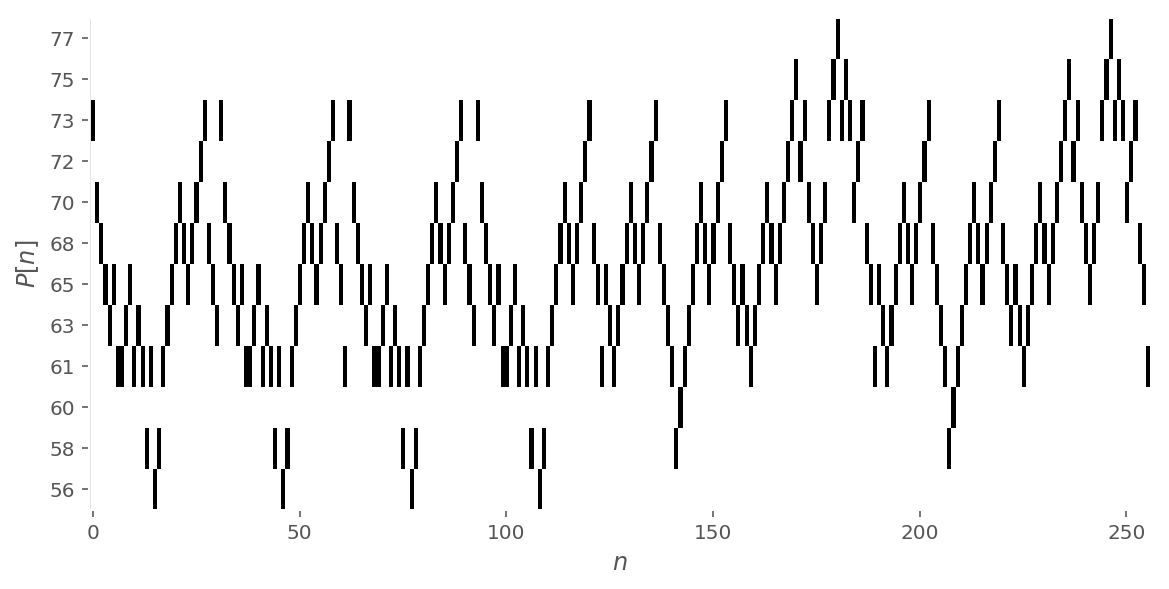

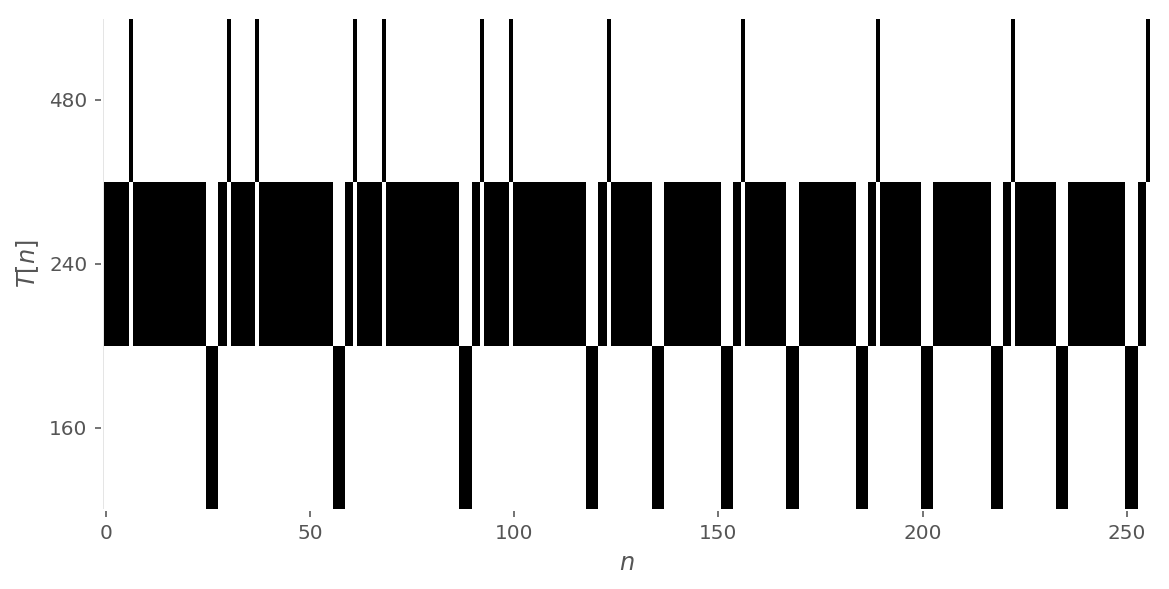

In [18]:
plotMelody(P, T, dictionaries, PrP=None, PrT=None, H=None)

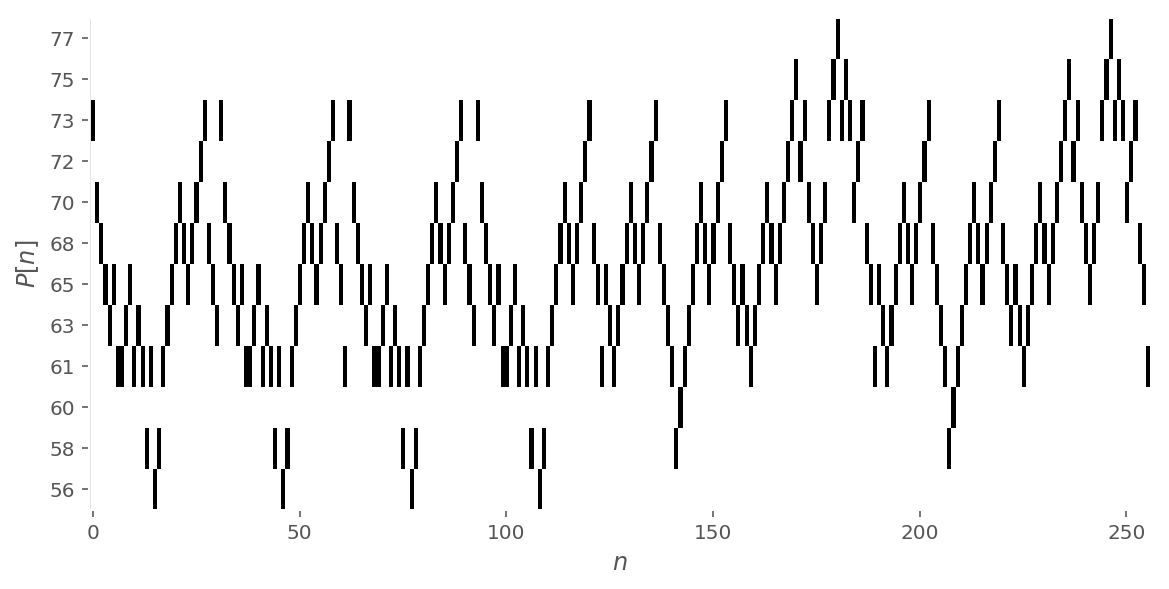

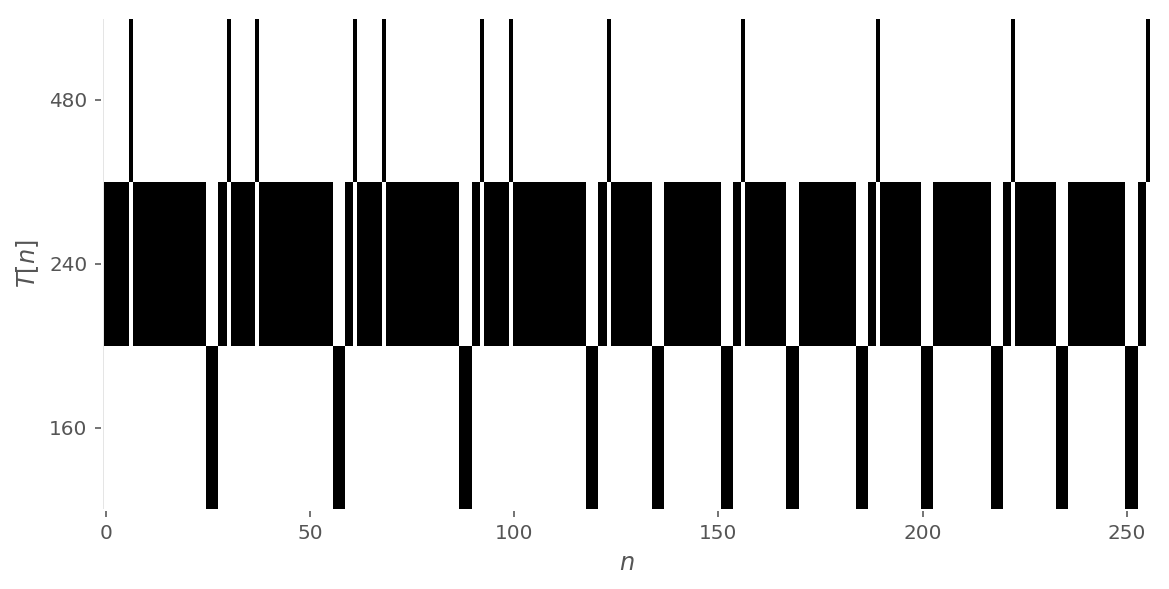

In [19]:
plotMelody(P_note, T_note, dictionaries, PrP=None, PrT=None, H=None)

## Exercise 3: Data reprocessing
### Description

Before moving to the implementation of your RNN generative model of note transition, you will perform data exploration and modification. This step will allow your model to get the most out of your original data as well as ensuring some features such as transposition invariance. 

To further improve your model, you might want to reconsider your original data. Many different approaches can be undertaken. Here you are asked to implement the a rare event suppression method and transposition invariance.

**Rare event suppression** If a unit in your network is associated to a duration that happens very rarely in your data, a possible simplification consists in removing the melodies conaining these rare events from your dataset. 
1. Plot and comment the histogram of durations in your entire dataset. Use the labels from the original duration values (rather than the integer representation). 
2. Based on your observations, remove from your dataset melodies containing very rare durations. Adjust the rejection threshold such that at most 5% of the melodies are dicarded with this step. 
3. Recompute the duration dictionary based on your filtered dataset and plot the new histogram of durations. 

**Transposition invariance** A melody is perceived similarly by the human ear if it's shifted up or down by a constant offset (see [transposition](https://en.wikipedia.org/wiki/Transposition_(music))). Here, you will force your model to be transposition invariant. For this you can choose to use one of two orthogonal methods. The first consists in transposing every melody into a common tonality (C Major/A minor). On the other hand, the second consists in transposing each melody in all possible keys. The second method will increase your dataset size by a factor bigger than 11! As the training time is directly related with the dataset size, to save computing time, we recomand that you implement the first option.

***Pitch normalization*** 
1. Use the provided function to create a new dataset where all melodies are transposed to C Major/A minor. 
2. Plot the histograms of the pitches before and after transposition.

Finally, you shoud recompute the tokenization step for your brand new filtered and normalized dataset.

### Solution

In [9]:
def plot_duration(dataset, dictionary, title): 
    T_time = np.zeros(len(dictionary))
    for label in list(dataset.keys()):
        for duration in dataset[label]['T']:
            n = np.where(duration == dictionary)
            T_time[n] += 1
    T_dict_string = []
    for i in range(0, len(dictionary)):
        T_dict_string.append(str(dictionary[i]))  
    # Make a fake dataset:
    height = T_time
    bars = T_dict_string
    y_pos = np.arange(len(bars))
    # Create bars
    plt.bar(y_pos, height)
    # Create names on the x-axis
    plt.xticks(y_pos, bars, rotation='vertical')
    plt.tick_params(labelsize = 10)
    plt.title(title)
    plt.xlabel('duration')
    plt.ylabel('number of time a duration occured')
    figSize = plt.rcParams['figure.figsize']
    figSize[0] = 12
    figSize[1] = 5
    plt.rcParams['figure.figsize'] = figSize
    # Show graphic
    plt.show()
    
    return T_time


In [22]:
## We see on the plot aboves that the duration 240 is persent in most of the song compared to the other durations.b

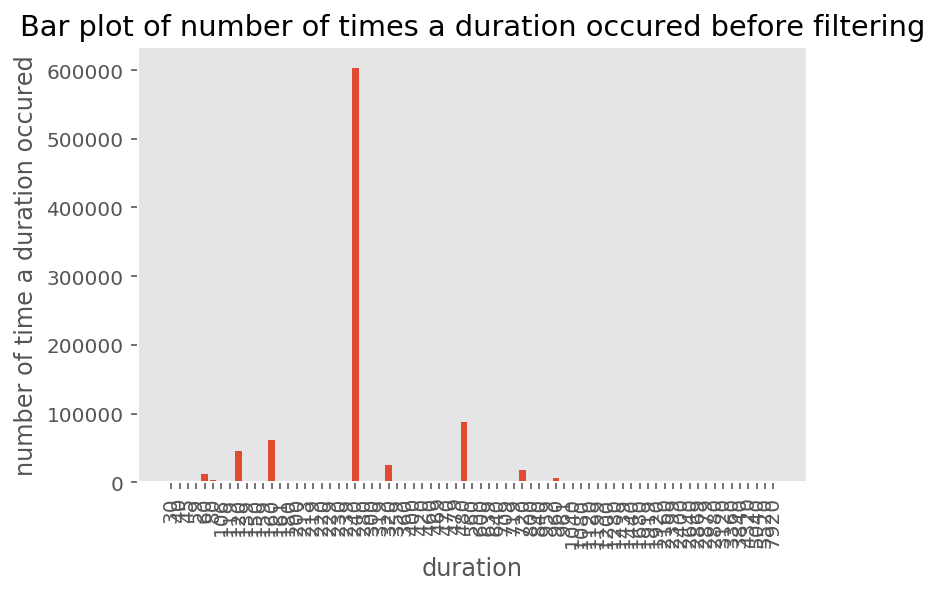

In [10]:
T_time = plot_duration(dataset, T_dict,'Bar plot of number of times a duration occured before filtering')

In [11]:
keep_melodies = {} #np.zeros(len(dataset.keys()))
threshold = 170

for label in list(dataset.keys()):
    keep = True
    for duration in dataset[label]['T']:
        n = np.where(duration == T_dict)
        if(T_time[n] < threshold):
            keep = False
    if(keep):
        keep_melodies[label] = {"T":[], "P": []}
        keep_melodies[label]['T'] = dataset[label]['T'];
        keep_melodies[label]['P'] = dataset[label]['P'];

print("Percentage of kept melodies : ", len(keep_melodies.keys())*100/len(dataset.keys()), "%")

Percentage of kept melodies :  95.43659499780605 %


In [12]:
T_dict_keep, P_dict_keep, int_dataset_keep = compute_dictrionary(keep_melodies)

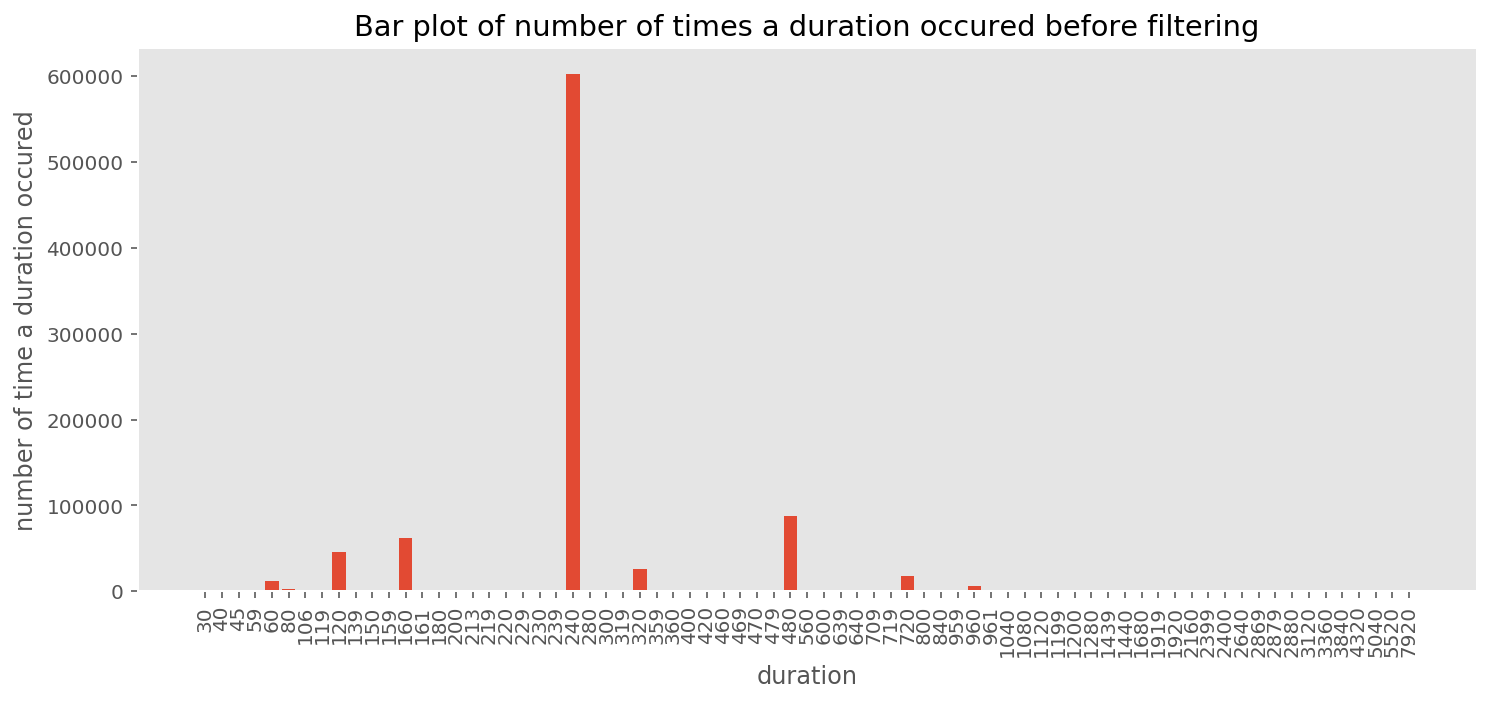

In [76]:
T_time = plot_duration(dataset, T_dict,'Bar plot of number of times a duration occured before filtering')

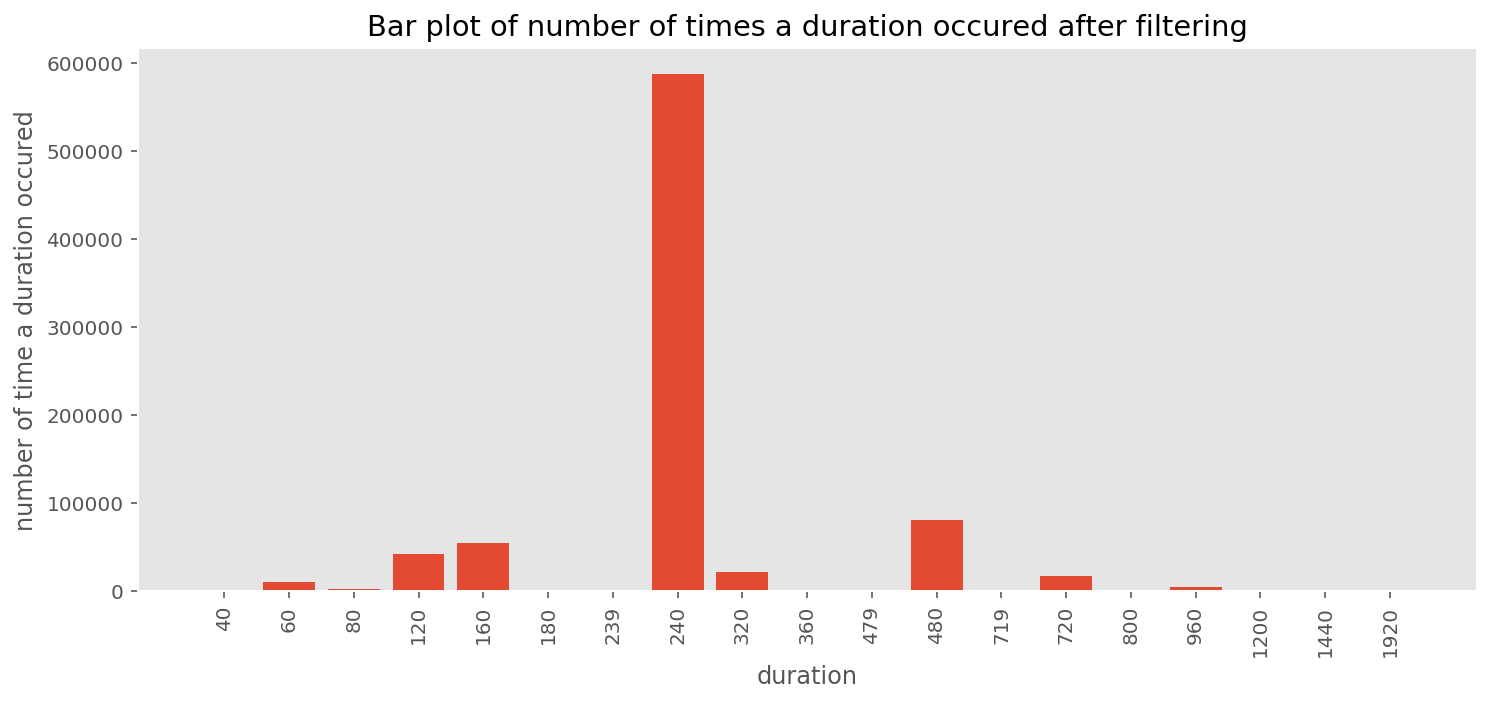

In [77]:
T_time_keep = plot_duration(keep_melodies, T_dict_keep,'Bar plot of number of times a duration occured after filtering')

In [ ]:
###################################  PART 2  #####################################################

In [13]:
def transposeDataset(dataset):
    transposed_dataset = {}

    for label in list(dataset.keys()):
        transposed_dataset[label] = {}
        score = music21.converter.parse(datapath+label+".mid")
        key = score.analyze('key')
        if key.mode == "major":
            i = music21.interval.Interval(key.tonic, music21.pitch.Pitch('C'))
        elif key.mode == "minor":
            i = music21.interval.Interval(key.tonic, music21.pitch.Pitch('A'))
        i = i.semitones
        transposed_dataset[label]['P'] = [p+i for p in dataset[label]['P']]
        transposed_dataset[label]['T'] = dataset[label]['T']
        
    return transposed_dataset

In [14]:
transposed_dataset = transposeDataset(keep_melodies)

In [15]:
def plot_pitch(dataset, dictionary, title): 
    P_time = np.zeros(len(dictionary))
    for label in list(dataset.keys()):
        for duration in dataset[label]['P']:
            n = np.where(duration == dictionary)
            P_time[n] += 1
    P_dict_string = []
    for i in range(0, len(dictionary)):
        P_dict_string.append(str(dictionary[i]))  
    # Make a fake dataset:
    height = P_time
    bars = P_dict_string
    y_pos = np.arange(len(bars))
    # Create bars
    plt.bar(y_pos, height)
    # Create names on the x-axis
    plt.xticks(y_pos, bars, rotation='vertical')
    plt.tick_params(labelsize = 10)
    plt.title(title)
    plt.xlabel('pitch')
    plt.ylabel('number of time a pitch occured')
    figSize = plt.rcParams['figure.figsize']
    figSize[0] = 12
    figSize[1] = 5
    plt.rcParams['figure.figsize'] = figSize
    # Show graphic
    plt.show()
    
    return P_time

In [16]:
T_dict_transposed, P_dict_transposed, int_transposed_dataset = compute_dictrionary(transposed_dataset)

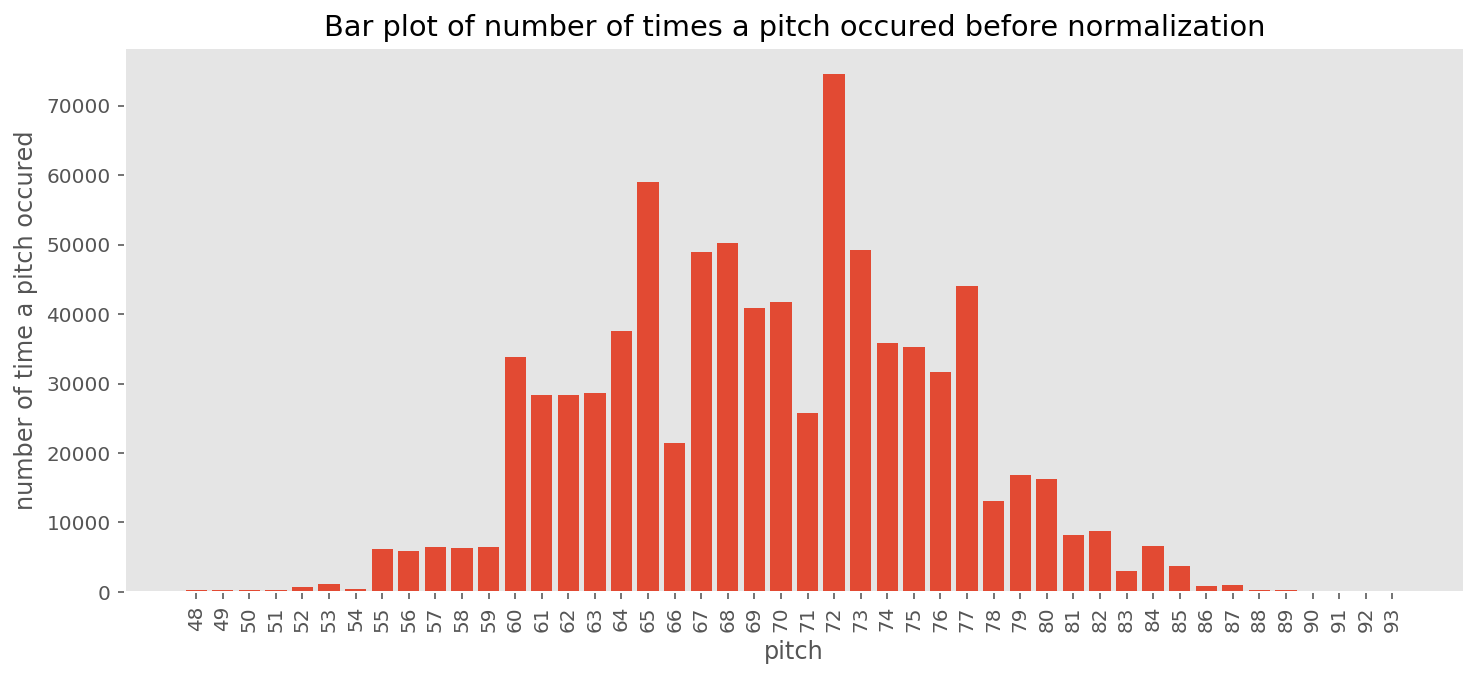

In [48]:
P_time = plot_pitch(keep_melodies,P_dict_keep, 'Bar plot of number of times a pitch occured before normalization')

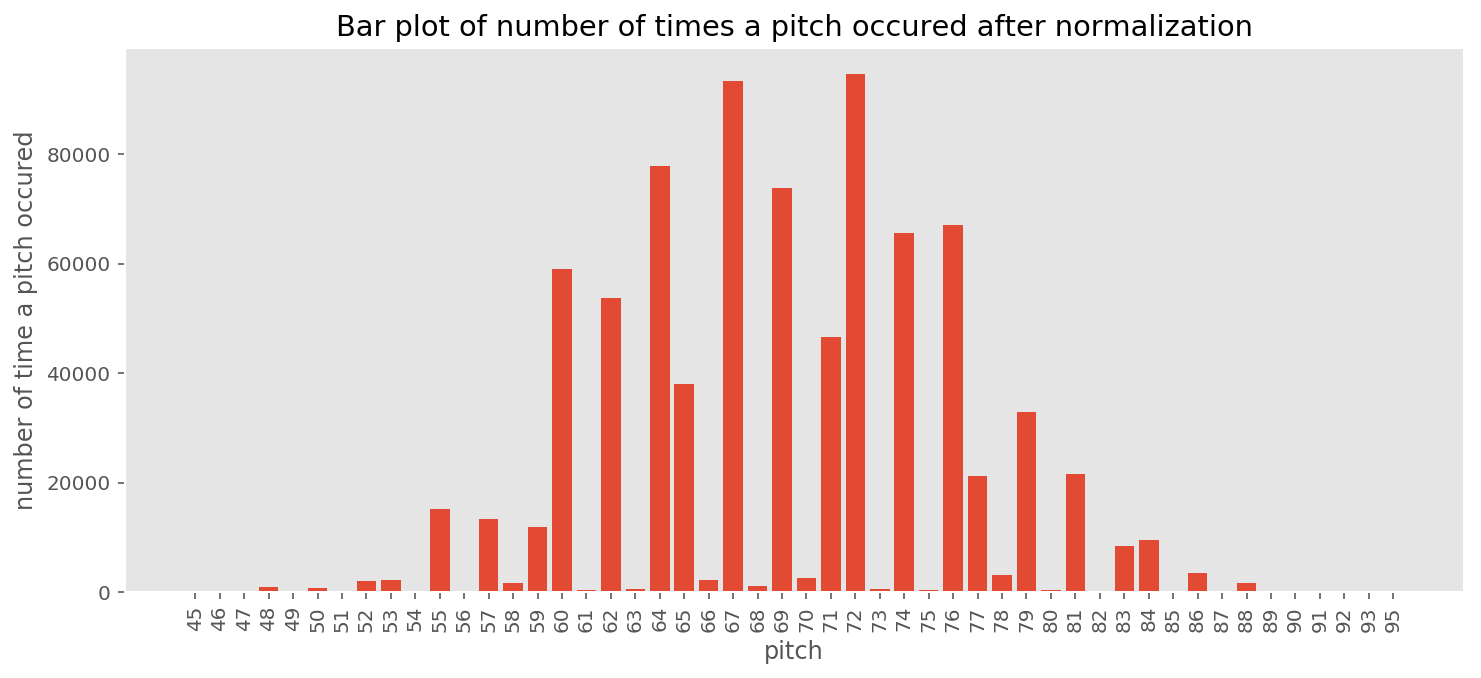

In [49]:
P_time = plot_pitch(transposed_dataset, P_dict_transposed, 'Bar plot of number of times a pitch occured after normalization')

In [17]:
# Write to file
f_myfile = open('save/transposed_data.pickle', 'wb')
pickle.dump(transposed_dataset, f_myfile)
f_myfile.close()

**Question**: How much did you reduce the space of possible durations with your rare event suppression procedure? What is the impact in term of training time?
    
**Answer**: The original dataset contained 73 different durations, after the filtration step we only had 19 by removing melodies that contained duration that appeared less than 170 times. With fewer features, the training time will be significantly reduced without hurting the performance of our model

**Question**: Explain why and how both transposition to a single tonality and to all possible tonalities can yield transposition invariance in your model. 

**Answer**: In the case of transposition to a single tonality, each music will be transposed (pre-processing part) to one tonality thus implying that the model will percieve each music independently to their tonality. In the other case, transposing the melodies to all tonalities will make the model transpotition invariant as it will be trained for all melodies in all tonalities. If we train our model for a dataset without transposing our pitch beforehand, the model could link a tonality with a specific pattern of notes. For music, you do not want this kind of behaviour as we want to emphasize the relative relationships over the absolute positions: a C major chords sounds more like a D major chord than like a C minor chord, even though the C minor chord is closer with regard to absolute note positions.


**Question**: In terms of number of dimensions, what would have been the impact of keeping the joint represenation of a note duration and pitch (vs separating the two features)? 

**Answer**: Keeping the note with pitch and duration joined would give a huge dimentional dataset composed of all combination of possible pitch and duration. This note representation implies a large number of neurons in the network in order to predice the next note. Having notes separated help us to have fewer features and reduce the dimention of the dataset thus having fewer neurones to predict the notes duration and pitch separately.

**Question**: How would the distribution of notes in the joint representation differ from the distributions in the pitch and duration only representations (as shown by your histograms above)?

**Answer**: The ensemble of notes in the joint representation would give a broad and sparse distribution. We would have a larger dictionary of notes and the ones with lower occurancies would be considered as rare events and would be excluded in the predictions. By separating the features in pitch and duration we can more efficiently filter duration while doing transpoition invariance and thus recuducing the distribution as seen in the histograms above.

## Exercise 4: One-hot and zero-padding
### Description

The last few steps to be able to feed (note by note) your music scores to a RNN model are
1. Transform the sequence of integers into a sequence of vectors in the one-hot encoding scheme.
2. Homegenize the length of each sequence

**One-hot encode** You can implement your own integer to one-hot code. For this use the numpy library and the suitable datatype. Alternatively, Keras provides a [built in one-hot encoding scheme](https://keras.io/utils/#to_categorical). After this step, for each melody, you should have two similar length matrices with one representing the sequence of note pitches and the other the sequence of note durations.
1. Code the integer representation into matrices of one-hot vectors

**Zero-padding** Most deep learning libraries, including Keras, require that you specify the shape of the input data. As such, you cannot have variable length inputs per-se. The trick to handle them is [zero-padding](https://keras.io/preprocessing/sequence/#pad_sequences). Provided with the [Masking Layer](https://keras.io/layers/core/#masking) Keras will then ignore time steps where all inputs are 0.
1. Extend the end of each melody matrices with vectors containing only zeros until all melodies have the same size. For simplicity, use the Keras pad_sequences function. There might be some rare very long melodies in your dataset, a possible choice is to set the 'maxlen' argument of pad_sequences to the mean+2std of the melody lengths. This ensure that 95% of your melodies would end before being truncated.
2. Check and display the dimension of the resulting tensors. Typically, the tensor representing the sequence of pitches should be of shape [number of melodies x number of notes x number of entries in the pitch dictionary] and the tensor representing the sequence of durations [number of melodies x number of notes x number of entries in the duration dictionary]

To check if this step was done correctly use the provided plotMelody function. For two randomly selected melodies, call the plotMelody function before and after one-hot/zero-pad. You should obtain the same plots (or slightly truncated if you randomly selected one belonging to 5% longest).

Finally, we strongly suggest that you save your preprocessed data now.

### Solution

In [7]:
#get the transposed data
f_myfile = open('save/transposed_data.pickle', 'rb')
transposed_dataset = pickle.load(f_myfile)  # variables come out in the order you put them in
f_myfile.close()

T_dict_transposed, P_dict_transposed, int_transposed_dataset = compute_dictrionary(transposed_dataset)


In [8]:
size = np.zeros(len(transposed_dataset))
i = 0
for label in transposed_dataset.keys():
    size[i] = len(transposed_dataset[label]['T'])
    i += 1
max_size = int(np.mean(size) + 2*np.std(size)) # mean + 2std

print ("mean + 2std of the melodies = " + str(max_size))

mean + 2std of the melodies = 391


In [9]:
categorical_T = []
categorical_P = []

for label in int_transposed_dataset.keys():
    T_trans = np.array(int_transposed_dataset[label]['T'])
    P_trans = np.array(int_transposed_dataset[label]['P'])
    mat_T = keras.utils.to_categorical(T_trans)
    mat_P = keras.utils.to_categorical(P_trans)
    
    categorical_T.append(mat_T)
    categorical_P.append(mat_P)

In [10]:
for i in range(len(categorical_T)): 
    categorical_P[i] = pad_sequences(categorical_P[i], maxlen=len(P_dict_transposed), padding='post', truncating='post')
    interm = categorical_P[i].T
    interm = pad_sequences(interm, maxlen=max_size, padding='post', truncating='post')
    categorical_P[i] = interm.T

    categorical_T[i] = pad_sequences(categorical_T[i], maxlen=len(T_dict_transposed), padding='post', truncating='post')
    interm = categorical_T[i].T
    interm = pad_sequences(interm, maxlen=max_size, padding='post', truncating='post')
    categorical_T[i] = interm.T

categorical_T = np.array(categorical_T)
categorical_P = np.array(categorical_P)

print("Pitch tensor shape : ", np.shape(categorical_P))
print("Duration tensor shape : ", np.shape(categorical_T))
print('\n')
print("The results are as expected \n Number of melodies: "+str(len(transposed_dataset.keys()))+"\n Melody length Homegenize: " + str(max_size) + "\n Number of pitches: "+str(len(P_dict_transposed))+"\n Number of duration: " + str(len(T_dict_transposed)))

Pitch tensor shape :  (4350, 391, 50)
Duration tensor shape :  (4350, 391, 19)


The results are as expected 
 Number of melodies: 4350
 Melody length Homegenize: 391
 Number of pitches: 50
 Number of duration: 19


In [13]:
#save data for latter

dictionary = {'T': T_dict_transposed, 'P': P_dict_transposed}

f_myfile = open('save/transposed_dictionary.pickle', 'wb')
pickle.dump(dictionary, f_myfile)
f_myfile.close()

np.save('save/categorical_T', categorical_T)
np.save('save/categorical_P', categorical_P)

In [11]:
categorical_T = np.load('save/categorical_T.npy')
categorical_P = np.load('save/categorical_P.npy')
f_myfile = open('save/transposed_dictionary.pickle', 'rb')
dictionaries = pickle.load(f_myfile)  # variables come out in the order you put them in
f_myfile.close()

## Exercise 5: Building and training a generative model of  note transition with the Keras functional API
### Description

The Keras Sequential model is very efficient for fast prototyping, however suffers from a lack of design liberty. The Keras Functional API is only slightly more complex but allows for more control on the different parts of your model. You will be using the Functional API for the rest of this project. Please read carefully the [documentation](https://keras.io/getting-started/sequential-model-guide/). 

Here, you will be constructing your RNN model of note transition. To achieve that, your model should be trained to approximate the probability distribution of the upcoming note (observed as two output softmax layers - one for pitch and one for duration) given the current note (given as input) and the model internal representation of the history of notes (its hidden state). To achieve that, set the Keras RNN layer argument "return_sequences" to True when building your model. Doing this will give you an output for each note, rather than a single output at the end of the sequence. During training, the target at each time step is the next note pitch and duration.

You are free to use your own architecture but make sure to use at least 128 hidden units, Masking, and dropout to prevent overfitting. Your model should have two output (softmax) layers, one related to the pitch predictions that you should name `YP`, and the other related to the duration predictions `YT`. You should monitor both the loss (categorical_crossentropy) and the accuracy. For your best model, you should reach 40%/75% accuracy on the pitch/duration predictions.

1. Train your first model composed of SimpleRNN cells for min 250 epochs and save the model/parameters that lead to the higher accuracy on the validating set. Use a validation split of 0.2. Try  If you correctly named the output layers (`YP` and `YT`) use the provided `plotLearningCurves(History)` function to plot the learning curves by giving the History object returned by the Keras fit function as argument.  
2. Train a second model where you replaced the SimpleRNN units with GRUs (LSTM unit equivalent that requires less parameters). Make sure you use the same hyperparameters as before. Plot the learning curves.
3. On a single plot, adapt the `plotLearningCurves(History)` function to compare the validation learning curves of the simpleRNN and GRU models. In other words, plot the validation loss vs epoch for pitch/duration for the simpleRNN and GRU models. Do the same for accuracies.


### Solution

In [5]:
categorical_T = np.load('save/categorical_T.npy')
categorical_P = np.load('save/categorical_P.npy')
f_myfile = open('save/transposed_dictionary.pickle', 'rb')
dictionaries = pickle.load(f_myfile)  # variables come out in the order you put them in
f_myfile.close()

In [6]:
def buildModel(dictionaries, batch_length, dropout=0.2, activation='GRU', Hsize=128):
    X = dict()
    H = dict()
    M = dict()
    Y = dict()
    
    X['T'] = Input(shape=(batch_length, len(dictionaries['T'])), name="XT")
    X['P'] = Input(shape=(batch_length, len(dictionaries['P'])), name="XP")
    
    M['T'] = Masking(mask_value=0., name="MT")(X['T'])
    M['P'] = Masking(mask_value=0., name="MP")(X['P'])
    
    H['1'] = Concatenate(name="MergeX")([M['T'], M['P']])
    if activation == 'GRU':
        gru = GRU(128, return_sequences= True, dropout=dropout, name = "GRU1")(H['1'])
        Y['T'] = TimeDistributed(Dense(len(dictionaries['T']), activation='softmax'), name='YT')(gru)
        Y['P'] = TimeDistributed(Dense(len(dictionaries['P']), activation='softmax'), name='YP')(gru)
        #Your hidden layer(s) architecture with GRU
        
    elif activation == 'LSTM':
        print("LSTM not defined")
        #Your hidden layer(s) architecture with LSTM (For your own curiosity, not required for the project)
        
    elif activation == 'RNN':
        #Your hidden layer(s) architecture with SimpleRNN
        SRNN = SimpleRNN(128, return_sequences= True, dropout=dropout, name = "RNN1")(H['1'])
        Y['T'] = TimeDistributed(Dense(len(dictionaries['T']), activation='softmax'), name='YT')(SRNN)
        Y['P'] = TimeDistributed(Dense(len(dictionaries['P']), activation='softmax'), name='YP')(SRNN)   

    model = Model(inputs = [X['T'], X['P']], outputs = [Y['T'], Y['P']])
    opt = Adam()
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=opt,
        metrics=['acc'])

    return model

# We took 390 notes and not 391 because there is no next note to predict after the last one.
RNNmodel = buildModel(dictionaries,
                      batch_length= 390,#Put here the number of notes (timesteps) you have in your Zero-padded matrices
                      activation='RNN')
GRUmodel = buildModel(dictionaries,
                     batch_length = 390,
                     activation ='GRU')
print("Simple RNN model \n")
RNNmodel.summary()
print("\n GRU model \n")
GRUmodel.summary()

Simple RNN model 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
XT (InputLayer)                 (None, 390, 19)      0                                            
__________________________________________________________________________________________________
XP (InputLayer)                 (None, 390, 50)      0                                            
__________________________________________________________________________________________________
MT (Masking)                    (None, 390, 19)      0           XT[0][0]                         
__________________________________________________________________________________________________
MP (Masking)                    (None, 390, 50)      0           XP[0][0]                         
__________________________________________________________________________________________

In [7]:
def shift_1(xs):
    e = np.empty_like(xs)
    shape1 = int(len(xs))
    e[:-1] = xs[1:]
    e[-1:] = 0
    return e
# this is a function to shift the values in the arrays. 
# if we have and array x = [1,2,3,4,5]
# shift_1(x) would give [2,3,4,5,0]

In [8]:
shift_T = np.copy(categorical_T)
shift_P = np.copy(categorical_P)

for i in range(np.shape(categorical_T)[0]):
    shift_T[i] = shift_1(categorical_T[i])
    shift_P[i] = shift_1(categorical_P[i])

In [9]:
# We do not take the last note because it does not have a next value to predict

historyRNN = RNNmodel.fit([categorical_T[:,0:-1,:], categorical_P[:,0:-1,:]],[shift_T[:,0:-1,:], shift_P[:,0:-1,:]], batch_size=128, epochs= 250,  verbose=1,  validation_split = 0.2)


Train on 3480 samples, validate on 870 samples
Epoch 1/250
3480/3480 [==============================] - 35s 10ms/step - loss: 4.5750 - YT_loss: 1.4276 - YP_loss: 3.1474 - YT_acc: 0.6468 - YP_acc: 0.1016 - val_loss: 3.8887 - val_YT_loss: 1.0797 - val_YP_loss: 2.8091 - val_YT_acc: 0.7122 - val_YP_acc: 0.1324
Epoch 2/250
3480/3480 [==============================] - 35s 10ms/step - loss: 3.8211 - YT_loss: 1.0473 - YP_loss: 2.7738 - YT_acc: 0.7062 - YP_acc: 0.1442 - val_loss: 3.5885 - val_YT_loss: 0.8952 - val_YP_loss: 2.6933 - val_YT_acc: 0.7413 - val_YP_acc: 0.1587
Epoch 3/250
3480/3480 [==============================] - 35s 10ms/step - loss: 3.5352 - YT_loss: 0.9426 - YP_loss: 2.5926 - YT_acc: 0.7385 - YP_acc: 0.1838 - val_loss: 3.3541 - val_YT_loss: 0.8671 - val_YP_loss: 2.4870 - val_YT_acc: 0.7479 - val_YP_acc: 0.2041
Epoch 4/250
3480/3480 [==============================] - 33s 10ms/step - loss: 3.3288 - YT_loss: 0.8856 - YP_loss: 2.4433 - YT_acc: 0.7502 - YP_acc: 0.2180 - val_loss: 3.

3480/3480 [==============================] - 32s 9ms/step - loss: 2.6074 - YT_loss: 0.6974 - YP_loss: 1.9100 - YT_acc: 0.7972 - YP_acc: 0.3277 - val_loss: 2.4503 - val_YT_loss: 0.6270 - val_YP_loss: 1.8233 - val_YT_acc: 0.8154 - val_YP_acc: 0.3613
Epoch 64/250
3480/3480 [==============================] - 32s 9ms/step - loss: 2.5912 - YT_loss: 0.6796 - YP_loss: 1.9116 - YT_acc: 0.7992 - YP_acc: 0.3264 - val_loss: 2.4474 - val_YT_loss: 0.6265 - val_YP_loss: 1.8209 - val_YT_acc: 0.8140 - val_YP_acc: 0.3606
Epoch 65/250
3480/3480 [==============================] - 32s 9ms/step - loss: 2.5902 - YT_loss: 0.6815 - YP_loss: 1.9087 - YT_acc: 0.7997 - YP_acc: 0.3287 - val_loss: 2.4542 - val_YT_loss: 0.6313 - val_YP_loss: 1.8229 - val_YT_acc: 0.8136 - val_YP_acc: 0.3593
Epoch 66/250
3480/3480 [==============================] - 32s 9ms/step - loss: 2.5934 - YT_loss: 0.6877 - YP_loss: 1.9057 - YT_acc: 0.7998 - YP_acc: 0.3288 - val_loss: 2.4491 - val_YT_loss: 0.6295 - val_YP_loss: 1.8196 - val_YT_ac

3480/3480 [==============================] - 32s 9ms/step - loss: 2.5370 - YT_loss: 0.6554 - YP_loss: 1.8816 - YT_acc: 0.8059 - YP_acc: 0.3384 - val_loss: 2.3868 - val_YT_loss: 0.5917 - val_YP_loss: 1.7950 - val_YT_acc: 0.8221 - val_YP_acc: 0.3697
Epoch 126/250
3480/3480 [==============================] - 32s 9ms/step - loss: 2.5397 - YT_loss: 0.6542 - YP_loss: 1.8855 - YT_acc: 0.8069 - YP_acc: 0.3384 - val_loss: 2.3885 - val_YT_loss: 0.5922 - val_YP_loss: 1.7963 - val_YT_acc: 0.8224 - val_YP_acc: 0.3691
Epoch 127/250
3480/3480 [==============================] - 32s 9ms/step - loss: 2.5341 - YT_loss: 0.6517 - YP_loss: 1.8824 - YT_acc: 0.8061 - YP_acc: 0.3385 - val_loss: 2.3820 - val_YT_loss: 0.5877 - val_YP_loss: 1.7943 - val_YT_acc: 0.8209 - val_YP_acc: 0.3700
Epoch 128/250
3480/3480 [==============================] - 32s 9ms/step - loss: 2.5240 - YT_loss: 0.6456 - YP_loss: 1.8785 - YT_acc: 0.8075 - YP_acc: 0.3405 - val_loss: 2.3798 - val_YT_loss: 0.5856 - val_YP_loss: 1.7942 - val_YT

3480/3480 [==============================] - 32s 9ms/step - loss: 2.4722 - YT_loss: 0.6265 - YP_loss: 1.8458 - YT_acc: 0.8094 - YP_acc: 0.3511 - val_loss: 2.3136 - val_YT_loss: 0.5592 - val_YP_loss: 1.7544 - val_YT_acc: 0.8268 - val_YP_acc: 0.3826
Epoch 188/250
3480/3480 [==============================] - 32s 9ms/step - loss: 2.4668 - YT_loss: 0.6234 - YP_loss: 1.8434 - YT_acc: 0.8103 - YP_acc: 0.3519 - val_loss: 2.3257 - val_YT_loss: 0.5599 - val_YP_loss: 1.7658 - val_YT_acc: 0.8259 - val_YP_acc: 0.3862
Epoch 189/250
3480/3480 [==============================] - 32s 9ms/step - loss: 2.4678 - YT_loss: 0.6240 - YP_loss: 1.8439 - YT_acc: 0.8115 - YP_acc: 0.3515 - val_loss: 2.3073 - val_YT_loss: 0.5581 - val_YP_loss: 1.7492 - val_YT_acc: 0.8264 - val_YP_acc: 0.3873
Epoch 190/250
3480/3480 [==============================] - 32s 9ms/step - loss: 2.4631 - YT_loss: 0.6237 - YP_loss: 1.8394 - YT_acc: 0.8104 - YP_acc: 0.3520 - val_loss: 2.3098 - val_YT_loss: 0.5601 - val_YP_loss: 1.7497 - val_YT

3480/3480 [==============================] - 32s 9ms/step - loss: 2.4356 - YT_loss: 0.6108 - YP_loss: 1.8249 - YT_acc: 0.8132 - YP_acc: 0.3588 - val_loss: 2.2796 - val_YT_loss: 0.5444 - val_YP_loss: 1.7352 - val_YT_acc: 0.8297 - val_YP_acc: 0.3918
Epoch 250/250
3480/3480 [==============================] - 32s 9ms/step - loss: 2.4337 - YT_loss: 0.6083 - YP_loss: 1.8255 - YT_acc: 0.8130 - YP_acc: 0.3579 - val_loss: 2.2987 - val_YT_loss: 0.5491 - val_YP_loss: 1.7496 - val_YT_acc: 0.8265 - val_YP_acc: 0.3862


In [10]:
historyGRU = GRUmodel.fit([categorical_T[:,0:-1,:], categorical_P[:,0:-1,:]],[shift_T[:,0:-1,:], shift_P[:,0:-1,:]], batch_size=128, epochs= 250,  verbose=1,  validation_split = 0.2)


Train on 3480 samples, validate on 870 samples
Epoch 1/250
3480/3480 [==============================] - 50s 14ms/step - loss: 5.4834 - YT_loss: 2.0027 - YP_loss: 3.4808 - YT_acc: 0.6193 - YP_acc: 0.1009 - val_loss: 4.0149 - val_YT_loss: 1.0659 - val_YP_loss: 2.9490 - val_YT_acc: 0.7149 - val_YP_acc: 0.1128
Epoch 2/250
3480/3480 [==============================] - 51s 15ms/step - loss: 3.8899 - YT_loss: 1.0755 - YP_loss: 2.8145 - YT_acc: 0.7054 - YP_acc: 0.1456 - val_loss: 3.6873 - val_YT_loss: 0.9730 - val_YP_loss: 2.7143 - val_YT_acc: 0.7162 - val_YP_acc: 0.1402
Epoch 3/250
3480/3480 [==============================] - 52s 15ms/step - loss: 3.6261 - YT_loss: 0.9849 - YP_loss: 2.6412 - YT_acc: 0.7132 - YP_acc: 0.1910 - val_loss: 3.3777 - val_YT_loss: 0.9131 - val_YP_loss: 2.4646 - val_YT_acc: 0.7273 - val_YP_acc: 0.2228
Epoch 4/250
3480/3480 [==============================] - 52s 15ms/step - loss: 3.3463 - YT_loss: 0.9335 - YP_loss: 2.4128 - YT_acc: 0.7369 - YP_acc: 0.2217 - val_loss: 3.

3480/3480 [==============================] - 52s 15ms/step - loss: 2.3855 - YT_loss: 0.5872 - YP_loss: 1.7983 - YT_acc: 0.8180 - YP_acc: 0.3686 - val_loss: 2.3129 - val_YT_loss: 0.5657 - val_YP_loss: 1.7472 - val_YT_acc: 0.8237 - val_YP_acc: 0.3869
Epoch 64/250
3480/3480 [==============================] - 52s 15ms/step - loss: 2.3809 - YT_loss: 0.5844 - YP_loss: 1.7965 - YT_acc: 0.8185 - YP_acc: 0.3693 - val_loss: 2.3092 - val_YT_loss: 0.5634 - val_YP_loss: 1.7459 - val_YT_acc: 0.8243 - val_YP_acc: 0.3870
Epoch 65/250
3480/3480 [==============================] - 52s 15ms/step - loss: 2.3763 - YT_loss: 0.5823 - YP_loss: 1.7940 - YT_acc: 0.8191 - YP_acc: 0.3696 - val_loss: 2.3051 - val_YT_loss: 0.5639 - val_YP_loss: 1.7412 - val_YT_acc: 0.8242 - val_YP_acc: 0.3886
Epoch 66/250
3480/3480 [==============================] - 52s 15ms/step - loss: 2.3760 - YT_loss: 0.5842 - YP_loss: 1.7918 - YT_acc: 0.8174 - YP_acc: 0.3705 - val_loss: 2.3037 - val_YT_loss: 0.5634 - val_YP_loss: 1.7402 - val_Y

3480/3480 [==============================] - 52s 15ms/step - loss: 2.1987 - YT_loss: 0.5157 - YP_loss: 1.6831 - YT_acc: 0.8296 - YP_acc: 0.4102 - val_loss: 2.1436 - val_YT_loss: 0.5015 - val_YP_loss: 1.6420 - val_YT_acc: 0.8341 - val_YP_acc: 0.4247
Epoch 126/250
3480/3480 [==============================] - 52s 15ms/step - loss: 2.2017 - YT_loss: 0.5173 - YP_loss: 1.6845 - YT_acc: 0.8293 - YP_acc: 0.4097 - val_loss: 2.1453 - val_YT_loss: 0.5011 - val_YP_loss: 1.6443 - val_YT_acc: 0.8344 - val_YP_acc: 0.4214
Epoch 127/250
3480/3480 [==============================] - 52s 15ms/step - loss: 2.1975 - YT_loss: 0.5130 - YP_loss: 1.6845 - YT_acc: 0.8304 - YP_acc: 0.4099 - val_loss: 2.1431 - val_YT_loss: 0.5010 - val_YP_loss: 1.6422 - val_YT_acc: 0.8340 - val_YP_acc: 0.4231
Epoch 128/250
3480/3480 [==============================] - 52s 15ms/step - loss: 2.1935 - YT_loss: 0.5120 - YP_loss: 1.6816 - YT_acc: 0.8307 - YP_acc: 0.4115 - val_loss: 2.1388 - val_YT_loss: 0.5006 - val_YP_loss: 1.6382 - va

3480/3480 [==============================] - 52s 15ms/step - loss: 2.1078 - YT_loss: 0.4924 - YP_loss: 1.6153 - YT_acc: 0.8341 - YP_acc: 0.4349 - val_loss: 2.0803 - val_YT_loss: 0.4873 - val_YP_loss: 1.5930 - val_YT_acc: 0.8361 - val_YP_acc: 0.4421
Epoch 188/250
3480/3480 [==============================] - 52s 15ms/step - loss: 2.1048 - YT_loss: 0.4887 - YP_loss: 1.6160 - YT_acc: 0.8337 - YP_acc: 0.4349 - val_loss: 2.0788 - val_YT_loss: 0.4865 - val_YP_loss: 1.5923 - val_YT_acc: 0.8360 - val_YP_acc: 0.4423
Epoch 189/250
3480/3480 [==============================] - 52s 15ms/step - loss: 2.1037 - YT_loss: 0.4905 - YP_loss: 1.6132 - YT_acc: 0.8345 - YP_acc: 0.4357 - val_loss: 2.0778 - val_YT_loss: 0.4875 - val_YP_loss: 1.5903 - val_YT_acc: 0.8365 - val_YP_acc: 0.4437
Epoch 190/250
3480/3480 [==============================] - 53s 15ms/step - loss: 2.1012 - YT_loss: 0.4912 - YP_loss: 1.6100 - YT_acc: 0.8342 - YP_acc: 0.4371 - val_loss: 2.0777 - val_YT_loss: 0.4868 - val_YP_loss: 1.5909 - va

3480/3480 [==============================] - 52s 15ms/step - loss: 2.0520 - YT_loss: 0.4797 - YP_loss: 1.5723 - YT_acc: 0.8359 - YP_acc: 0.4501 - val_loss: 2.0550 - val_YT_loss: 0.4812 - val_YP_loss: 1.5737 - val_YT_acc: 0.8369 - val_YP_acc: 0.4484
Epoch 250/250
3480/3480 [==============================] - 52s 15ms/step - loss: 2.0536 - YT_loss: 0.4801 - YP_loss: 1.5736 - YT_acc: 0.8361 - YP_acc: 0.4509 - val_loss: 2.0464 - val_YT_loss: 0.4805 - val_YP_loss: 1.5659 - val_YT_acc: 0.8367 - val_YP_acc: 0.4523


In [11]:
# save the models

(RNNmodel).save('save/RNNmodelWithoutObig.h5')
(GRUmodel).save('save/GRUmodelWithoutObig.h5')

In [12]:
# save the history

f_myfile = open('save/historyRNNdictWithoutObig.pickle', 'wb')
pickle.dump(historyRNN.history, f_myfile)
f_myfile.close()

f_myfile2 = open('save/historyGRUdictWithoutObig.pickle', 'wb')
pickle.dump(historyGRU.history, f_myfile2)
f_myfile2.close()

In [20]:
### load the history

f_myfile1 = open('save/historyRNNdictWithoutObig.pickle', 'rb')
historyRNNdict = pickle.load(f_myfile1)  # variables come out in the order you put them in
f_myfile1.close()

f_myfile2 = open('save/historyGRUdictWithoutObig.pickle', 'rb')
historyGRUdict = pickle.load(f_myfile2)  # variables come out in the order you put them in
f_myfile2.close()

In [21]:
def plotTwoLearningCurves(history1, history2, title):
    
    plt.figure(figsize=(8,4))
    #plt.plot(history['YP_loss'], '--', c=c[0], label='Pitch train loss')
    plt.plot(history1['val_YP_loss'], '--', c=c[0], label='RNN: Pitch val loss')
    plt.plot(history2['val_YP_loss'], c=c[0], label='GRU: Pitch val loss')
    
    #plt.plot(history['YT_loss'], '--', c=c[1], label='Dur train loss')
    plt.plot(history1['val_YT_loss'], '--', c=c[1], label='RNN: Dur val loss')
    plt.plot(history2['val_YT_loss'], c=c[1], label='GRU: Dur val loss')
    plt.legend(loc='best')
    plt.title('Losses along epochs for {}'.format(title))
    
    plt.figure(figsize=(8,4))
    #plt.plot(history['YP_acc'], '--', c=c[0], label='Pitch train acc')
    plt.plot(history1['val_YP_acc'], '--', c=c[0], label='RNN: Pitch val acc')
    plt.plot(history2['val_YP_acc'], c=c[0], label='GRU: Pitch val acc')
    
    #plt.plot(log['YT_acc'], '--', c=c[1], label='Dur train acc')
    plt.plot(history1['val_YT_acc'], '--', c=c[1], label='RNN: Dur val acc')
    plt.plot(history2['val_YT_acc'], c=c[1], label='GRU: Dur val acc')
    plt.title('Accuracies along epochs for {}'.format(title))
    
    plt.legend(loc='best')

In [22]:
#define another plot function to plot directly from history.history
def plotLearningCurvesFromDict(history,title):
    
    log = history
    
    plt.figure(figsize=(8,4))
    plt.plot(log['YP_loss'], '--', c=c[0], label='Pitch train loss')
    plt.plot(log['val_YP_loss'], c=c[0], label='Pitch val loss')
    
    plt.plot(log['YT_loss'], '--', c=c[1], label='Dur train loss')
    plt.plot(log['val_YT_loss'], c=c[1], label='Dur val loss')
    plt.legend(loc='best')
    plt.title('Losses along epochs for {}'.format(title))
    
    plt.figure(figsize=(8,4))
    plt.plot(log['YP_acc'], '--', c=c[0], label='Pitch train acc')
    plt.plot(log['val_YP_acc'], c=c[0], label='Pitch val acc')
    
    plt.plot(log['YT_acc'], '--', c=c[1], label='Dur train acc')
    plt.plot(log['val_YT_acc'], c=c[1], label='Dur val acc')
    plt.legend(loc='best')
    plt.title('Accuracies along epochs for {}'.format(title))


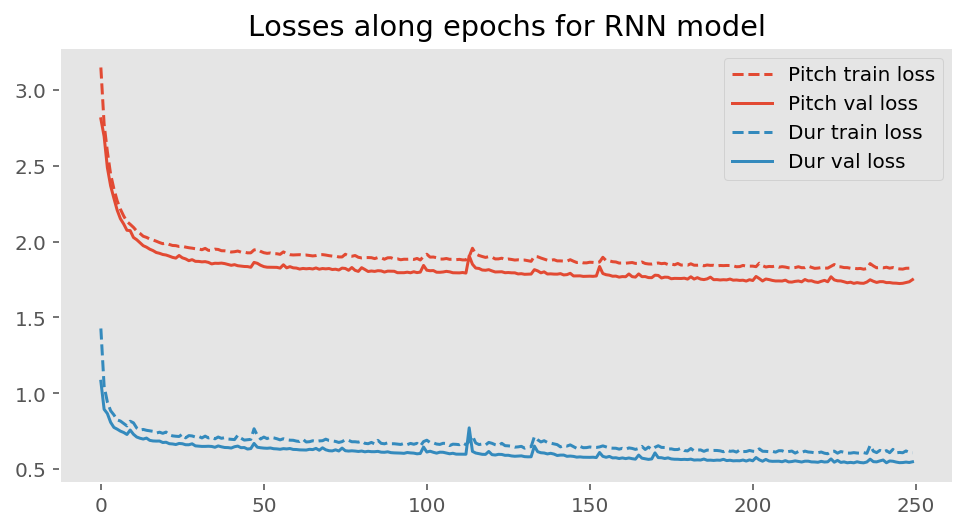

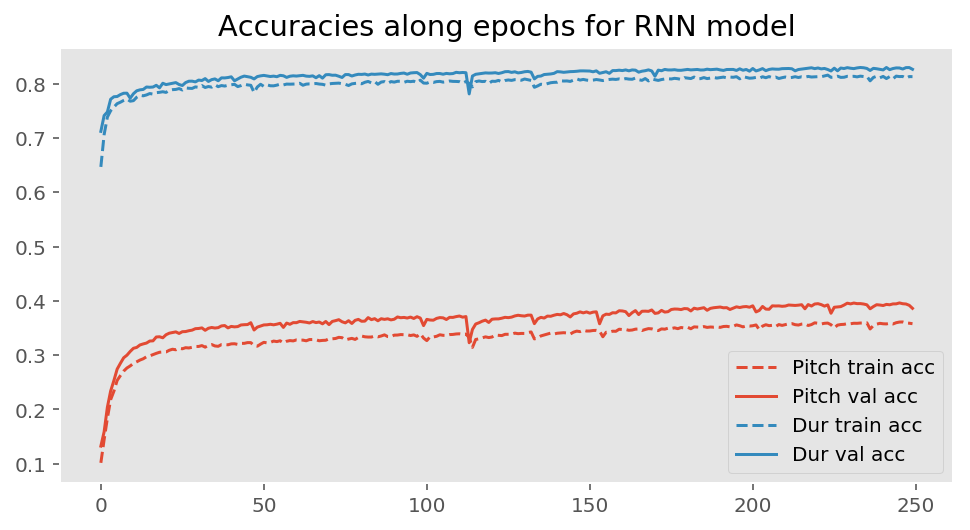

In [23]:
plotLearningCurvesFromDict(historyRNNdict,"RNN model")

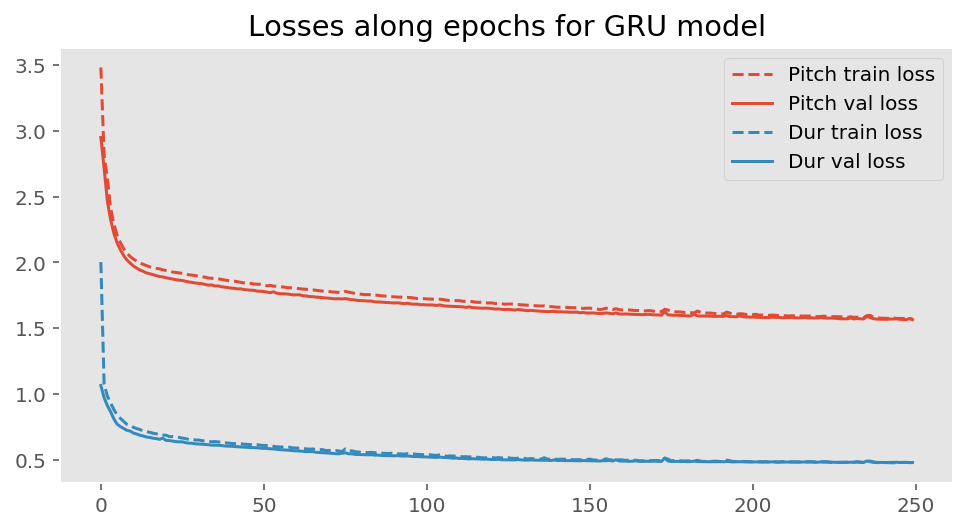

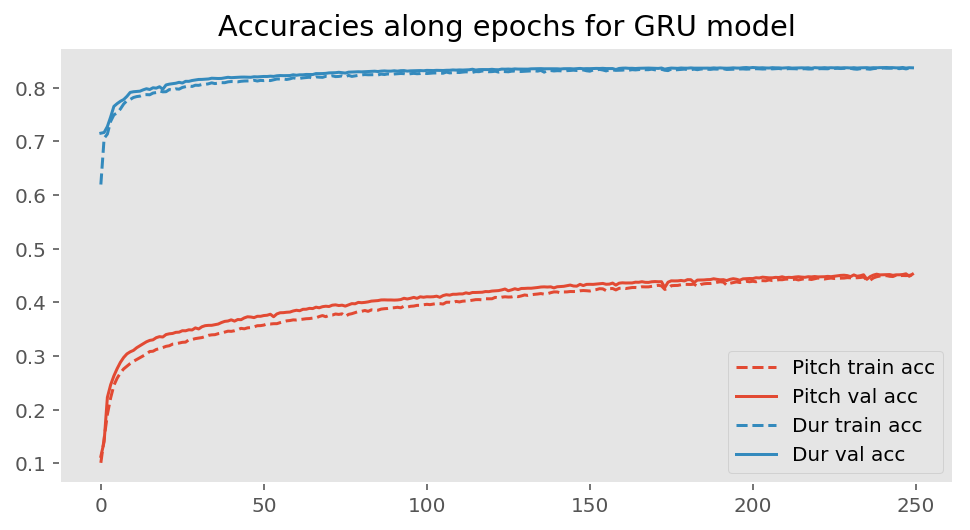

In [24]:
plotLearningCurvesFromDict(historyGRUdict,"GRU model")

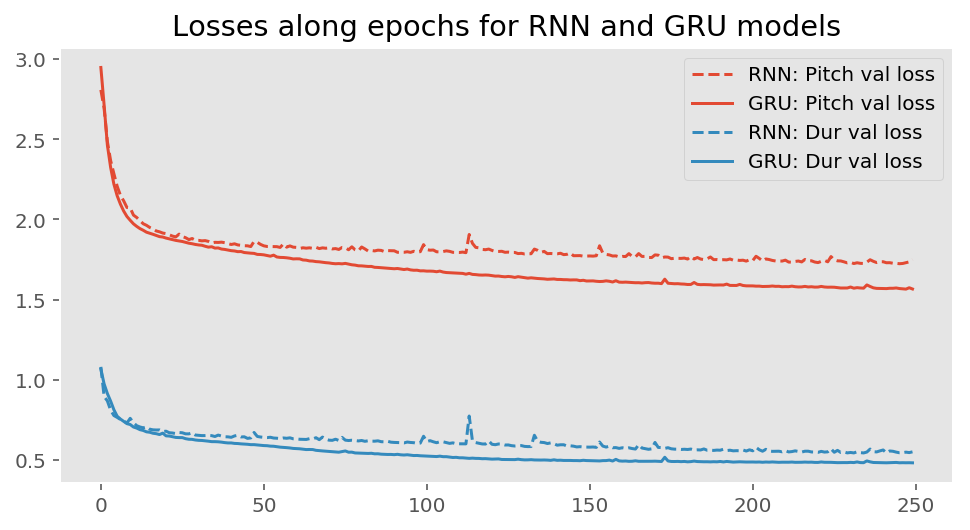

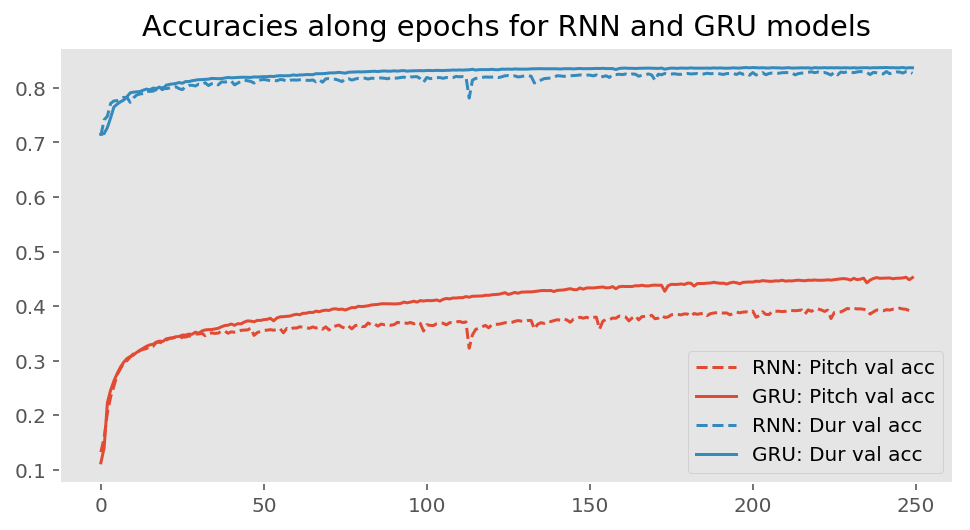

In [25]:
plotTwoLearningCurves(historyRNNdict, historyGRUdict, "RNN and GRU models")

In [26]:
print("Final validation accuracies :")
print("Pitch validation accuracy of RNN :")
print(historyRNNdict['val_YP_acc'][-1])
print("Duration validation accuracy of RNN :")
print(historyRNNdict['val_YT_acc'][-1])
print("Pitch validation accuracy of GRU :")
print(historyGRUdict['val_YP_acc'][-1])
print("Duration validation accuracy of GRU :")
print(historyGRUdict['val_YT_acc'][-1])

Final validation accuracies :
Pitch validation accuracy of RNN :
0.386232217632491
Duration validation accuracy of RNN :
0.8265404244949077
Pitch validation accuracy of GRU :
0.45233036916831443
Duration validation accuracy of GRU :
0.8366860826810201


**Question**: What are the best prediction accuracies you obtained? With which model?
    
**Answer**: 45.2% on the pitch prediction and 83.7% on the duration prediciton, both with the GRU model.

**Question**: In a few sentences, comment on the plot comparing learning curves for the two activation function.
    
**Answer**: 



## Exercise 6: Visualizing the model
### Description

1. Using the model.predict and plotMelody functions, show the outputs of your best model when fed with 4 randomly selected melodies. Report the prediction accuracies as well.
2. For the same melodies, plot the hidden state evolution accross time steps. Construct a 2 dimensional matrix with the first dimension being time and the second the concatenation of all hidden unit activations and plot it using the provided `plotMelody` function. To get the hidden states of your network, you can modify the `buildModel` function so that you have another computation graph (another model with the same layers, but the output layer) returning you the hidden states. However, other approaches are equally valid.  
3. For each hidden unit $i$ and accross the entire dataset, compute the average absolute change in activation $\Delta A_i$. Be careful not to take masked timesteps into account. Plot the histogram (50 bins) of this average for the RNN and GRU models on the same figure.

### Solution

**Question 6.1**

In [34]:
# load the model

# returns a compiled model
# identical to the previous one
print("Loading the models...")
GRUmodelbis = load_model('save/GRUmodelWithoutObig.h5')
RNNmodelbis = load_model('save/RNNmodelWithoutObig.h5')
print("Done !")

Loading the models...
Done !


In [36]:
indexes = np.random.choice(np.shape(categorical_T)[0],4,replace=False)

print("The randomly chosen samples are the musics :",indexes)

The randomly chosen samples are the musics : [746 424 978 409]


In [37]:
# GRU prediction/evaluation

print("GRU prediction")
predictionsGRU = GRUmodelbis.predict([categorical_T[indexes,0:-1],categorical_P[indexes,0:-1]], verbose=1)
print("GRU evaluation")
scoreGRU = GRUmodelbis.evaluate([categorical_T[indexes,0:-1], categorical_P[indexes,0:-1]], [shift_T[indexes,0:-1], shift_P[indexes,0:-1]], verbose=1)

# RNN prediction/evaluation

print("RNN prediction")
predictionsRNN = RNNmodelbis.predict([categorical_T[indexes,0:-1],categorical_P[indexes,0:-1]], verbose=1)
print("RNN evaluation")
scoreRNN = RNNmodelbis.evaluate([categorical_T[indexes,0:-1], categorical_P[indexes,0:-1]], [shift_T[indexes,0:-1], shift_P[indexes,0:-1]], verbose=1)

GRU prediction
4/4 [==============================] - 0s 74ms/step
GRU evaluation
4/4 [==============================] - 0s 73ms/step
RNN prediction
4/4 [==============================] - 0s 65ms/step
RNN evaluation
4/4 [==============================] - 0s 69ms/step


In [40]:
# Computing the test accuracy with the keras function model.evaluate

print("Computing the accuracy with the keras function model.evaluate")
print("GRU")
print('Test accuracy GRU (pitch):', scoreGRU[-1])
print('Test accuracy GRU (duration):', scoreGRU[-2])
print("RNN")
print('Test accuracy RNN (pitch):', scoreRNN[-1])
print('Test accuracy RNN (duration):', scoreRNN[-2])

Computing the accuracy with the keras function model.evaluate
GRU
Test accuracy GRU (pitch): 0.46196359395980835
Test accuracy GRU (duration): 0.8105112910270691
RNN
Test accuracy RNN (pitch): 0.3803594708442688
Test accuracy RNN (duration): 0.7966799139976501


In [43]:
# Computing the real output from the predictions (=probabilities)
# taking the pitch and durations with maximal probabilities as the outputs.

print("Computing the real output from the predictions (=probabilities), taking the pitch and durations with maximal probabilities as the outputs.")

# GRU

print("GRU")
output_TGRU = np.zeros((np.shape(predictionsGRU[0])[0], np.shape(predictionsGRU[0][0])[0], np.shape(predictionsGRU[0][0][0])[0]), dtype=int)
# output_T(music,note,value_duration)
print("Shape of output_T :", output_TGRU.shape)

for music in range(np.shape(output_TGRU)[0]):
    for note in range(np.shape(output_TGRU)[1]):
        best_idx = np.argmax(predictionsGRU[0][music][note]) # we choose the label with the highest probability
        output_TGRU[music][note][best_idx] = 1
        
output_PGRU = np.zeros((np.shape(predictionsGRU[1])[0], np.shape(predictionsGRU[1][0])[0], np.shape(predictionsGRU[1][0][0])[0]), dtype=int)
# output_P(music,note,value_pitch)
print("Shape of output_P :", output_PGRU.shape)

for music in range(np.shape(output_PGRU)[0]):
    for note in range(np.shape(output_PGRU)[1]):
        best_idx = np.argmax(predictionsGRU[1][music][note]) # we choose the label with the highest probability
        output_PGRU[music][note][best_idx] = 1
        
# RNN

print("RNN")
output_TRNN = np.zeros((np.shape(predictionsRNN[0])[0], np.shape(predictionsRNN[0][0])[0], np.shape(predictionsRNN[0][0][0])[0]), dtype=int)
# output_T(music,note,value_duration)
print("Shape of output_T :", output_TRNN.shape)

for music in range(np.shape(output_TRNN)[0]):
    for note in range(np.shape(output_TRNN)[1]):
        best_idx = np.argmax(predictionsRNN[0][music][note]) # we choose the label with the highest probability
        output_TRNN[music][note][best_idx] = 1
        
output_PRNN = np.zeros((np.shape(predictionsRNN[1])[0], np.shape(predictionsRNN[1][0])[0], np.shape(predictionsRNN[1][0][0])[0]), dtype=int)
# output_P(music,note,value_pitch)
print("Shape of output_P :", output_P.shape)

for music in range(np.shape(output_PRNN)[0]):
    for note in range(np.shape(output_PRNN)[1]):
        best_idx = np.argmax(predictionsRNN[1][music][note]) # we choose the label with the highest probability
        output_PRNN[music][note][best_idx] = 1
        
        
print("Done !")

Computing the real output from the predictions (=probabilities), taking the pitch and durations with maximal probabilities as the outputs.
GRU
Shape of output_T : (4, 390, 19)
Shape of output_P : (4, 390, 50)
RNN
Shape of output_T : (4, 390, 19)
Shape of output_P : (4, 390, 50)
Done !


In [58]:
# Manually computing the accuracy by comparing the output of our model (computed in the cell above) with the true output
print("Manually computing the accuracy by comparing the output of our model (computed in the cell above) with the true output")
print('\n')

# GRU

print("GRU")
print('\n')

# Accuracy for durations

print("Durations (GRU)")
print('\n')

nb_good_predictionsGRU = 0
nb_total_samplesGRU = 0

for music in range(output_TGRU.shape[0]):
    length,values = np.nonzero(shift_T[indexes][music])
    print("Length of music",music,":",length[-1],"notes")
    local_nb_good_predGRU = 0
    for note in range(length[-1]):
        nb_total_samplesGRU = nb_total_samplesGRU + 1
        if(np.array_equal(output_TGRU[music][note], shift_T[indexes][music][note])):
            local_nb_good_predGRU = local_nb_good_predGRU + 1
            nb_good_predictionsGRU = nb_good_predictionsGRU + 1
    local_accGRU = local_nb_good_predGRU/length[-1]
    print("Accuracy for music", music,":",local_accGRU)

print('\n')
print("Over ", nb_total_samplesGRU, " durations to predict, there were ", nb_good_predictionsGRU, " good predictions.")
print("Total accuracy durations : ",nb_good_predictionsGRU/nb_total_samplesGRU)

# Accuracy for pitches

print('\n')
print("Pitches (GRU)")
print('\n')

nb_good_predictionsGRU = 0
nb_total_samplesGRU = 0

for music in range(output_PGRU.shape[0]):
    length,values = np.nonzero(shift_P[indexes][music])
    print("Length of music",music,":",length[-1],"notes")
    local_nb_good_predGRU = 0
    for note in range(length[-1]):
        nb_total_samplesGRU = nb_total_samplesGRU + 1
        if(np.array_equal(output_PGRU[music][note], shift_P[indexes][music][note])):
            local_nb_good_predGRU = local_nb_good_predGRU + 1
            nb_good_predictionsGRU = nb_good_predictionsGRU + 1
    local_accGRU = local_nb_good_predGRU/length[-1]
    print("Accuracy for music", music,":",local_accGRU)

print('\n')
print("Over ", nb_total_samplesGRU, " pitches to predict, there were ", nb_good_predictionsGRU, " good predictions.")
print("Total accuracy pitches : ",nb_good_predictionsGRU/nb_total_samplesGRU)



# RNN

print('\n')
print("RNN")
print('\n')

# Accuracy for durations

print("Durations (RNN)")
print('\n')

nb_good_predictionsRNN = 0
nb_total_samplesRNN = 0

for music in range(output_TRNN.shape[0]):
    length,values = np.nonzero(shift_T[indexes][music])
    print("Length of music",music,":",length[-1],"notes")
    local_nb_good_predRNN = 0
    for note in range(length[-1]):
        nb_total_samplesRNN = nb_total_samplesRNN + 1
        if(np.array_equal(output_TRNN[music][note], shift_T[indexes][music][note])):
            local_nb_good_predRNN = local_nb_good_predRNN + 1
            nb_good_predictionsRNN = nb_good_predictionsRNN + 1
    local_accRNN = local_nb_good_predRNN/length[-1]
    print("Accuracy for music", music,":",local_accRNN)

print('\n')
print("Over ", nb_total_samplesRNN, " durations to predict, there were ", nb_good_predictionsRNN, " good predictions.")
print("Total accuracy durations : ",nb_good_predictionsRNN/nb_total_samplesRNN)


# Accuracy for pitches

print('\n')
print("Pitches (RNN)")
print('\n')

nb_good_predictionsRNN = 0
nb_total_samplesRNN = 0

for music in range(output_PRNN.shape[0]):
    length,values = np.nonzero(shift_P[indexes][music])
    print("Length of music",music,":",length[-1],"notes")
    local_nb_good_predRNN = 0
    for note in range(length[-1]):
        nb_total_samplesRNN = nb_total_samplesRNN + 1
        if(np.array_equal(output_PRNN[music][note], shift_P[indexes][music][note])):
            local_nb_good_predRNN = local_nb_good_predRNN + 1
            nb_good_predictionsRNN = nb_good_predictionsRNN + 1
    local_accRNN = local_nb_good_predRNN/length[-1]
    print("Accuracy for music", music,":",local_accRNN)

print('\n')
print("Over ", nb_total_samplesRNN, " pitches to predict, there were ", nb_good_predictionsRNN, " good predictions.")
print("Total accuracy pitches : ",nb_good_predictionsRNN/nb_total_samplesRNN)


Manually computing the accuracy by comparing the output of our model (computed in the cell above) with the true output


GRU


Durations (GRU)


Length of music 0 : 164 notes
Accuracy for music 0 : 0.8719512195121951
Length of music 1 : 182 notes
Accuracy for music 1 : 0.9615384615384616
Length of music 2 : 119 notes
Accuracy for music 2 : 0.5798319327731093
Length of music 3 : 250 notes
Accuracy for music 3 : 0.792


Over  715  durations to predict, there were  585  good predictions.
Total accuracy durations :  0.8181818181818182


Pitches (GRU)


Length of music 0 : 164 notes
Accuracy for music 0 : 0.45121951219512196
Length of music 1 : 182 notes
Accuracy for music 1 : 0.489010989010989
Length of music 2 : 119 notes
Accuracy for music 2 : 0.5714285714285714
Length of music 3 : 250 notes
Accuracy for music 3 : 0.408


Over  715  pitches to predict, there were  333  good predictions.
Total accuracy pitches :  0.46573426573426574


RNN


Durations (RNN)


Length of music 0 : 164 notes


GRU music prediction


Music 0


Music # 0  prediction (GRU)


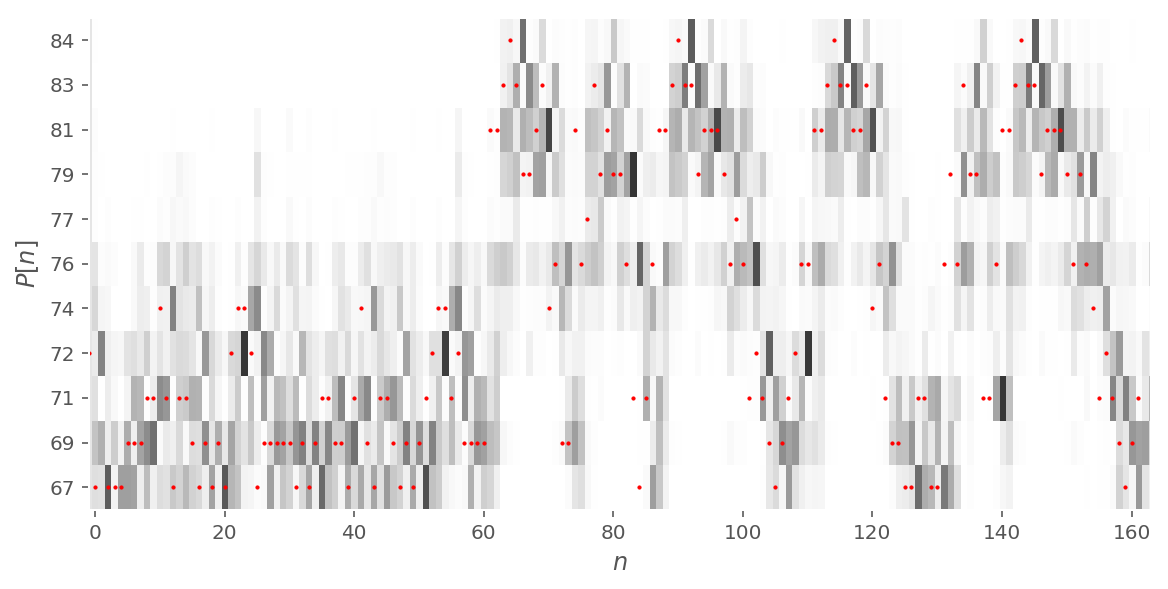

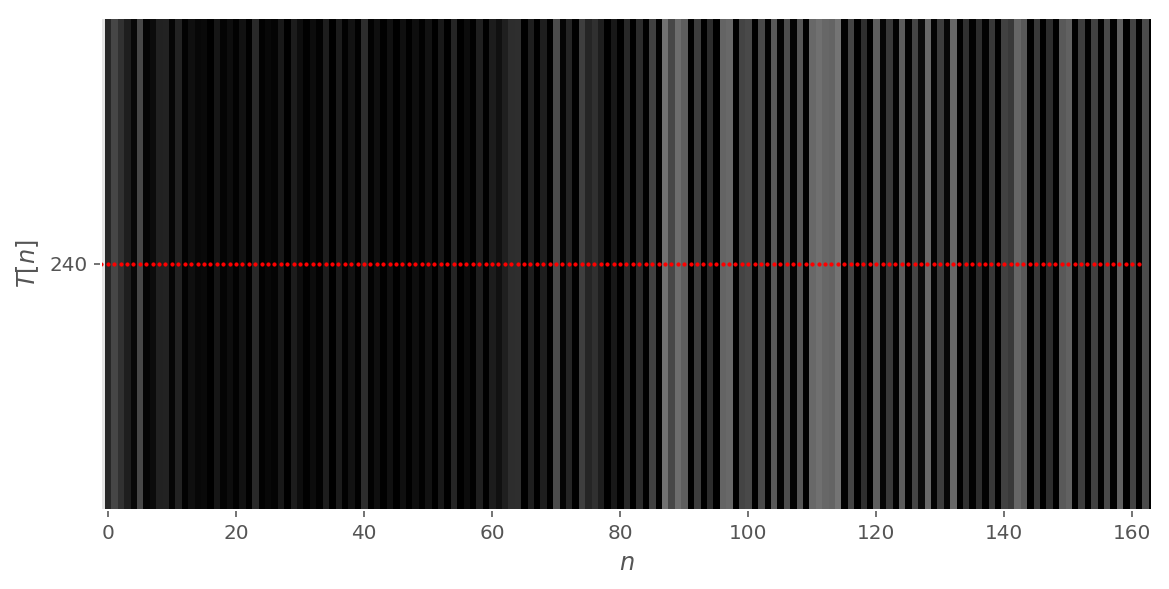

Original music (# 0 )


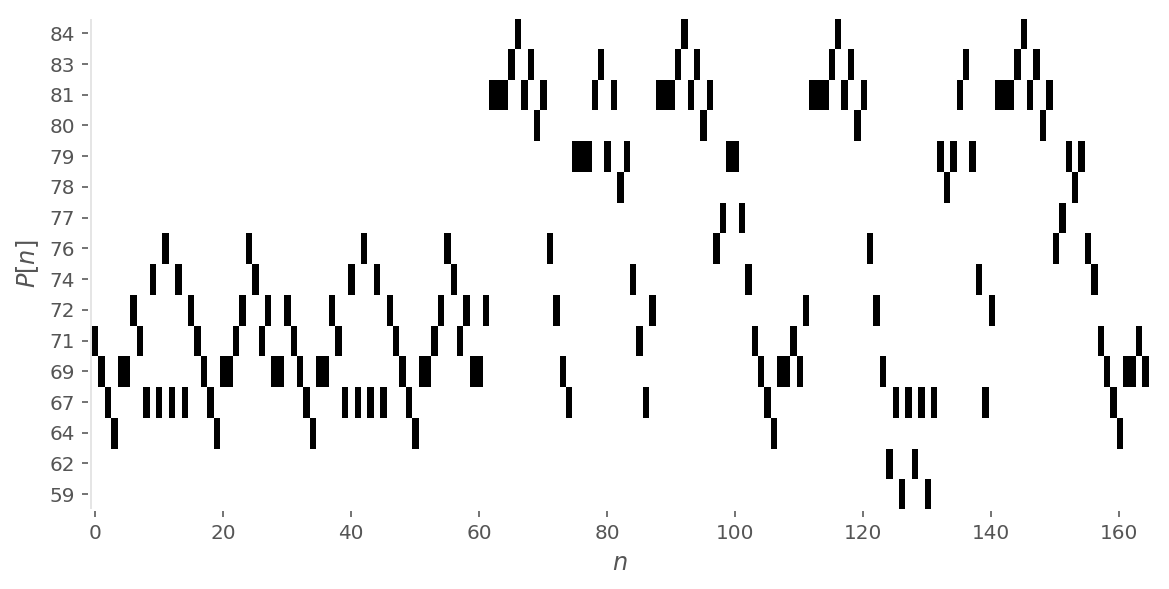

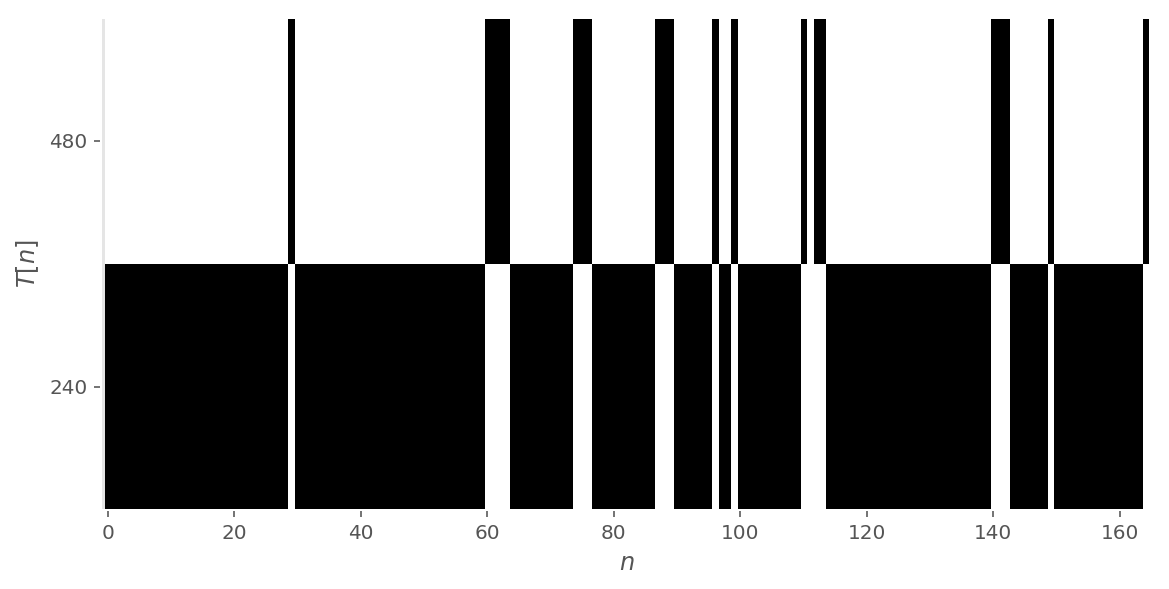

Music 1


Music # 1  prediction (GRU)


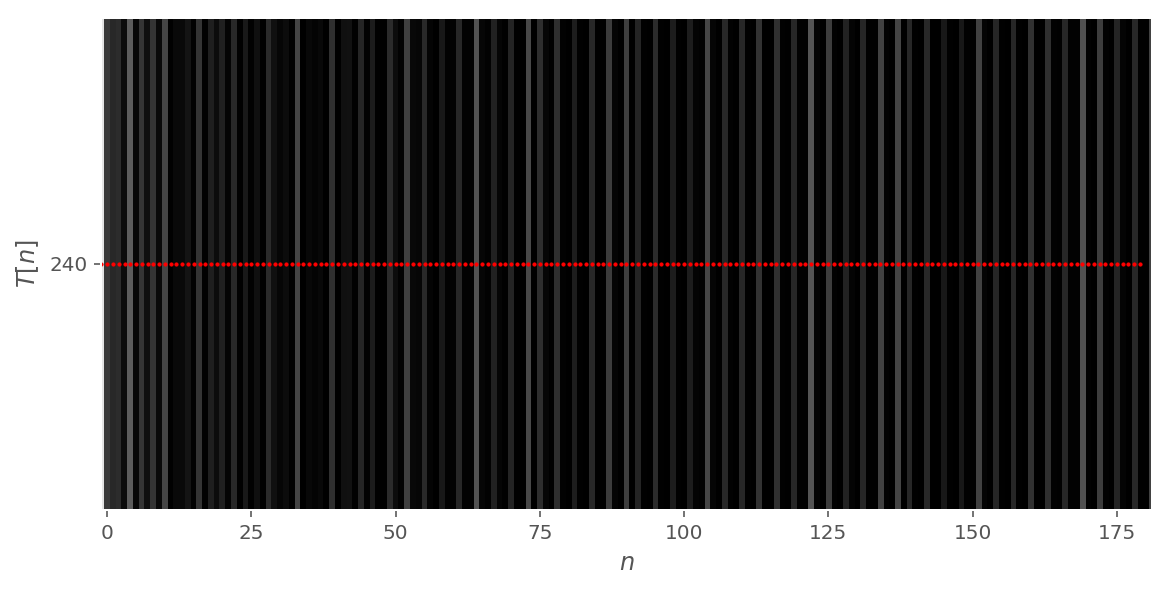

Original music (# 1 )


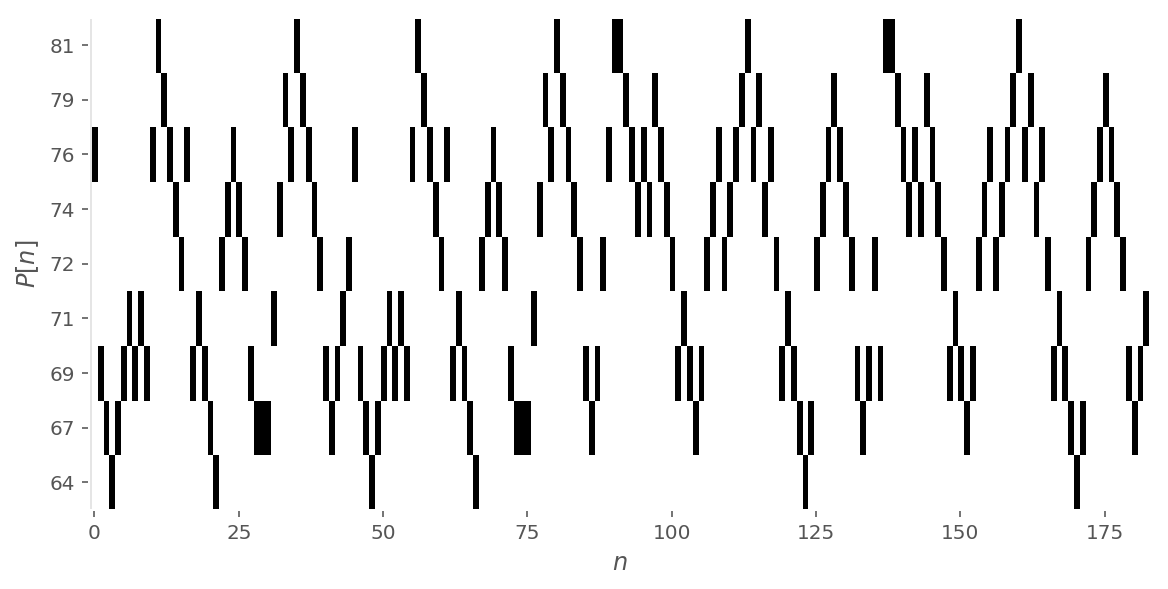

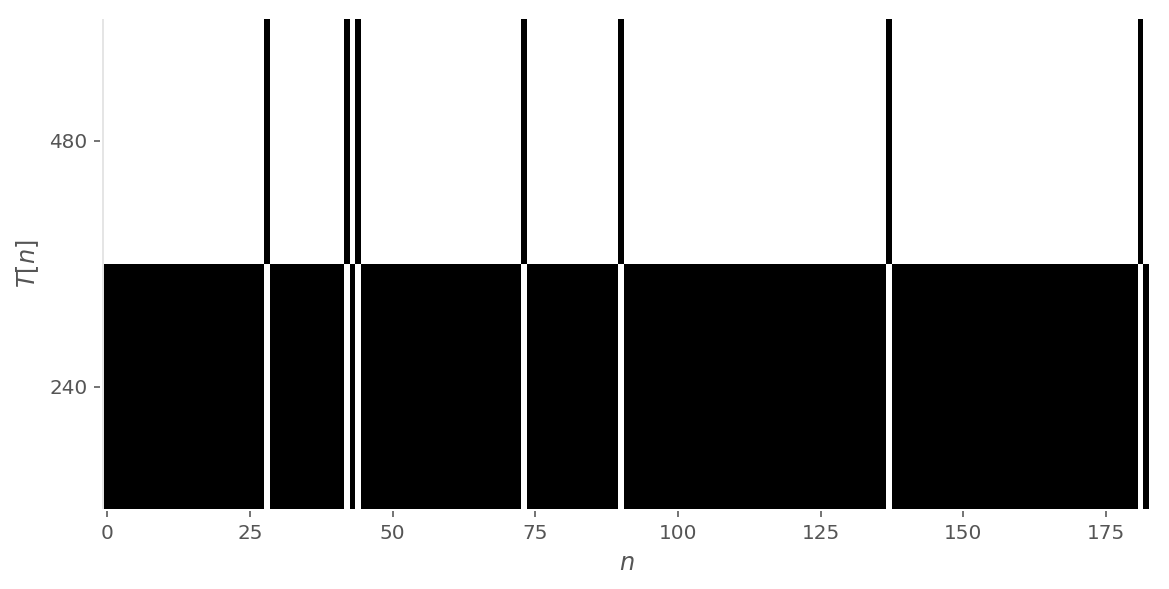

Music 2


Music # 2  prediction (GRU)


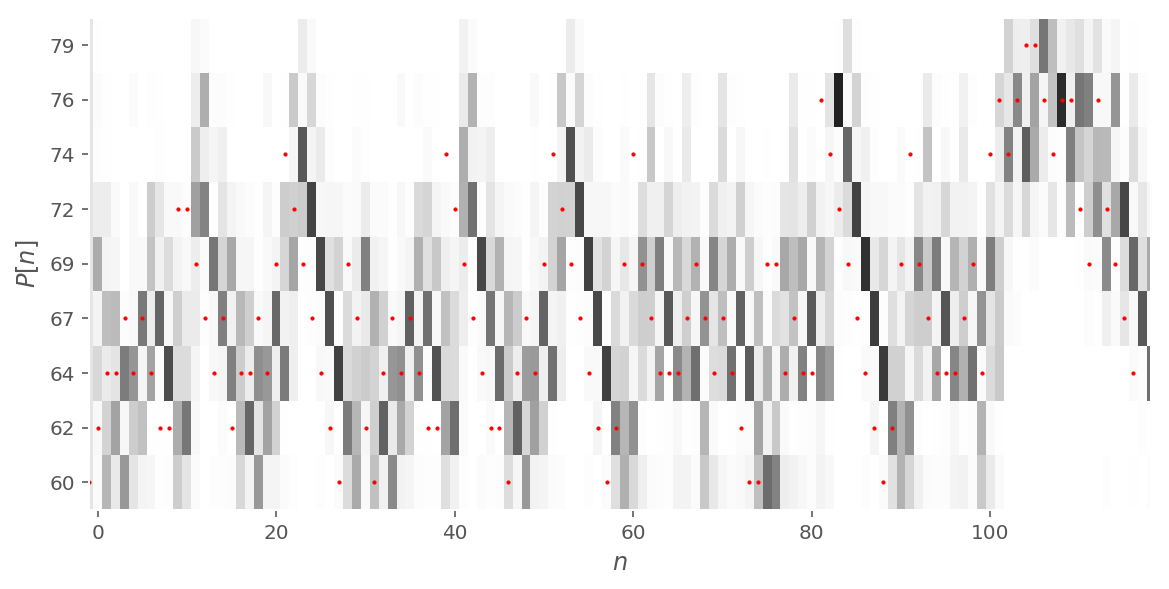

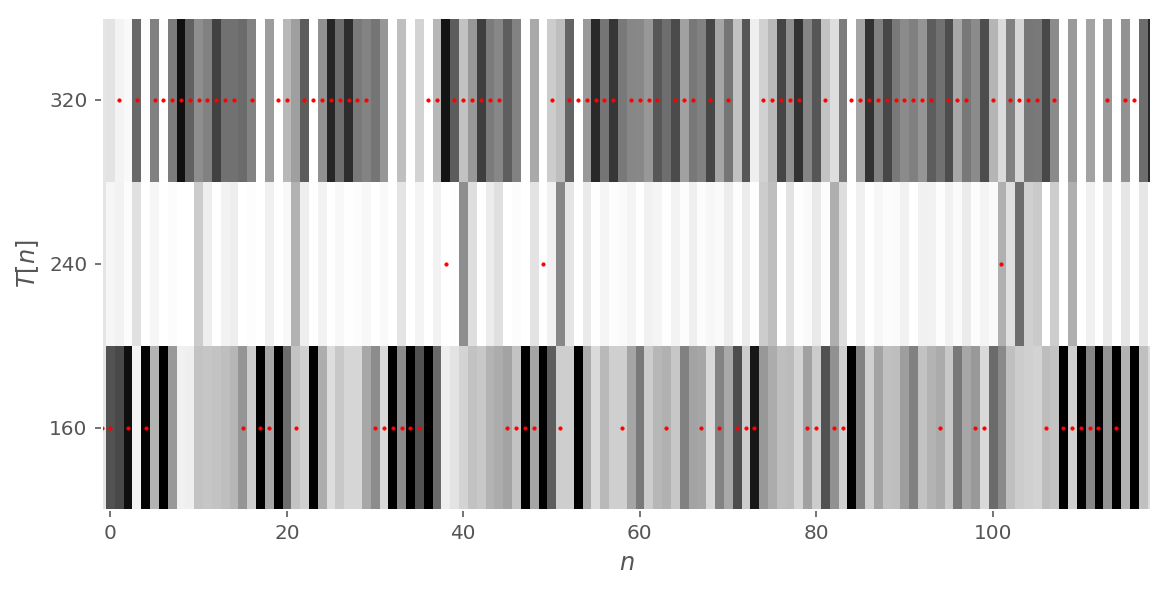

Original music (# 2 )


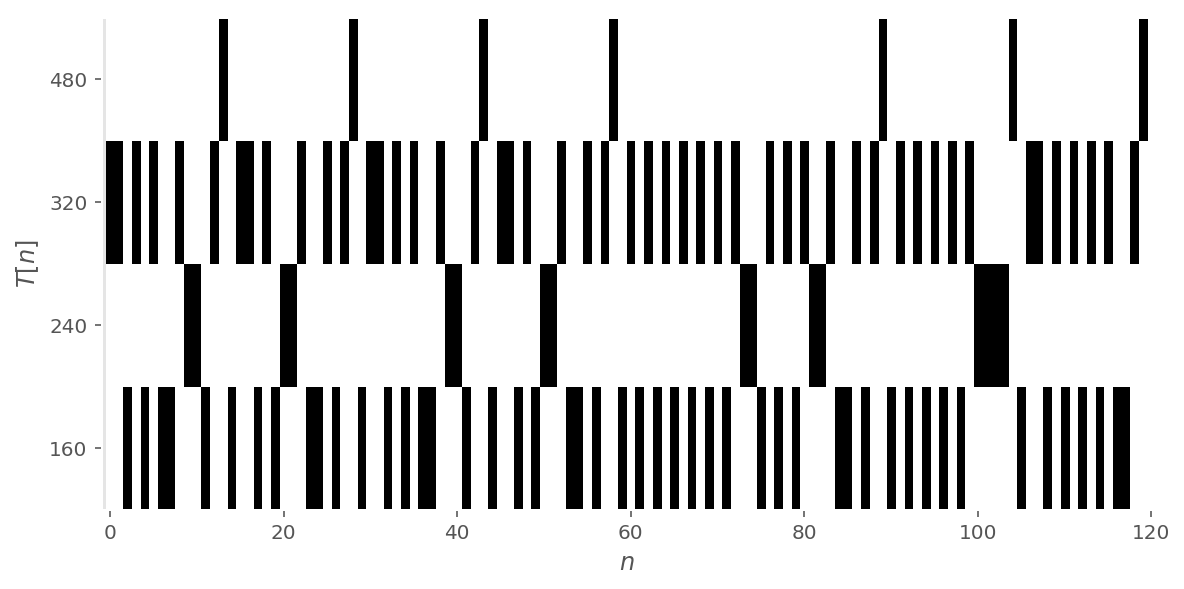

Music 3


Music # 3  prediction (GRU)


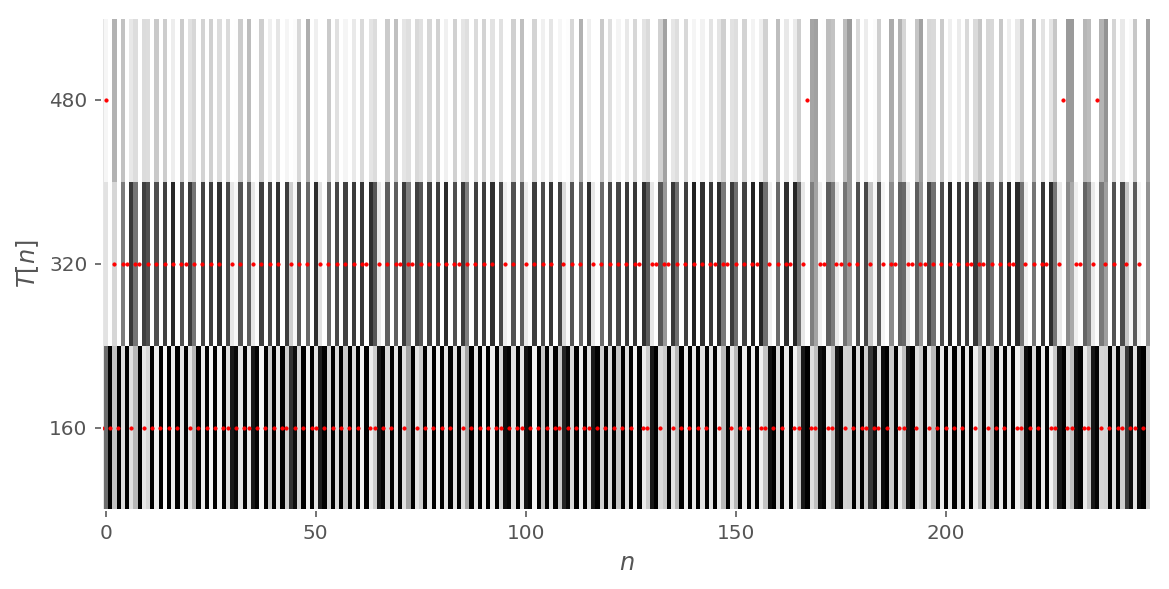

Original music (# 3 )


In [65]:
print("GRU music prediction")
print('\n')

for music in range(4):

    print("Music", music)
    print('\n')
    
    length,values = np.nonzero(shift_P[indexes][music])
    end = length[-1]

    print("Music #",music," prediction (GRU)")
    plotMelody(P=output_PGRU[music][1:end], T=output_TGRU[music][1:end],  dictionaries=dictionaries, PrP=predictionsGRU[1][music][0:end], PrT=predictionsGRU[0][music][0:end])

    print("Original music (#", music,")")
    plotMelody(shift_P[indexes][music], shift_T[indexes][music],  dictionaries)

RNN music prediction


Music 0


Music # 0  prediction (RNN)


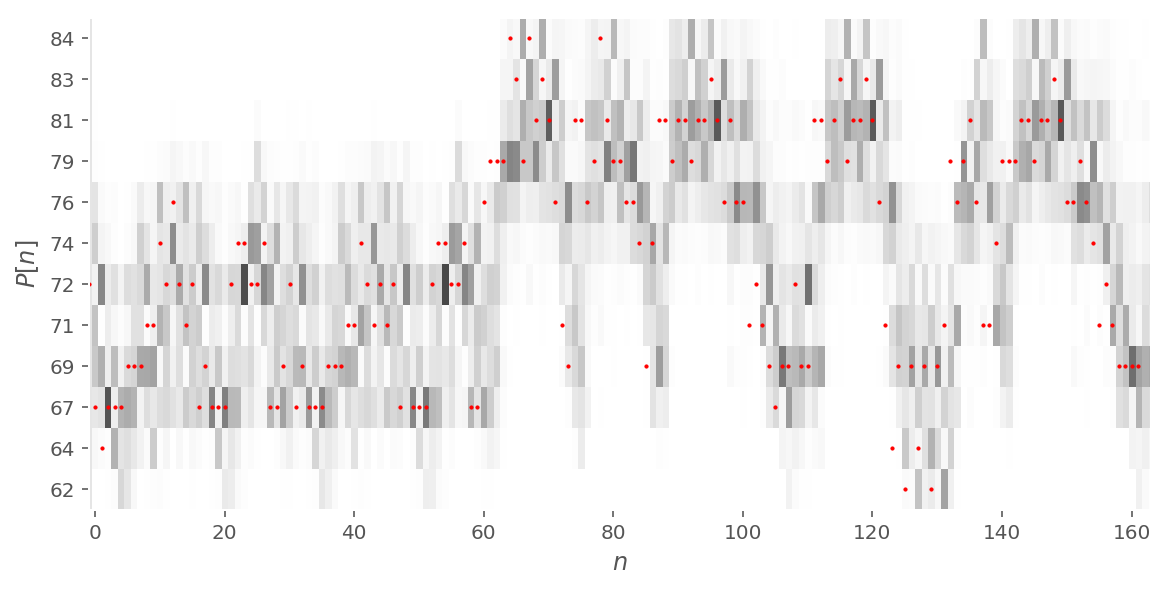

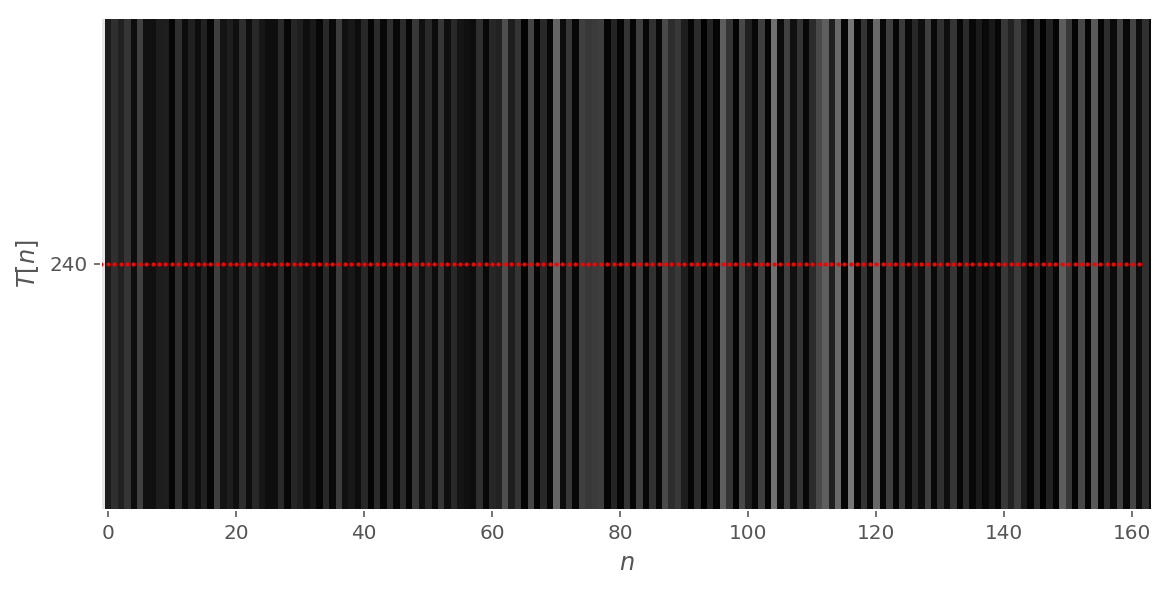

Original music (# 0 )


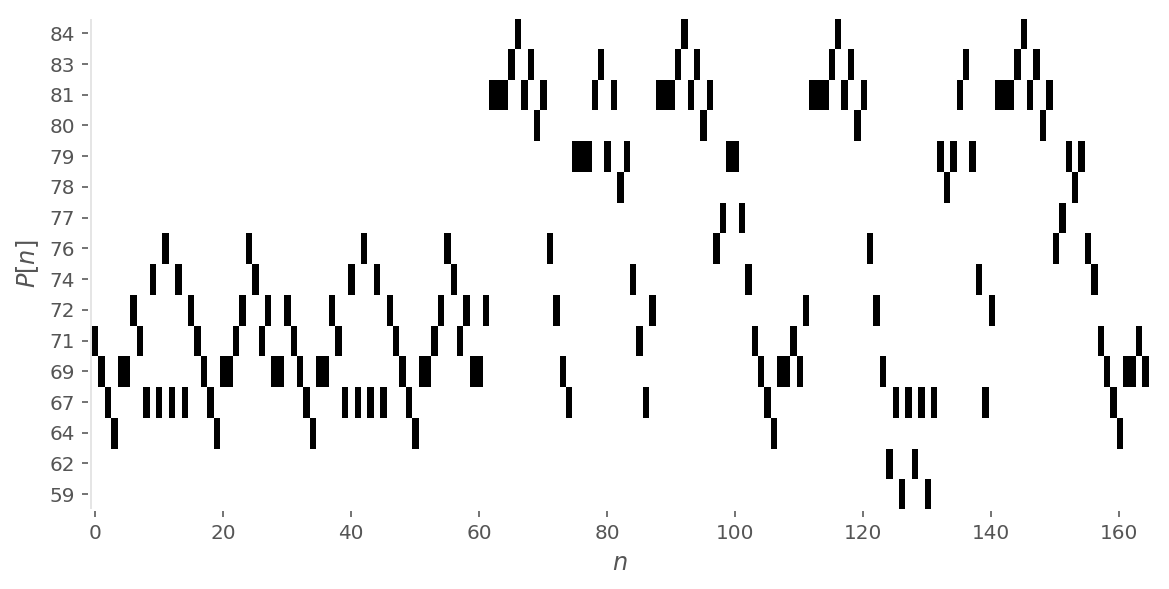

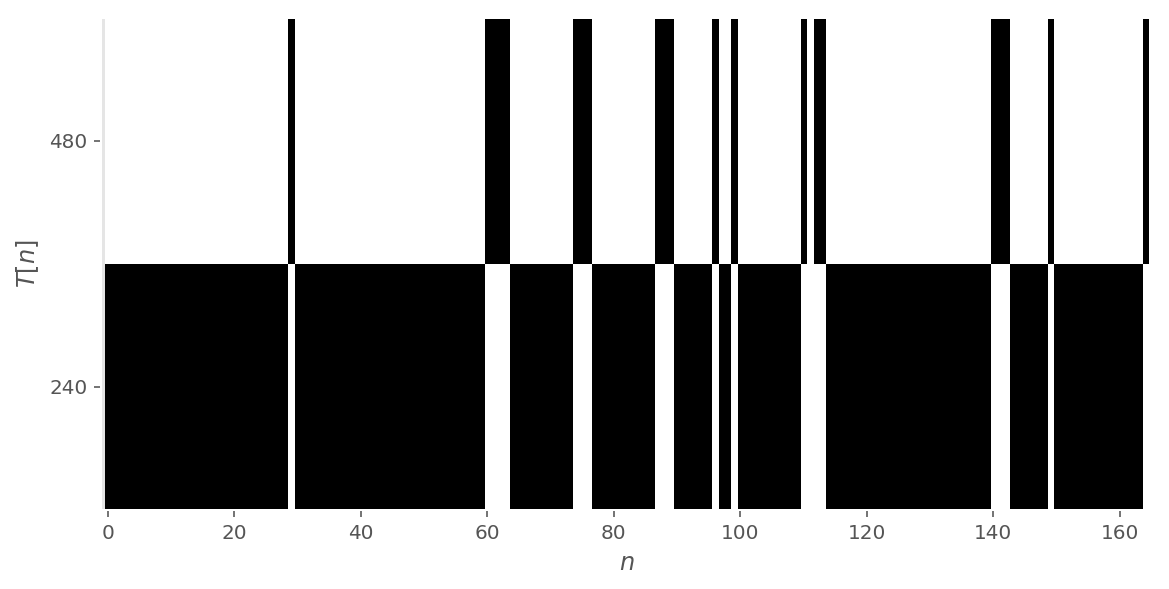

Music 1


Music # 1  prediction (RNN)


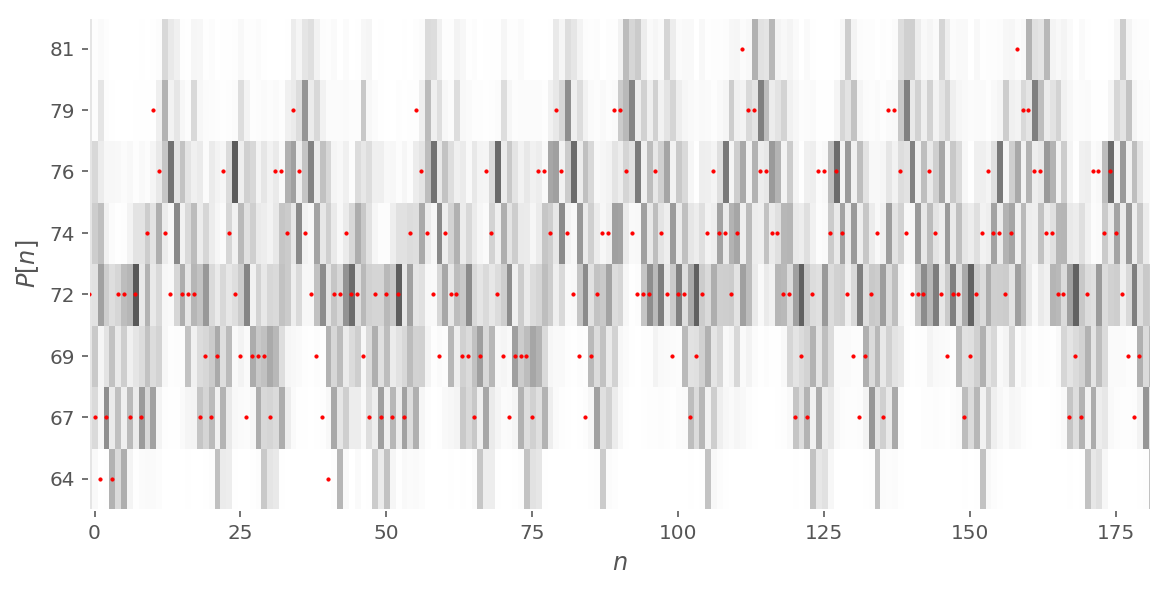

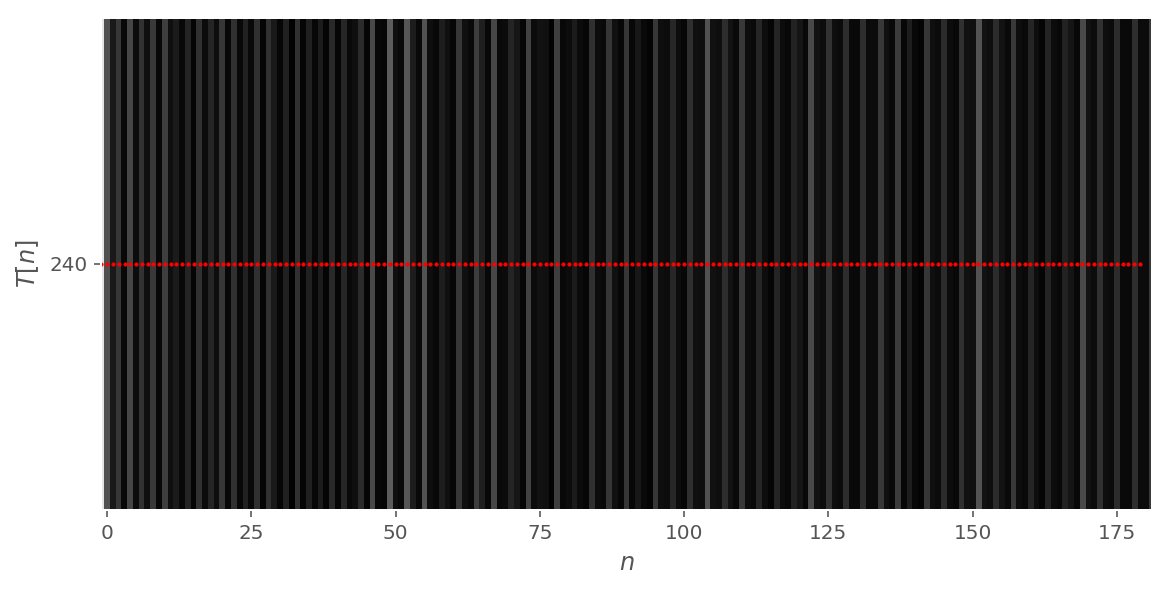

Original music (# 1 )


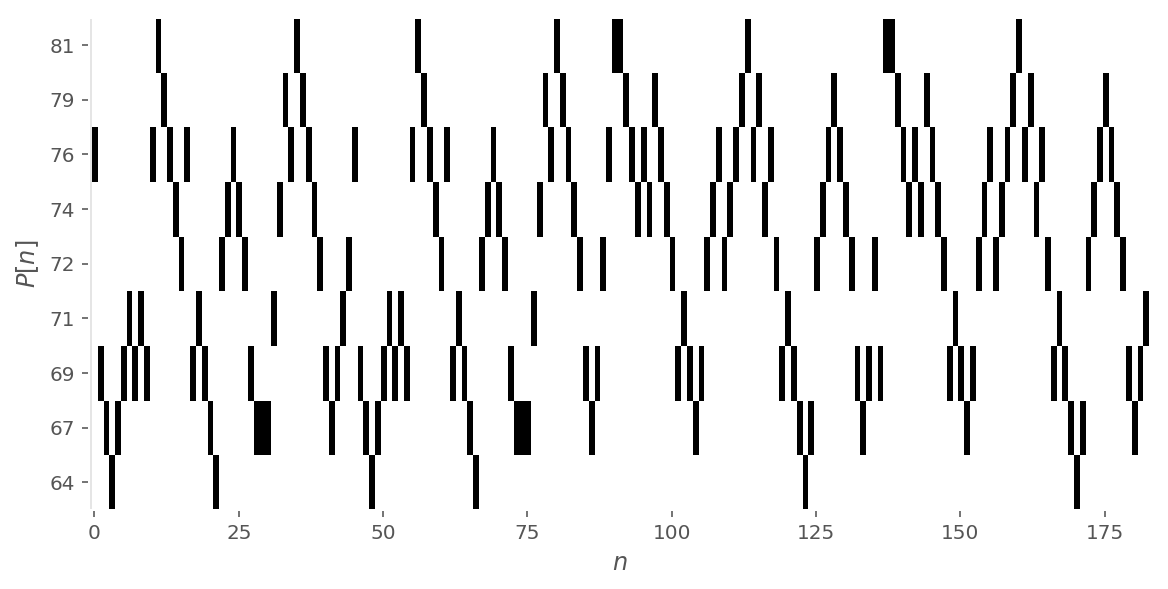

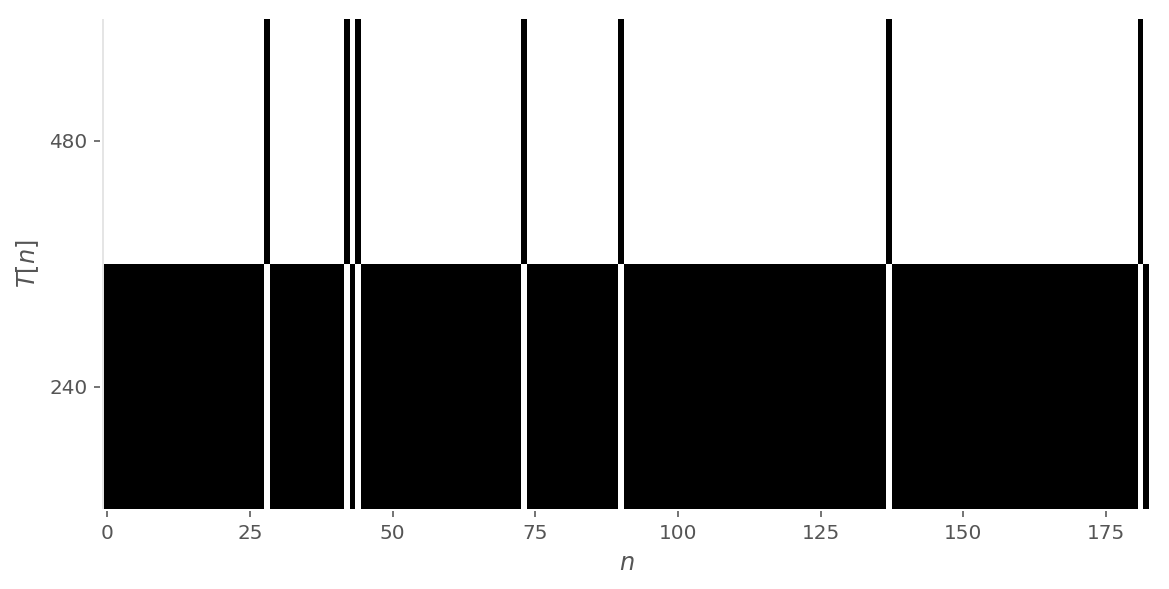

Music 2


Music # 2  prediction (RNN)


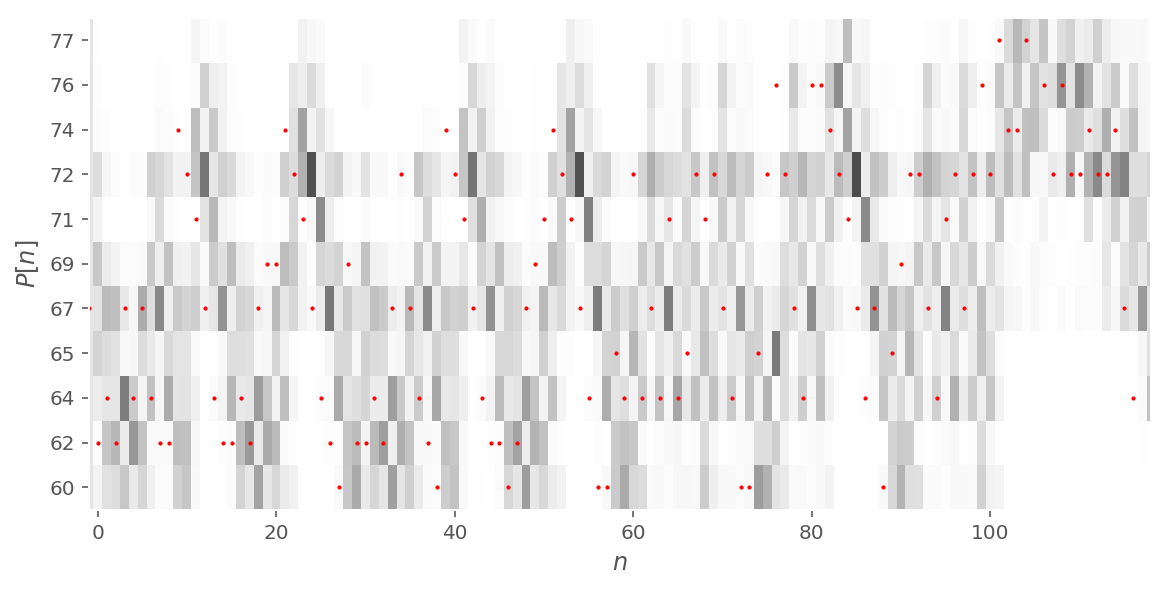

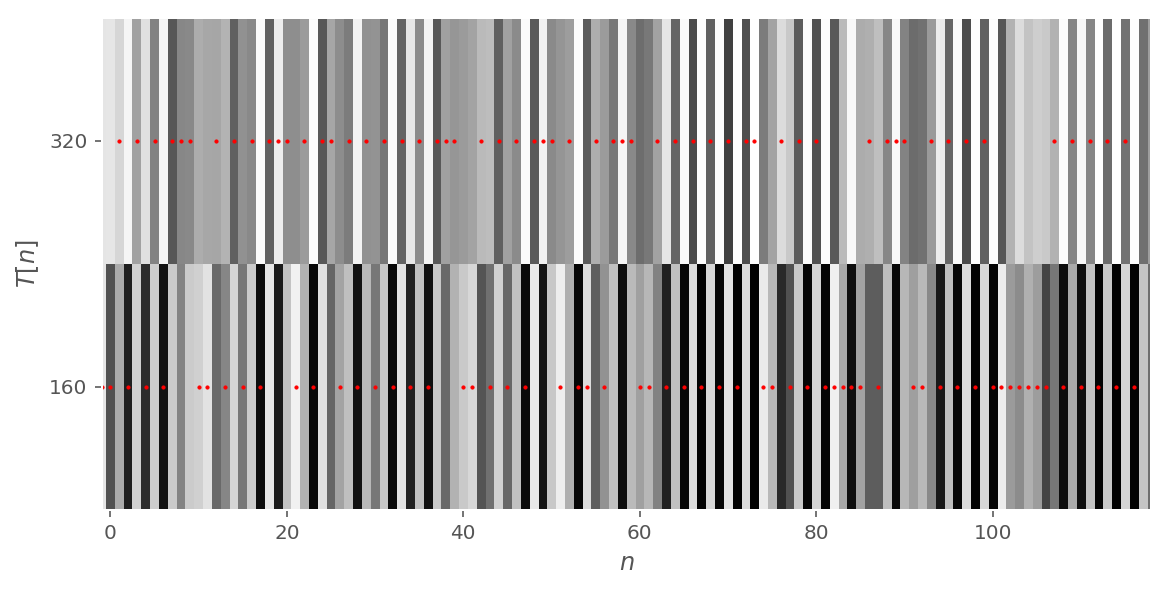

Original music (# 2 )


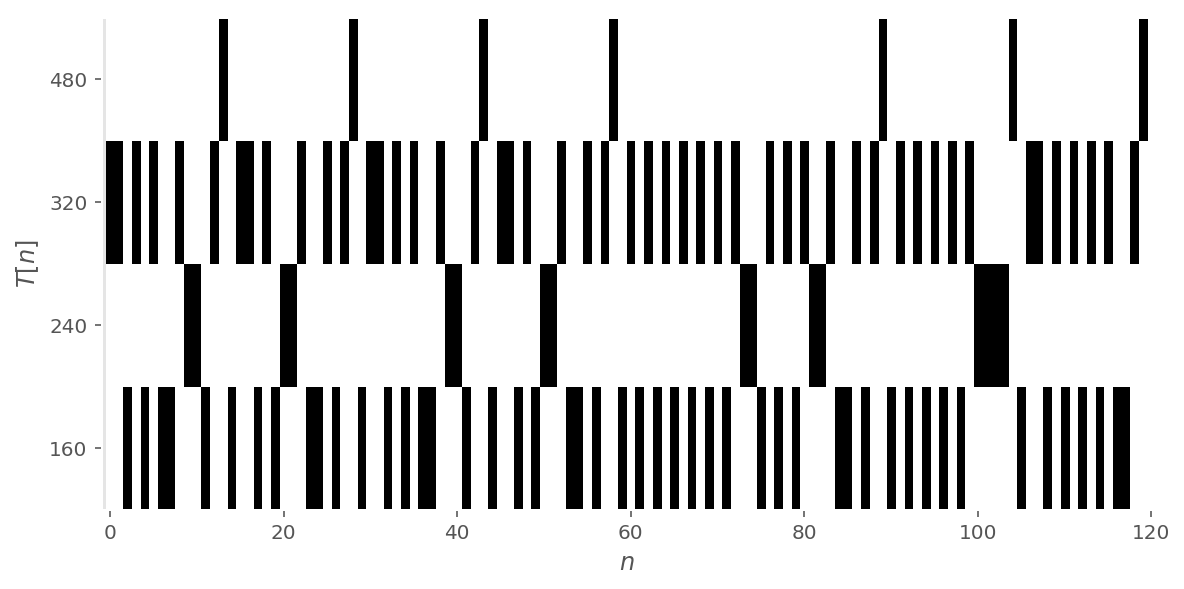

Music 3


Music # 3  prediction (RNN)


Original music (# 3 )


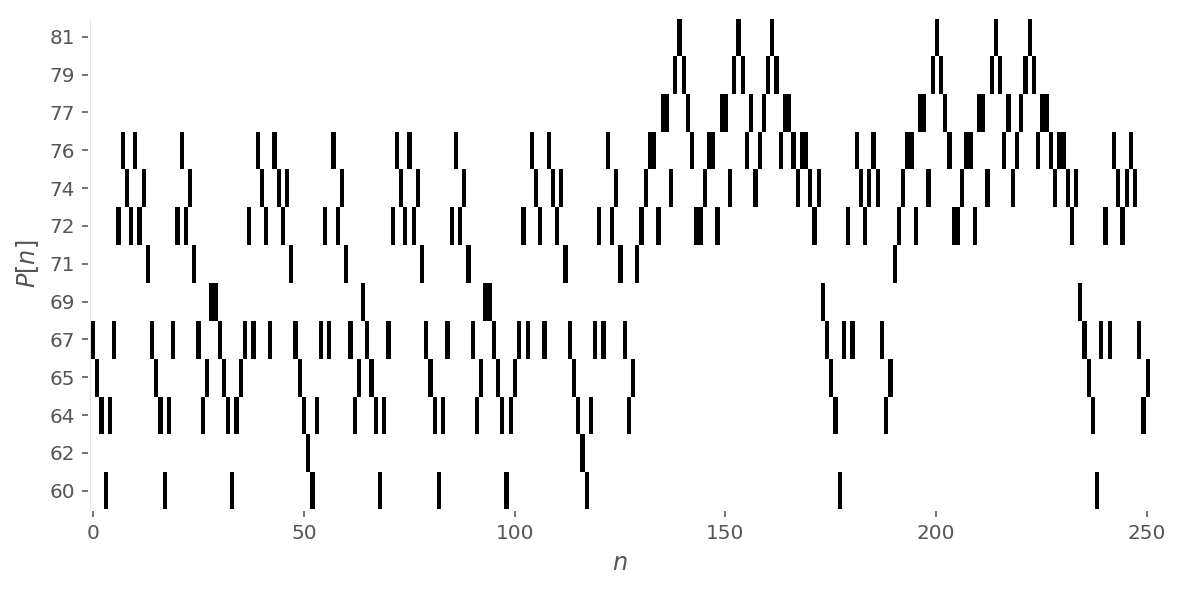

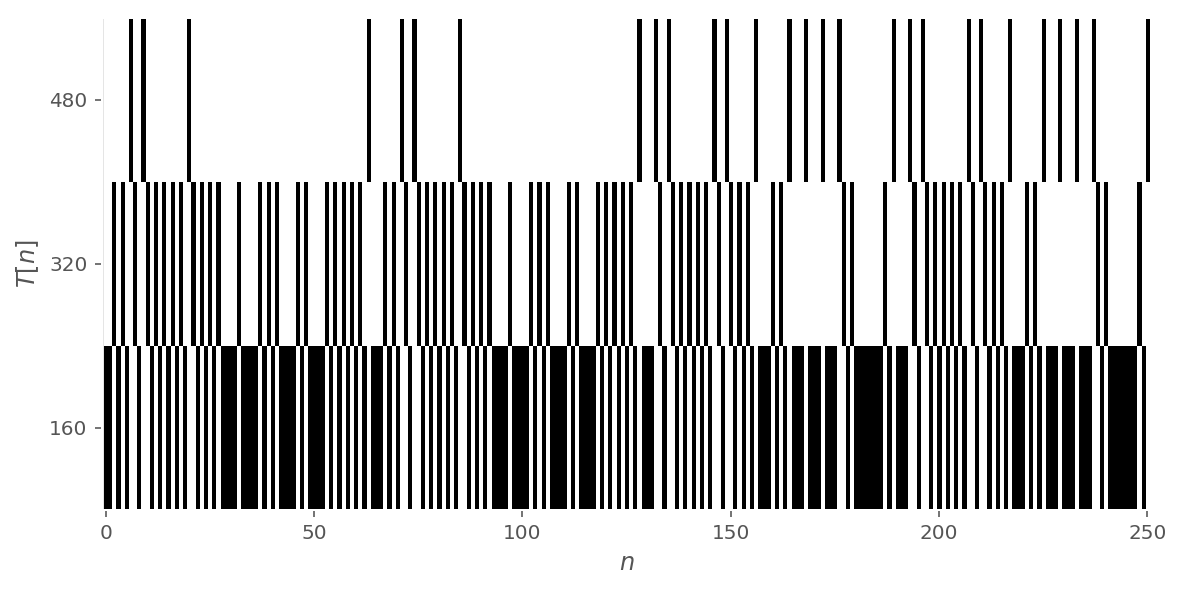

In [66]:
print("RNN music prediction")
print('\n')

for music in range(4):

    print("Music", music)
    print('\n')
    
    length,values = np.nonzero(shift_P[indexes][music])
    end = length[-1]

    print("Music #",music," prediction (RNN)")
    plotMelody(P=output_PRNN[music][1:end], T=output_TRNN[music][1:end],  dictionaries=dictionaries, PrP=predictionsRNN[1][music][0:end], PrT=predictionsRNN[0][music][0:end])

    print("Original music (#", music,")")
    plotMelody(shift_P[indexes][music], shift_T[indexes][music],  dictionaries)

**Question 6.2**

In [68]:
# Saving the weights of our trained networks

# GRU

print("Saving GRU weights...")
print('\n')


weightsGRU =[]
compteur = 0

for layer in GRUmodelbis.layers:
    print(layer.name)
    weightsGRU.append(layer.get_weights()) # list of numpy arrays

# RNN

print('\n')
print("Saving RNN weights...")
print('\n')

weightsRNN =[]
compteur = 0

for layer in RNNmodelbis.layers:
    print(layer.name)
    weightsRNN.append(layer.get_weights()) # list of numpy arrays

Saving GRU weights...


XT
XP
MT
MP
MergeX
GRU1
YT
YP


Saving RNN weights...


XT
XP
MT
MP
MergeX
RNN1
YT
YP


In [69]:
def buildModelHidden(dictionaries, batch_length, dropout=0.2, activation='GRU', Hsize=128):
    X = dict()
    H = dict()
    M = dict()
    
    X['T'] = Input(shape=(batch_length, len(dictionaries['T'])), name="XT")
    X['P'] = Input(shape=(batch_length, len(dictionaries['P'])), name="XP")
    
    M['T'] = Masking(mask_value=0., name="MT")(X['T'])
    M['P'] = Masking(mask_value=0., name="MP")(X['P'])
    
    H['1'] = Concatenate(name="MergeX")([M['T'], M['P']])
    if activation == 'GRU':
        gru, state = GRU(128, return_state = True, return_sequences= True, dropout=dropout, name = "GRU1")(H['1'])
        model = Model(inputs = [X['T'], X['P']], outputs = [gru])
        #Your hidden layer(s) architecture with GRU
        
    elif activation == 'LSTM':
        print("LSTM not defined")
        #Your hidden layer(s) architecture with LSTM (For your own curiosity, not required for the project)
        
    elif activation == 'RNN':
        #Your hidden layer(s) architecture with SimpleRNN
        SRNN, state = SimpleRNN(128, return_state = True, return_sequences= True, dropout=dropout, name = "RNN1")(H['1'])
        model = Model(inputs = [X['T'], X['P']], outputs = [SRNN])
    
    opt = Adam()
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=opt,
        metrics=['acc'])
    
    
    return model

RNNmodelHidden = buildModelHidden(dictionaries,
                      batch_length= 390,#Put here the number of notes (timesteps) you have in your Zero-padded matrices
                      activation='RNN')
GRUmodelHidden = buildModelHidden(dictionaries,
                     batch_length = 390,
                     activation ='GRU')
print("Simple RNN model (without output layers), to get the hidden states \n")
RNNmodelHidden.summary()
print("\n GRU model (without output layers), to get the hidden states \n")
GRUmodelHidden.summary()

Simple RNN model (without output layers), to get the hidden states 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
XT (InputLayer)                 (None, 390, 19)      0                                            
__________________________________________________________________________________________________
XP (InputLayer)                 (None, 390, 50)      0                                            
__________________________________________________________________________________________________
MT (Masking)                    (None, 390, 19)      0           XT[0][0]                         
__________________________________________________________________________________________________
MP (Masking)                    (None, 390, 50)      0           XP[0][0]                         
________________________________________

In [71]:
# Setting the weights of our new models, using the saved weights

# GRU

print("Setting the weights of our new GRU (without output layers)")
print('\n')

compteur = 0

for layer in GRUmodelHidden.layers:
    print(layer.name)
    layer.set_weights(weightsGRU[compteur]) # list of numpy arrays
    compteur = compteur + 1

# RNN

print('\n')
print("Setting the weights of our new RNN (without output layers)")
print('\n')

compteur = 0

for layer in RNNmodelHidden.layers:
    print(layer.name)
    layer.set_weights(weightsRNN[compteur]) # list of numpy arrays
    compteur = compteur + 1

Setting the weights of our new GRU (without output layers)


XT
XP
MT
MP
MergeX
GRU1


Setting the weights of our new RNN (without output layers)


XT
XP
MT
MP
MergeX
RNN1


In [73]:
# Computing the predictions of our new models (without output layers)

print("Computing the predictions for our 4 selected music...")
print("new GRU (without output layers)")
predictionsHiddenGRU = GRUmodelHidden.predict([categorical_T[indexes,0:-1],categorical_P[indexes,0:-1]], verbose=1)
print("new RNN (without output layers)")
predictionsHiddenRNN = RNNmodelHidden.predict([categorical_T[indexes,0:-1],categorical_P[indexes,0:-1]], verbose=1)

Computing the predictions...
new GRU (without output layers)
4/4 [==============================] - 0s 14ms/step
new RNN (without output layers)
4/4 [==============================] - 0s 9ms/step


GRU : Plotting the output of our model and the hidden states...


Music # 0 (GRU)


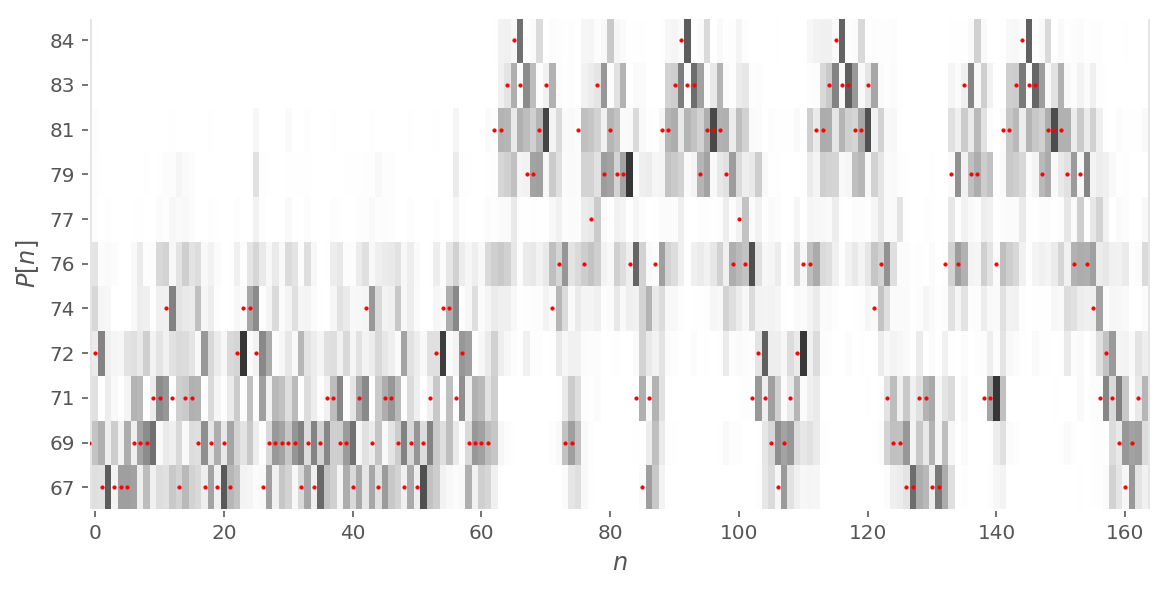

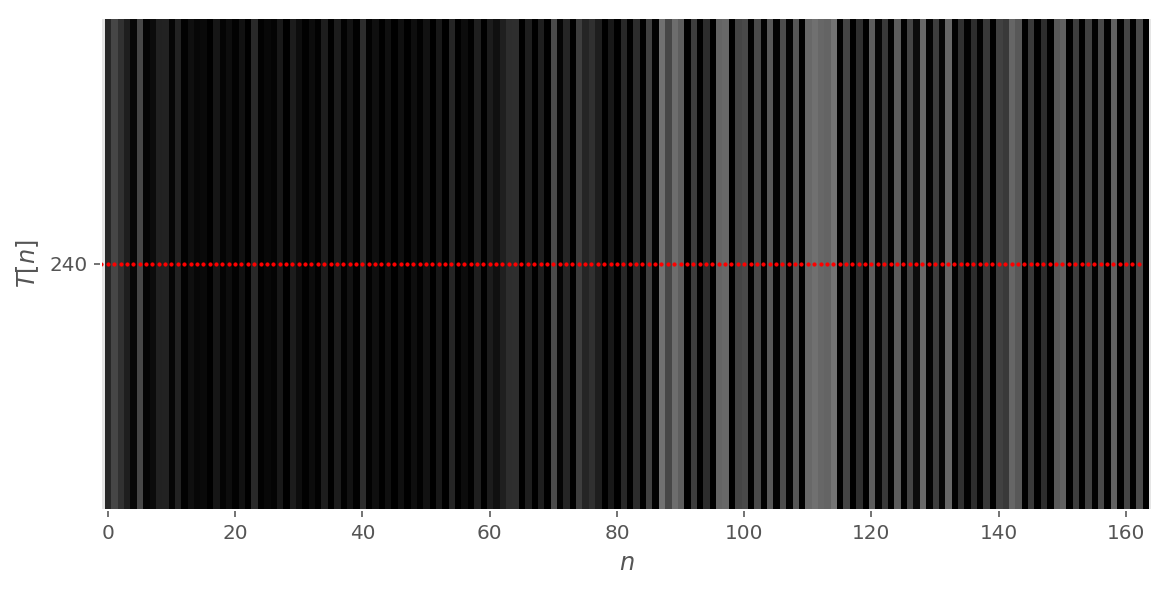

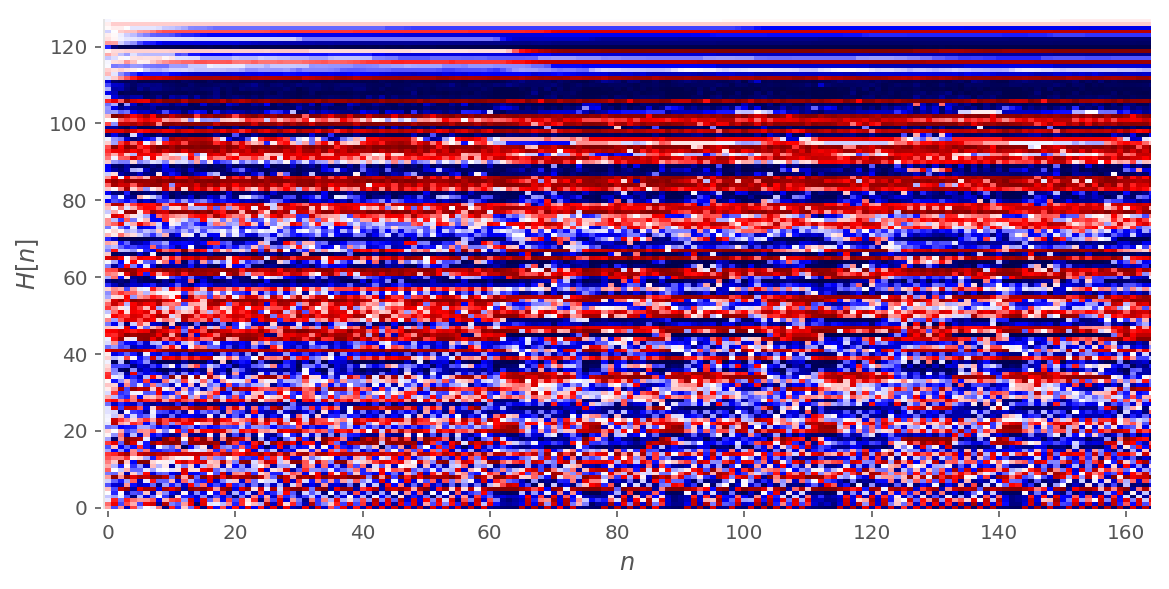

Music # 1 (GRU)


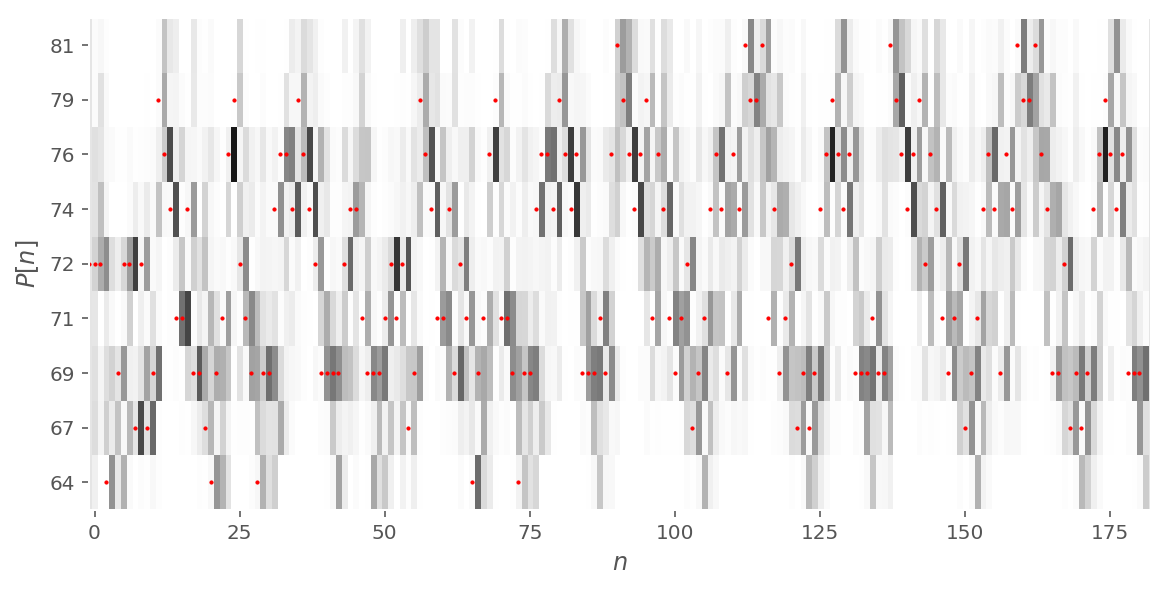

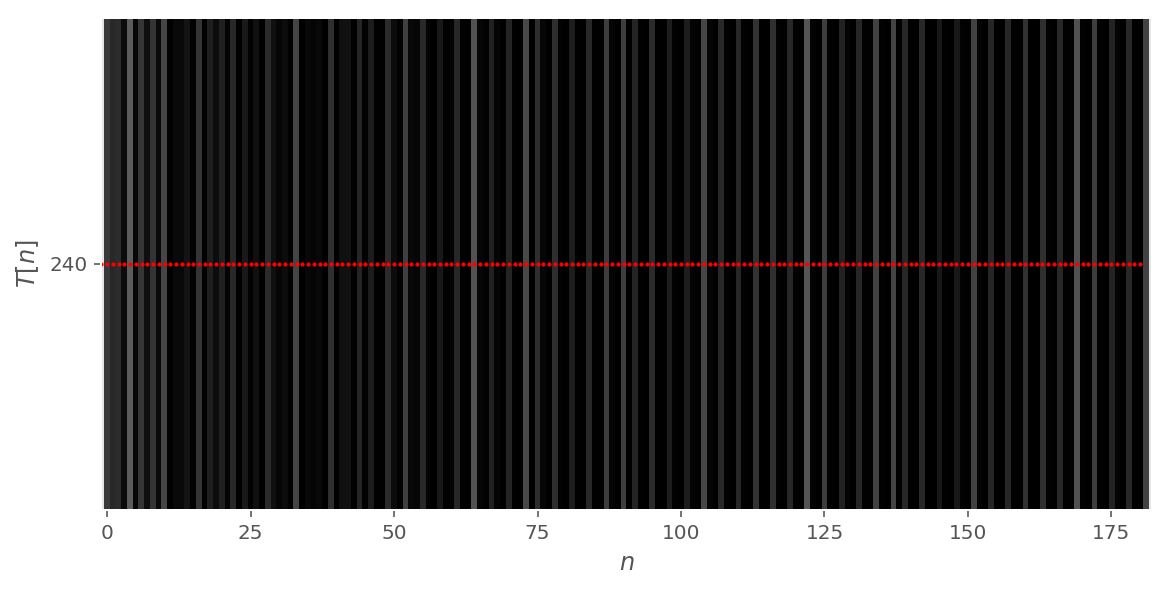

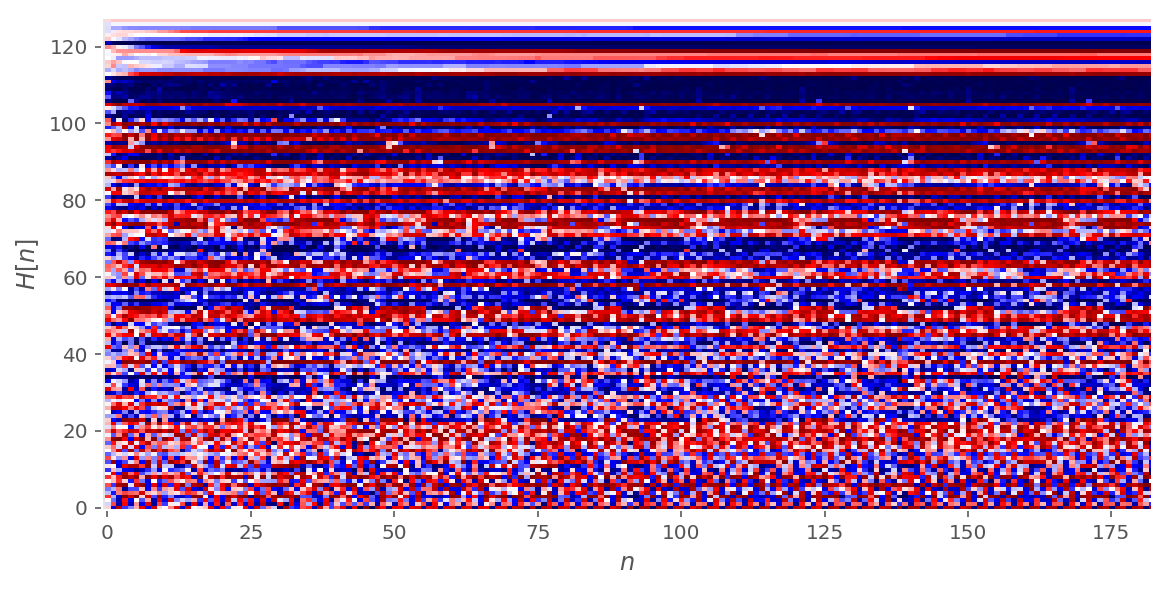

Music # 2 (GRU)


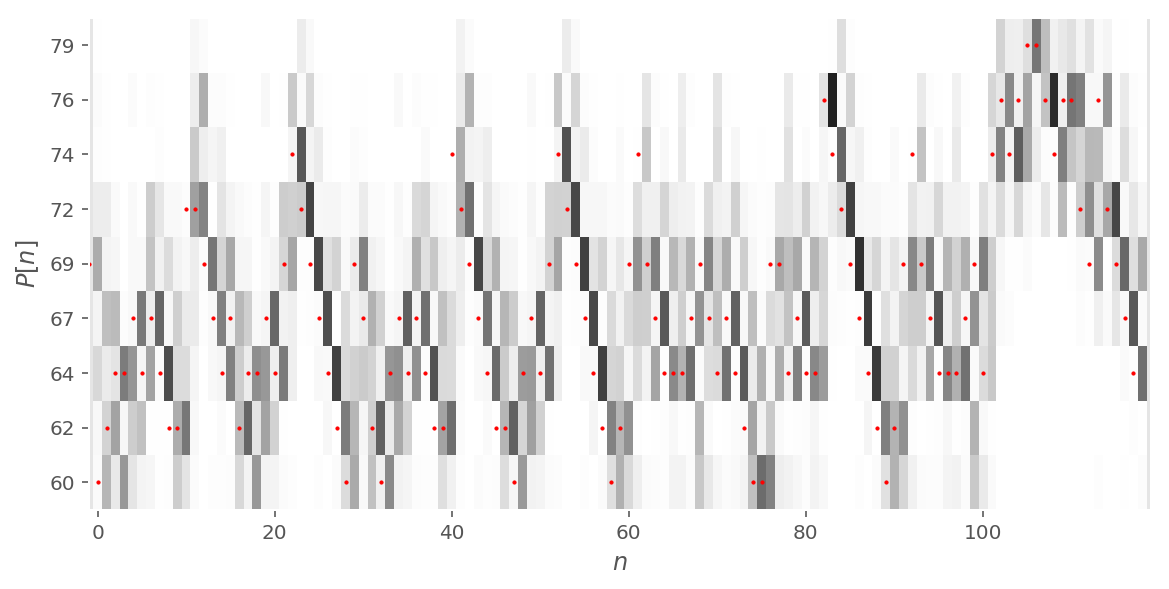

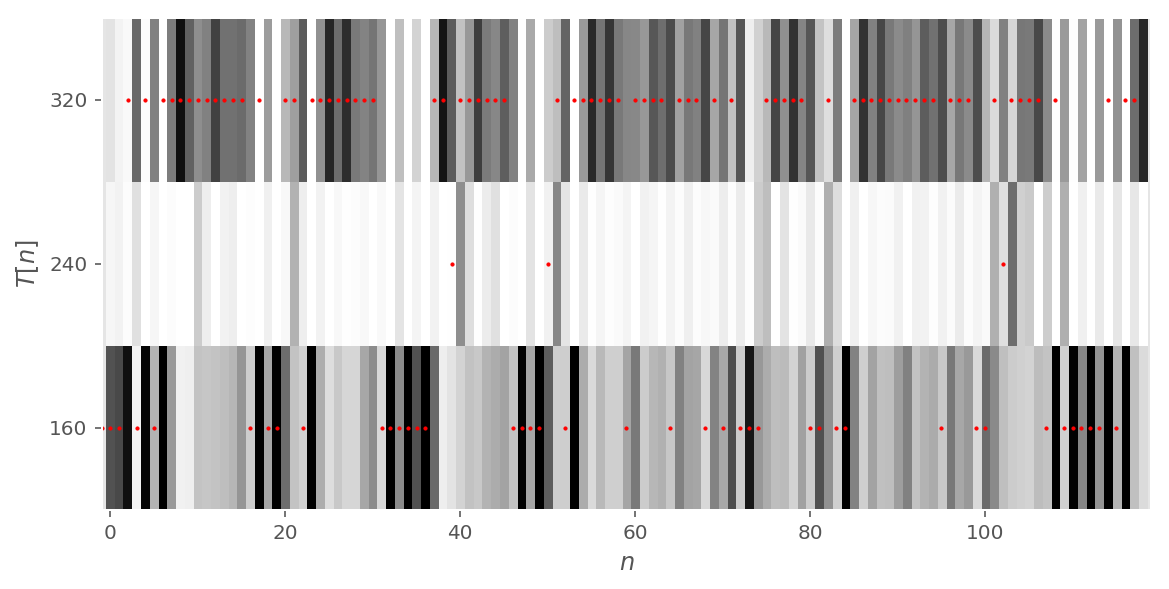

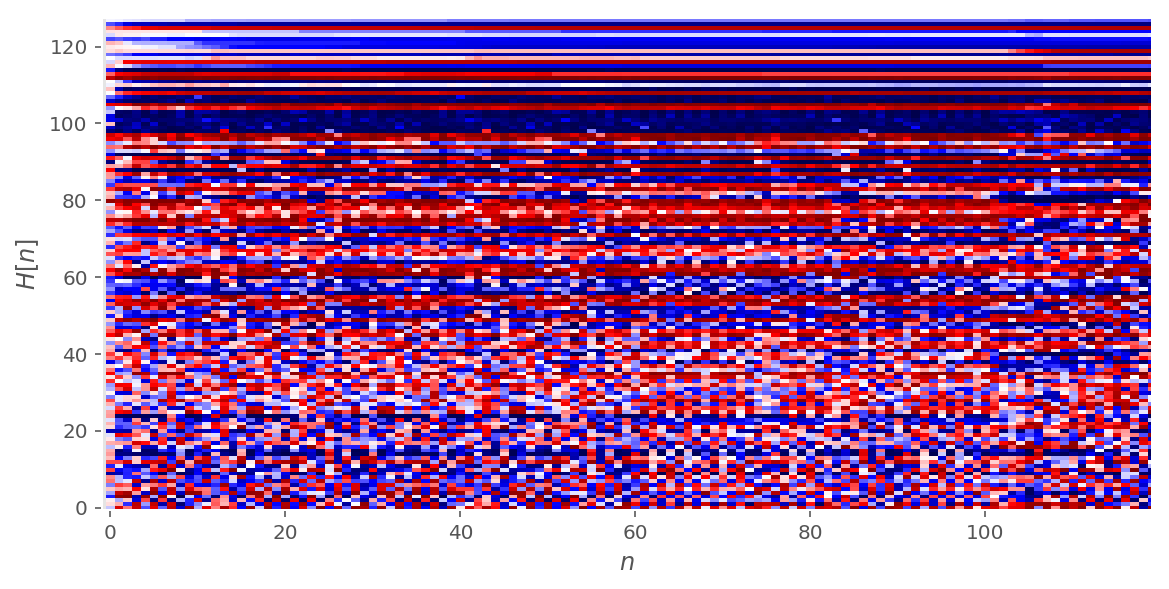

Music # 3 (GRU)


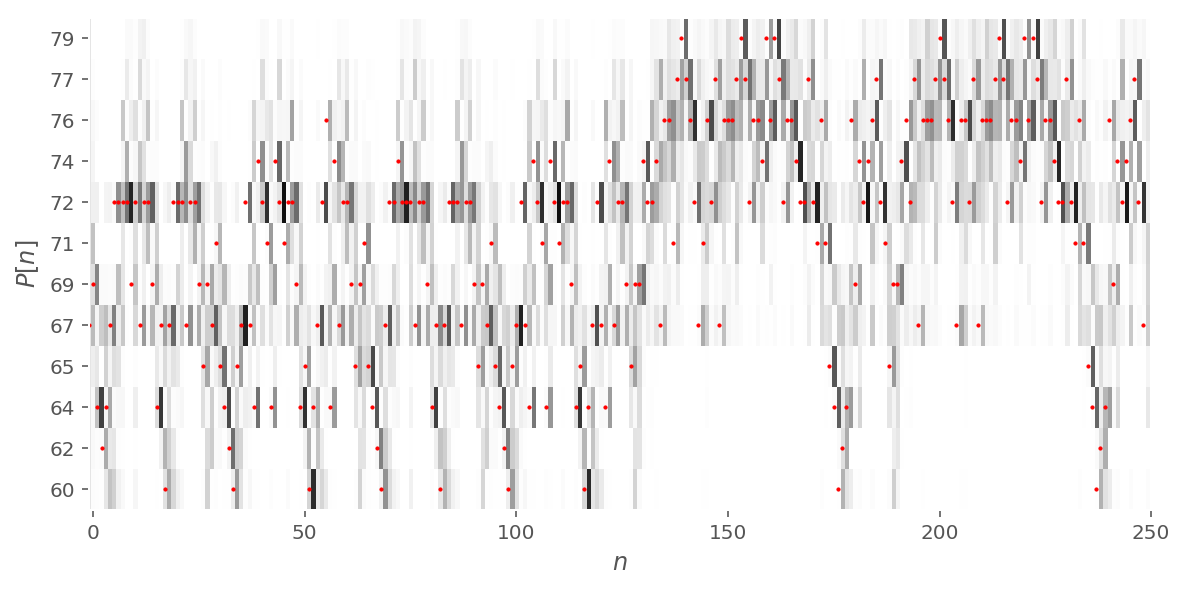

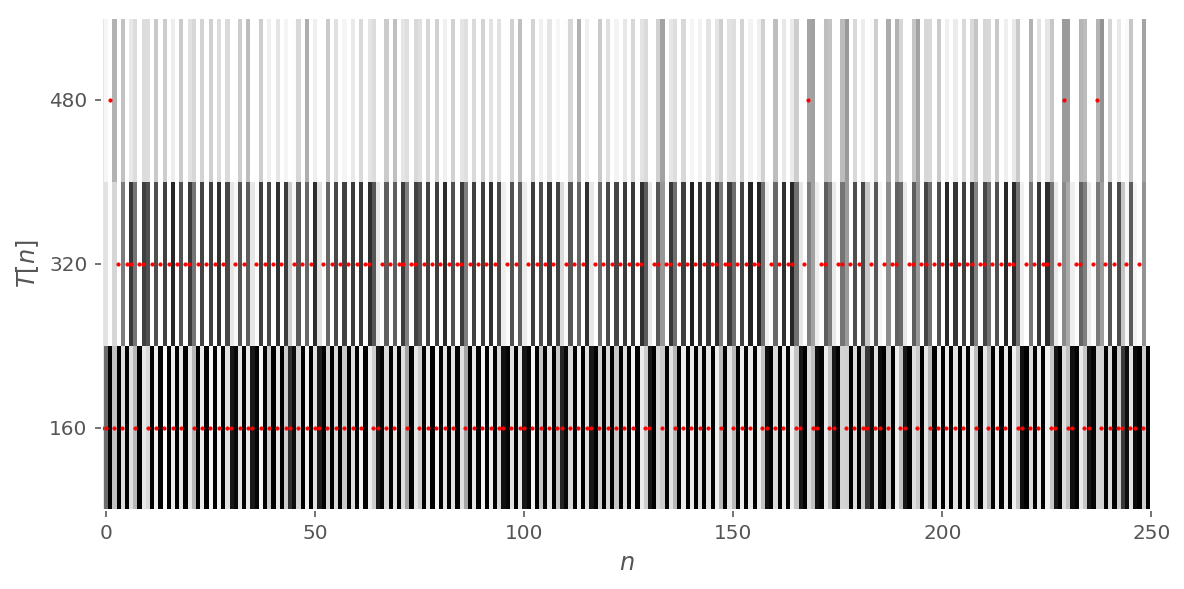

In [76]:
# Plotting the output of our model + the hidden states (with the new model predictions)

print("GRU : Plotting the output of our model and the hidden states...")
print('\n')

for music in range(4):
    print("Music #",music,"(GRU)")
    
    length,values = np.nonzero(shift_P[indexes][music])
    end = length[-1]
    plotMelody(P=output_PGRU[music][0:end], T=output_TGRU[music][0:end], dictionaries=dictionaries, PrP=predictionsGRU[1][music][0:end], PrT=predictionsGRU[0][music][0:end], H=predictionsHiddenGRU[music])


RNN : Plotting the output of our model and the hidden states...


Music # 0 (RNN)


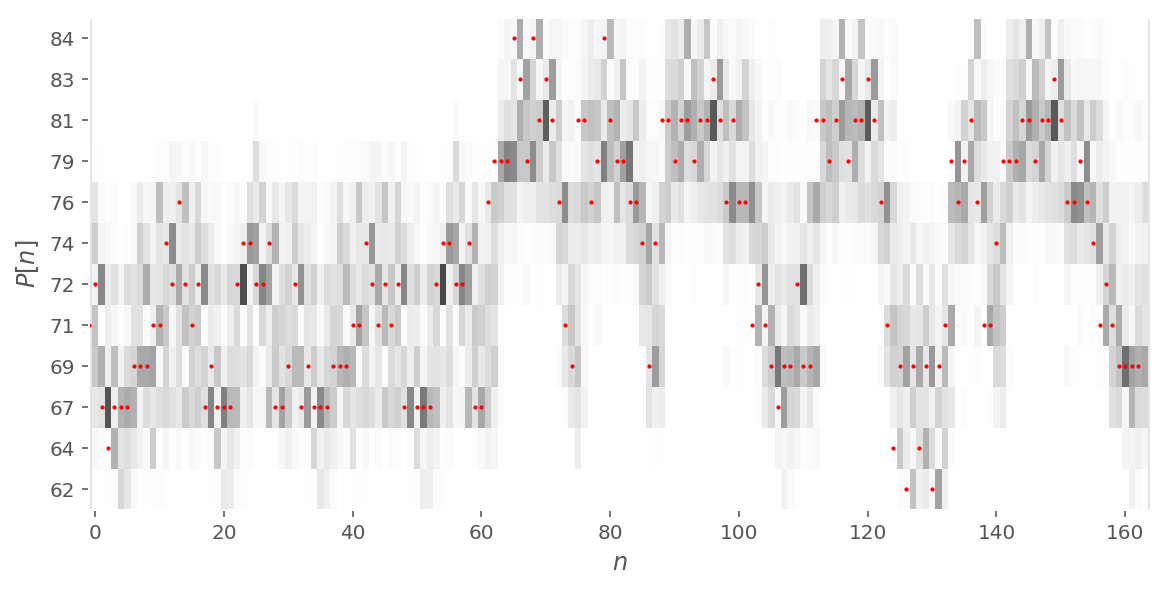

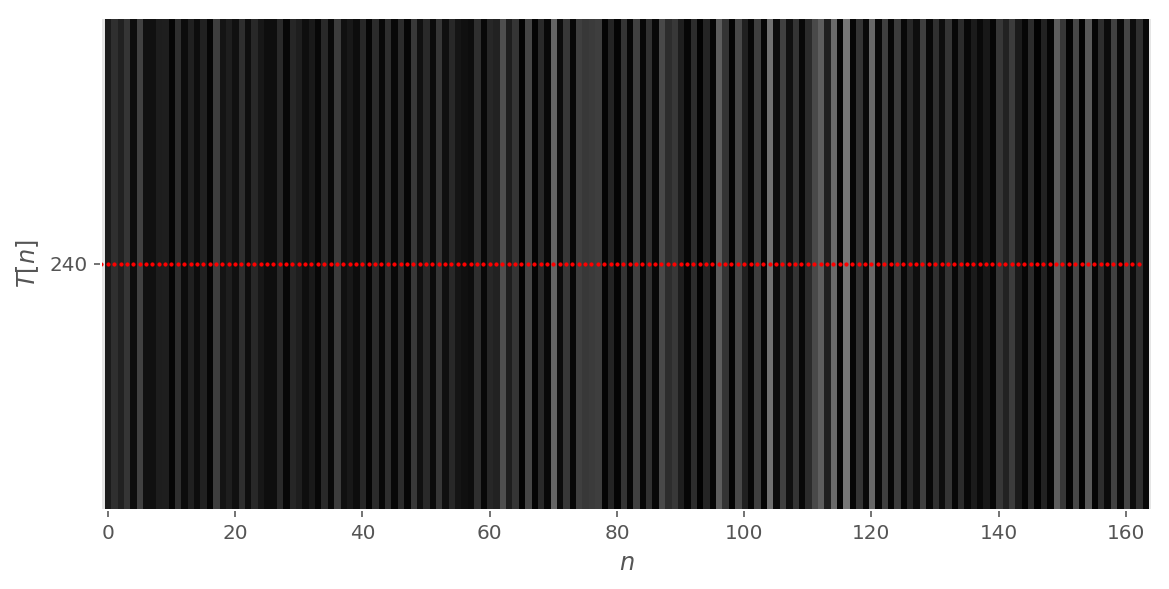

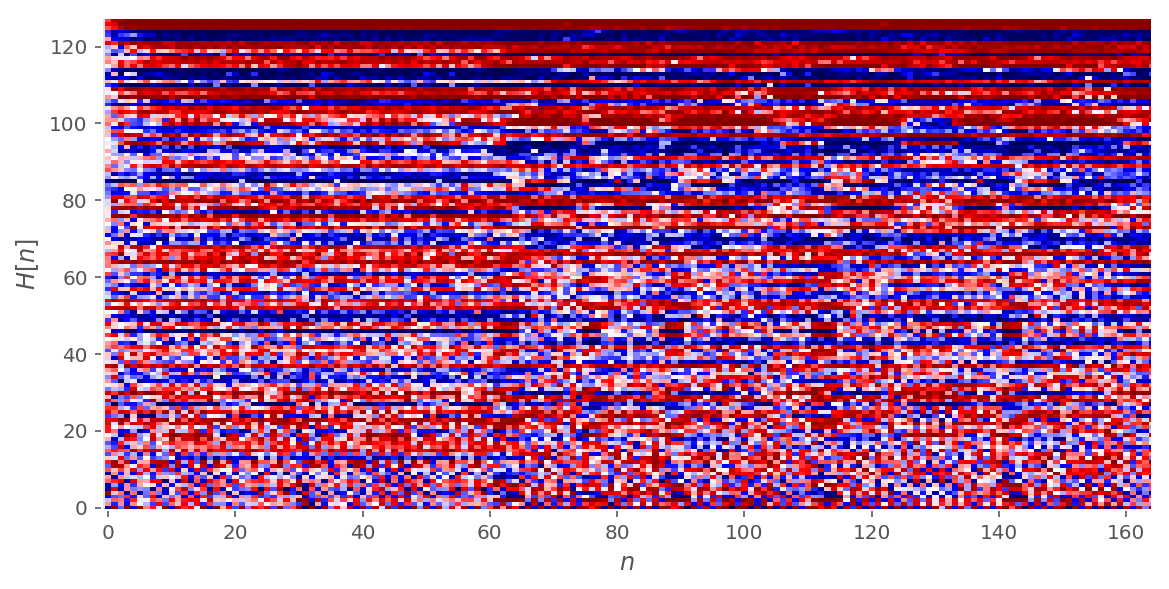

Music # 1 (RNN)


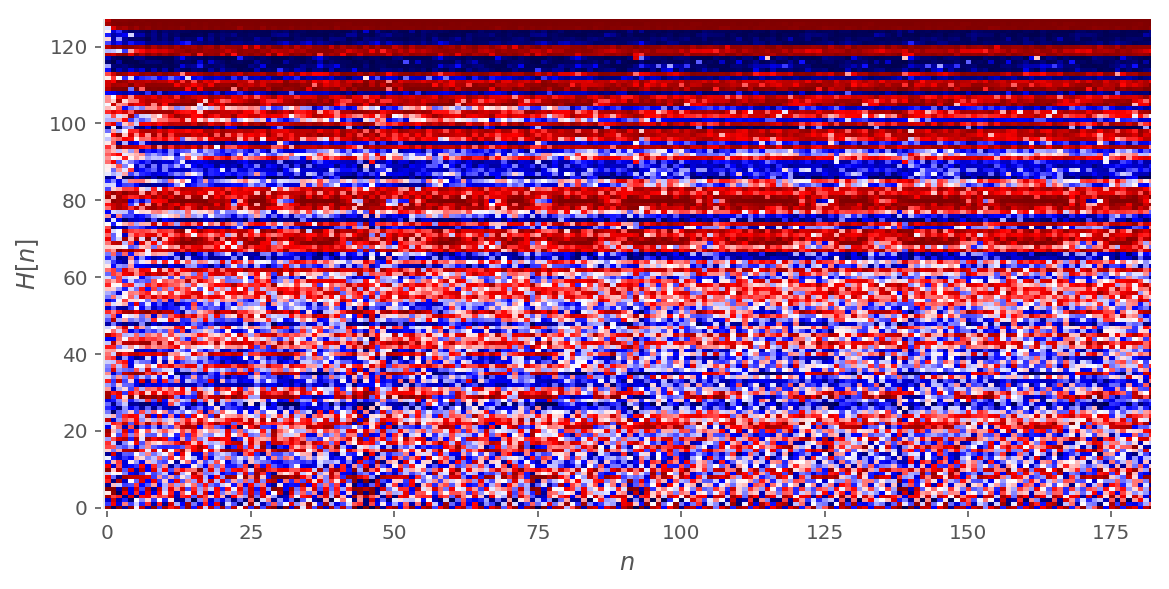

Music # 2 (RNN)


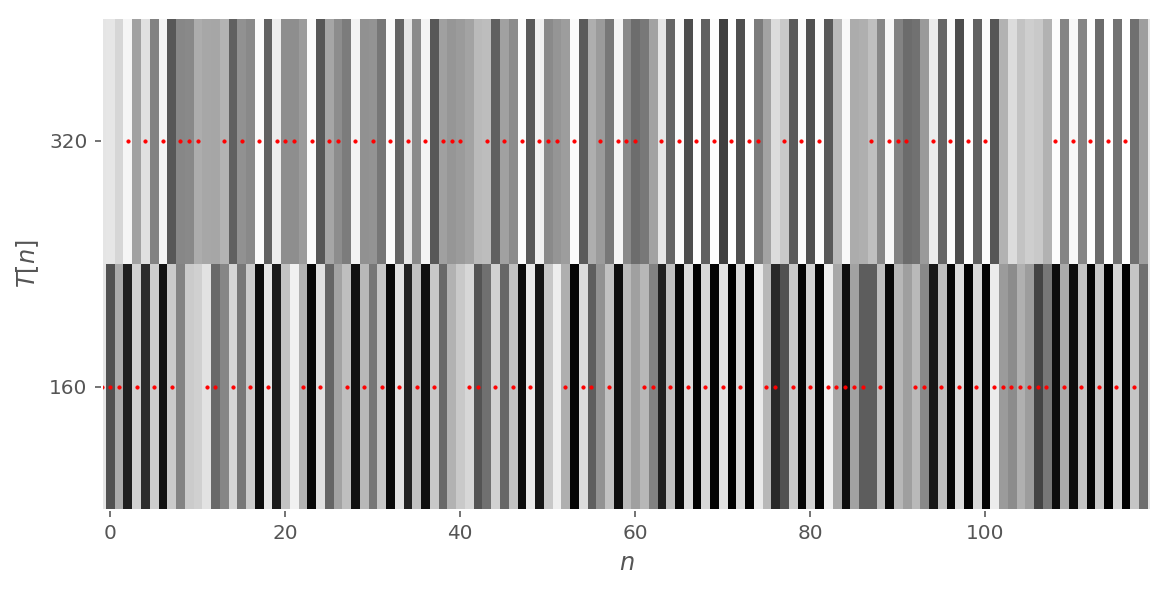

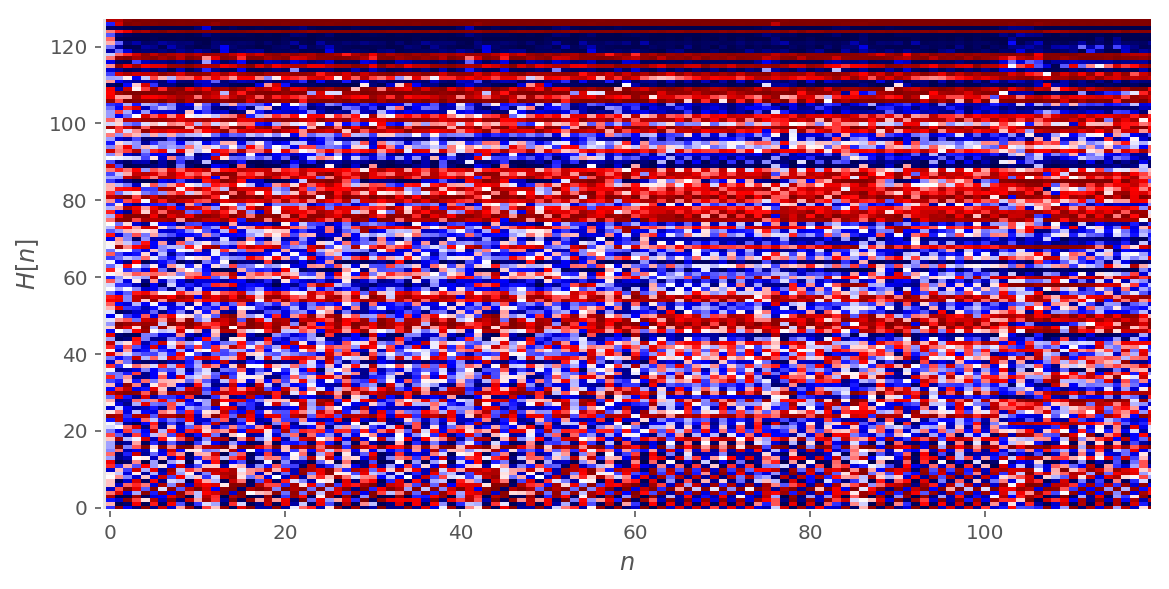

Music # 3 (RNN)


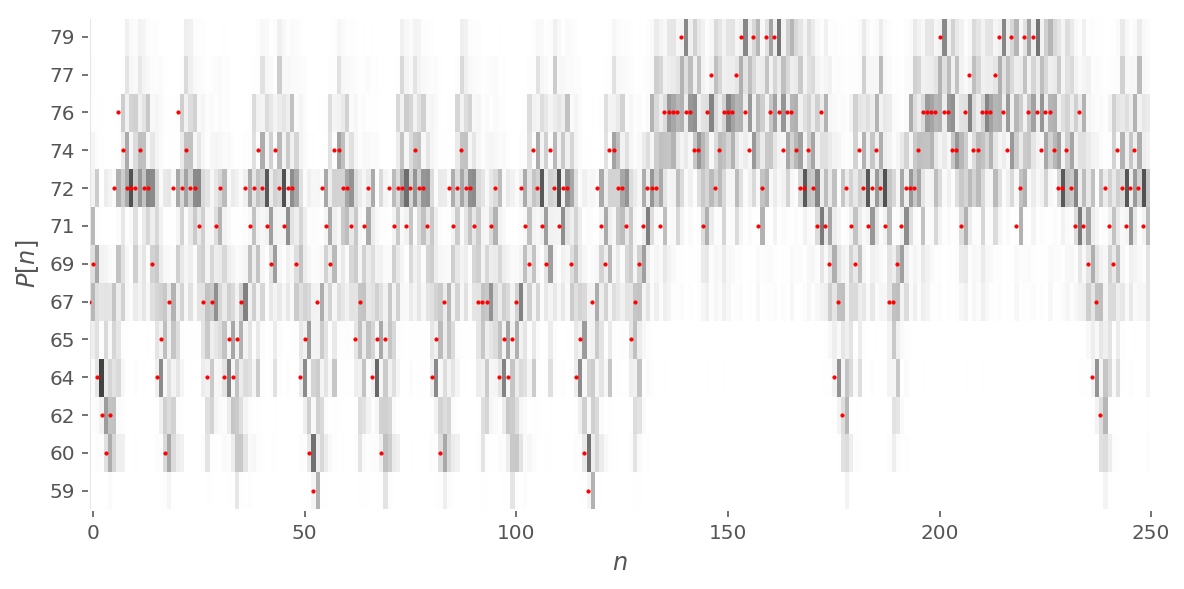

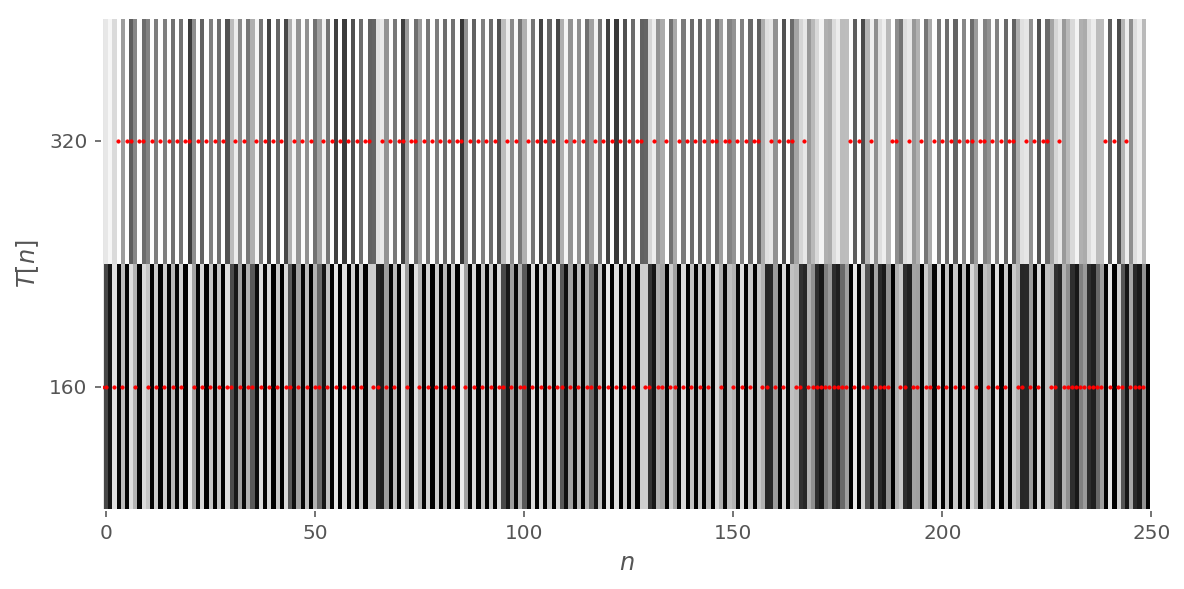

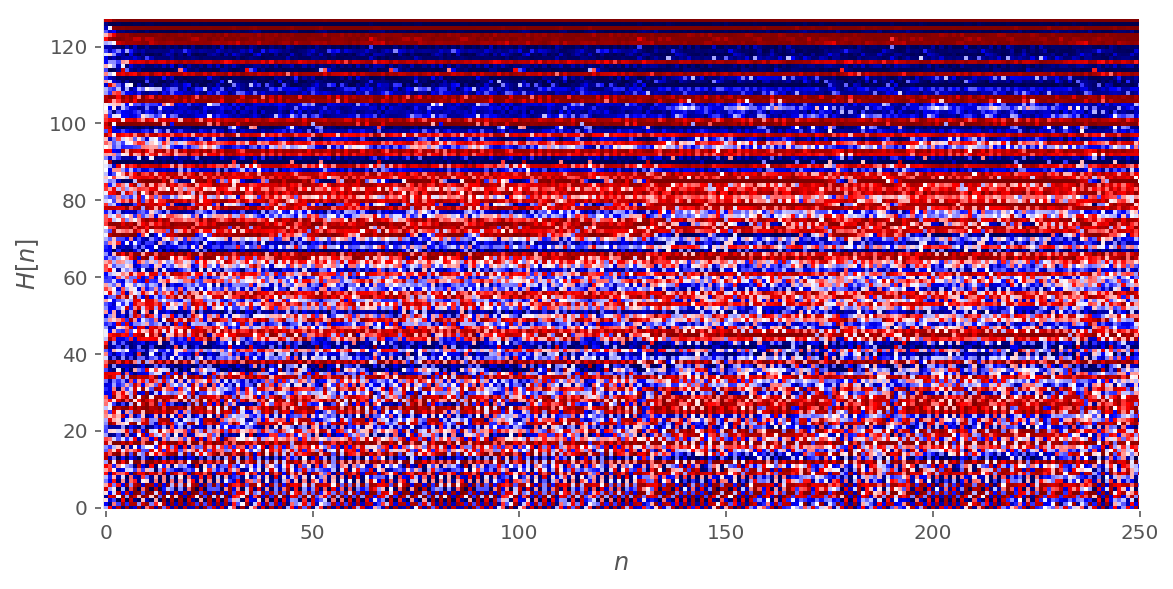

In [77]:
print("RNN : Plotting the output of our model and the hidden states...")
print('\n')

for music in range(4):
    print("Music #",music,"(RNN)")
    
    length,values = np.nonzero(shift_P[indexes][music])
    end = length[-1]
    plotMelody(P=output_PRNN[music][0:end], T=output_TRNN[music][0:end], dictionaries=dictionaries, PrP=predictionsRNN[1][music][0:end], PrT=predictionsRNN[0][music][0:end], H=predictionsHiddenRNN[music])    

**Question 6.3**

In [79]:
#Generate the prediction for all the melodies
print("Generate the prediction for all the melodies")
predictionsHiddenAllGRU = GRUmodelHidden.predict([categorical_T[:,0:-1],categorical_P[:,0:-1]], verbose=1)
predictionsHiddenAllRNN = RNNmodelHidden.predict([categorical_T[:,0:-1],categorical_P[:,0:-1]], verbose=1)

4350/4350 [==============================] - 22s 5ms/step


In [81]:
#compute the Average absolute change in activation
print("Computing the Average absolute change in activation")

def compute_diff(prediction):
    activation_diff = []
    
    for melody in range(0,len(categorical_P)):
        length,values = np.nonzero(shift_P[melody])
        end = length[-1]
        diff = []
        for note in range(0,(end-1)):        
            diff.append(np.absolute(prediction[melody][note,:]-prediction[melody][note+1,:]))  
        activation_diff.append(np.average(diff, axis = 0))
        
    final_average = np.average(activation_diff, axis = 0)
    return final_average

activation_differences_GRU = compute_diff(predictionsHiddenAllGRU)
activation_differences_RNN = compute_diff(predictionsHiddenAllRNN)

print("Done !")

Computing the Average absolute change in activation
Done !


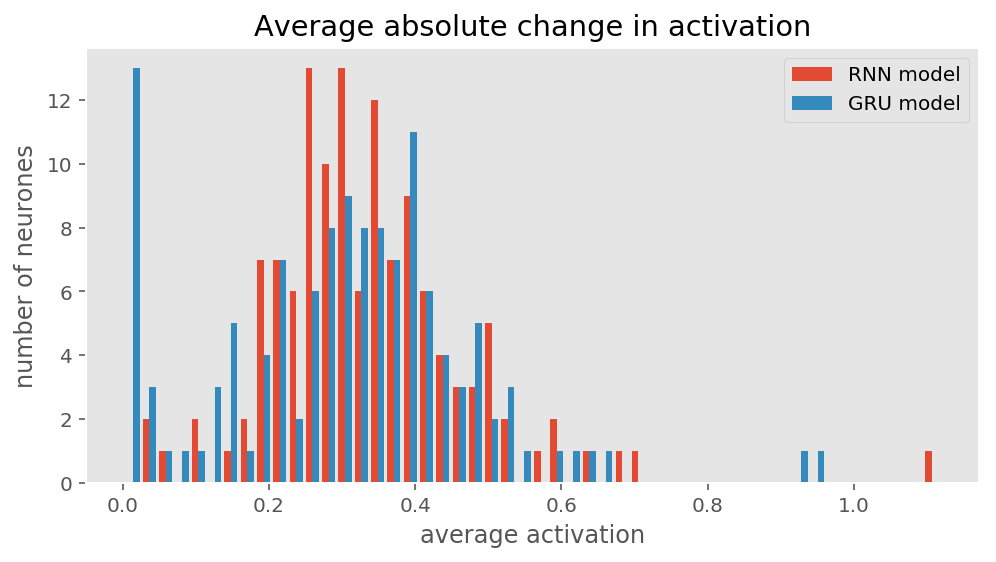

In [83]:
# Plot the results
plt.hist([activation_differences_RNN,activation_differences_GRU], bins= 50)
plt.title("Average absolute change in activation")
plt.xlabel("average activation")
plt.ylabel("number of neurones")
plt.legend(('RNN model', 'GRU model'))
plt.show()

**Question**: How does the hidden state dynamics explain the performance of the RNN vs GRU models? Explain in term of temporal dependencies and base your explanation on figures obtained in 6.2 and 6.3.
    
**Answer**: 


## Exercise 7: Generation of new melodies
### Description

1. Use your trained best model to generate new melodies. You can do that by starting with a random note, feeding it to your network and sample the output predictions in order to select the next note. Then add this note to your iteratively growing melodies. For your convenience, we provided the `sample` and `writeMIDI` functions. You can use the first in order to perform temperature sampling. The `writeMIDI` function allows you to write a MIDI file from the integer representation.
2. Try different sampling temperatures (e.g. 0.5, 1., 1.5) and observe the effect on your generated melodies.
3. Generate 32 melodies with both the RNN and GRU models
4. Listen to 4 randomly chosen melodies (2 from the GRU model and 2 from the RNN model). To play in a notebook, use a similar approach as the one shown below assuming you have the files `GRU_1.mid` and `RNN_1.mid` at the same level as this notebook. For your own curiosity, you can also directly listen to the MIDI files with your favorite MIDI player but make sure that we can listen to the 4 extracts directly from this notebook (without rerunning it). You might have to use the "Trust notebook" button (in the top right corner) to see the players. This currently only works in jupyter notebook (not jupyter lab). If you have trouble achieving that, upload the MIDI files with your submission.
5. (Optional) If you have a big enough computing power, try adding multiple and bigger layers. You could also try to improve your model with different add-ons, e.g. make your model learn when a melody ends, extend it to other datasets, ...
6. (Optional) If you are happy with your results submit a 1 hour long generated MIDI file to the [AI-generated music challenge](https://www.crowdai.org/challenges/ai-generated-music-challenge). 

### Solution

**Question 7.1**

In [109]:
# load the model

print("Loading the models...")
GRUmodelbis = load_model('save/GRUmodelWithoutObig.h5')
RNNmodelbis = load_model('save/RNNmodelWithoutObig.h5')
print("Done !")

Loading the models...
Done !


In [110]:
# Function that create a music by randomly choosing a first note and then using our model to iteratively predicting the
# next note.
# Input :
# -the GRU or RNN model
# -the desired length of the music to generate
# -the temperature for sampling the probability distribution (model output)
# Returns :
# -the integer representation of the generated melody.

def createMusic(model,desired_length=390,nbDegree=1.,):
    
    # creating a random first note
    
    index_T = randint(0, len(dictionaries['T'])-1)
    index_P = randint(0, len(dictionaries['P'])-1)
    first_T = dictionaries['T'][index_T]
    first_P = dictionaries['P'][index_P]
    #print("The first note will be of pitch",first_P,"and of duration",first_T)
    
    # initialization (first note added to an empty melody)

    cat_T = categorical_T[0:1,0:-1,:]
    cat_P = categorical_P[0:1,0:-1,:]

    for i in range(cat_T.shape[1]):
        for j in range(cat_T.shape[2]):
            cat_T[0,i,j] = 0

    for i in range(cat_P.shape[1]):
        for j in range(cat_P.shape[2]):
            cat_P[0,i,j] = 0

    cat_T[0,0,index_T] = 1
    cat_P[0,0,index_P] = 1
    
    # predicting the next notes
    
    #print("Predicting the rest of the melody...")
    T = 0
    P = 1
    music = 0

    for note in range(desired_length-1):
        mymusic = model.predict([cat_T, cat_P])

        nextT_idx = sample(mymusic[T][music][note], temperature=nbDegree)
        nextP_idx = sample(mymusic[P][music][note], temperature=nbDegree)

        cat_T[0,note+1,nextT_idx] = 1
        cat_P[0,note+1,nextP_idx] = 1
    
    # conversion to integer representation 
    
    int_T = np.zeros((desired_length,),dtype='int')
    int_P = np.zeros((desired_length,),dtype='int')

    for note in range(desired_length-1):
        at_T = np.nonzero(cat_T[0,note])[0]
        if(at_T.size != 0):
            int_T[note] = (int)(at_T)
        at_P = np.nonzero(cat_P[0,note])[0]
        if(at_P.size != 0):
            int_P[note] = (int)(at_P)
    
    return int_P, int_T

GRU, temperature of 1.0


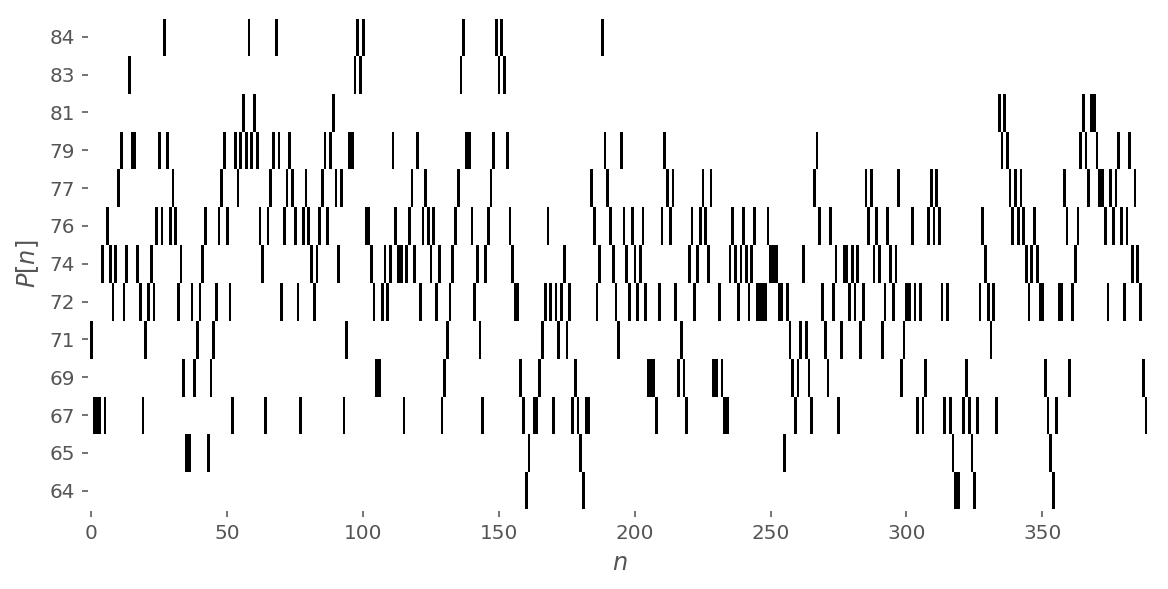

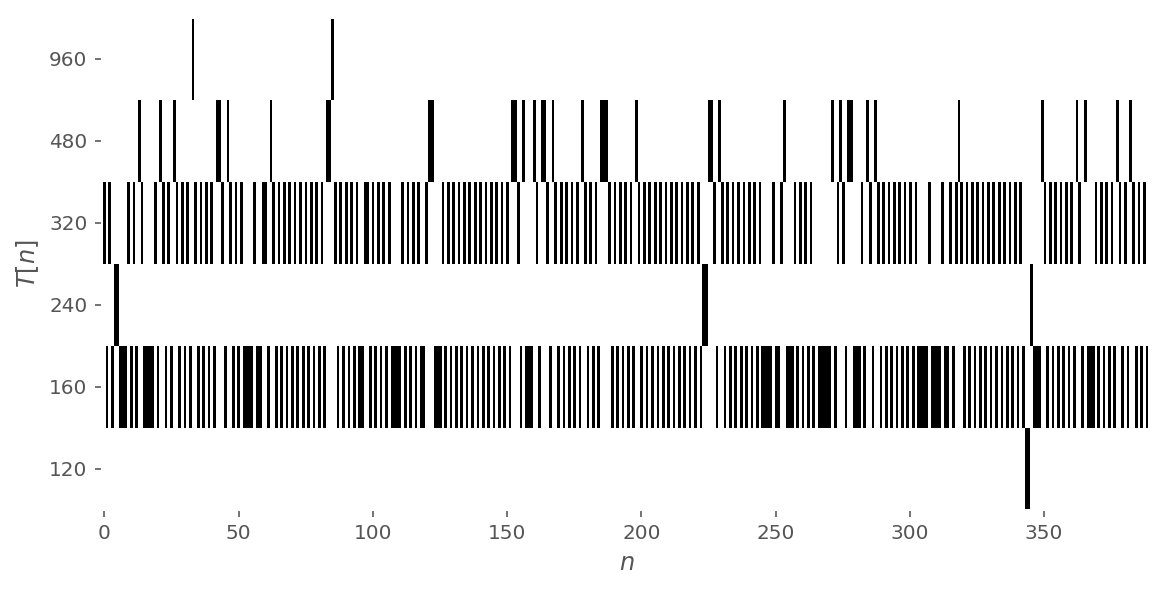

In [111]:
print('GRU, temperature of 1.0')
pitchosGRU, durosGRU = createMusic(model=GRUmodelbis,desired_length=390,nbDegree=1.)
plotMelody(pitchosGRU,durosGRU,dictionaries)
writeMIDI(pitchosGRU, durosGRU, dictionaries, "generated_music/GRUtest.mid")
# The music bar does not work appearently, but we uploaded the .midi files in the submission
music21.midi.translate.midiFilePathToStream("generated_music/GRUtest.mid").show('midi')

In [112]:
print('RNN, temperature of 1.0')
pitchosRNN, durosRNN = createMusic(model=RNNmodelbis,desired_length=390,nbDegree=1.)
plotMelody(pitchosRNN,durosRNN,dictionaries)
writeMIDI(pitchosRNN, durosRNN, dictionaries, "generated_music/RNNtest.mid")
# The music bar does not work appearently, but we uploaded the .midi files in the submission
music21.midi.translate.midiFilePathToStream("generated_music/RNNtest.mid").show('midi')

RNN, temperature of 1.0


**Question 7.2**

Testing different temperatures with GRU...
Temperature of 0.5 (GRU)


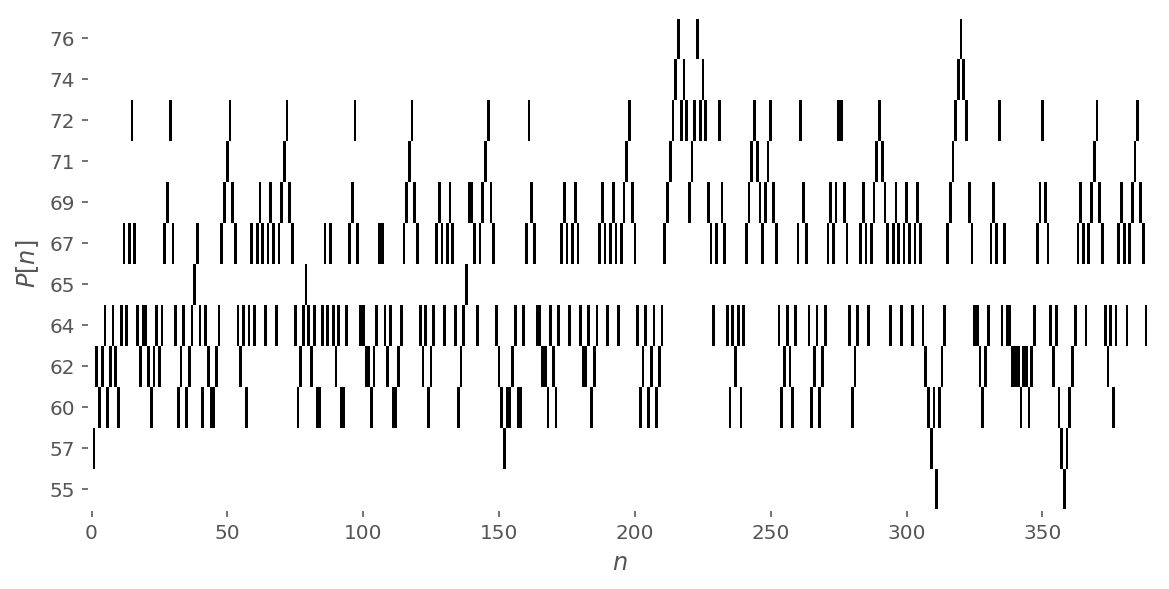

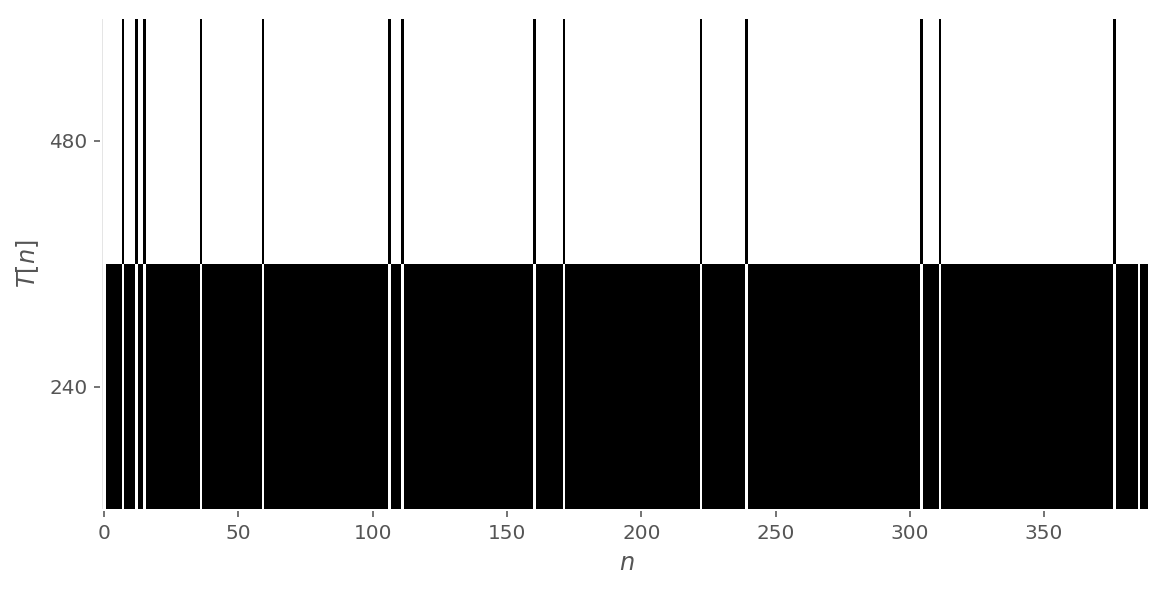

Temperature of 1.0 (GRU)


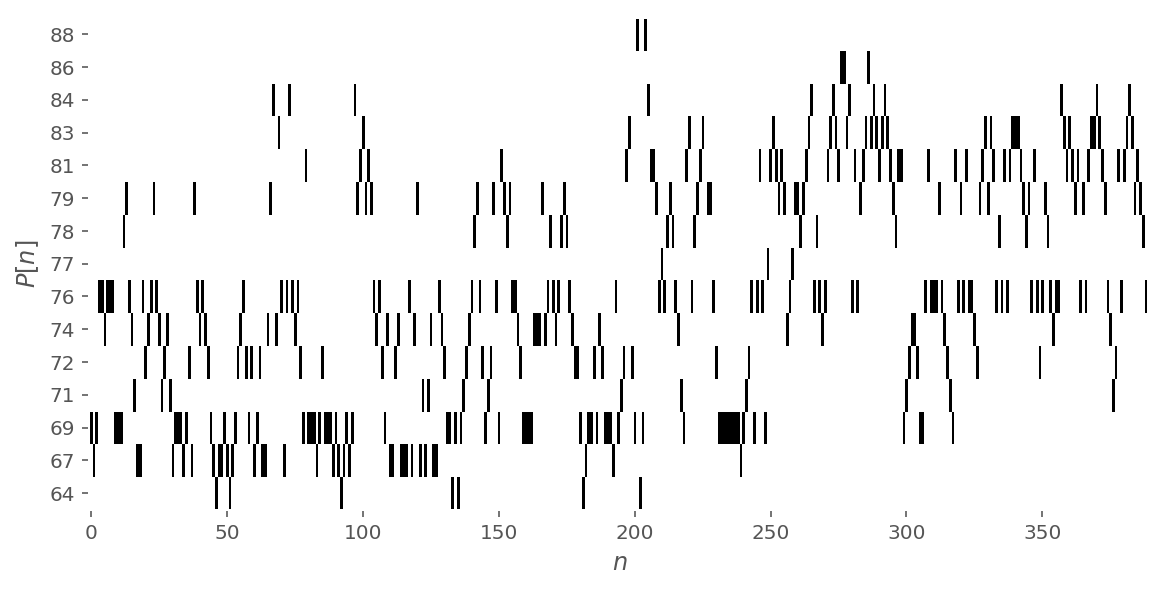

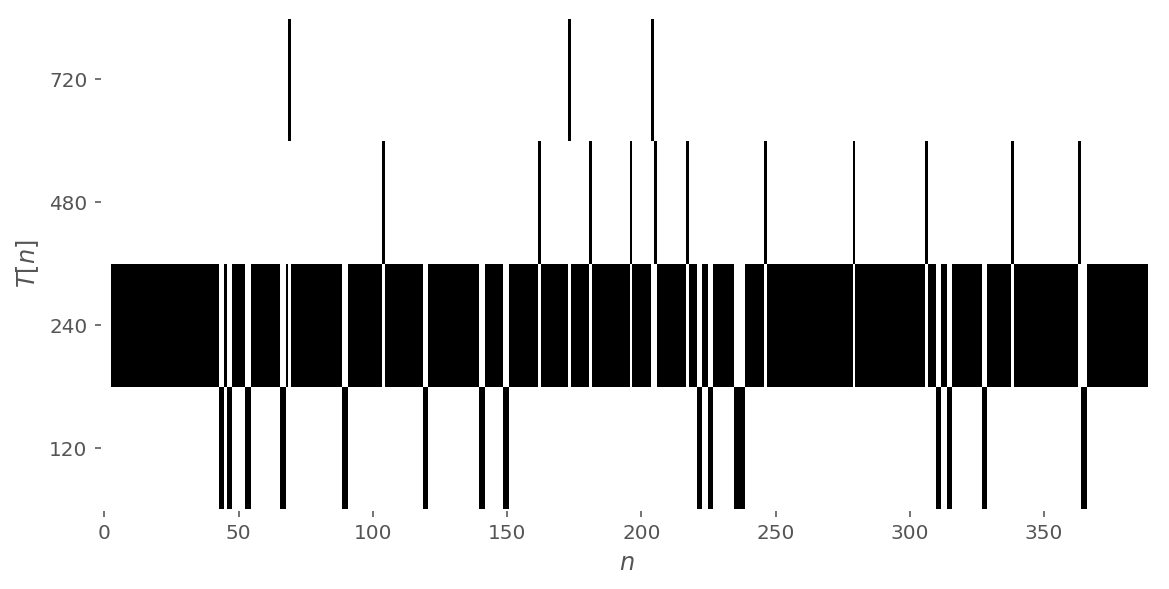

Temperature of 1.5 (GRU)


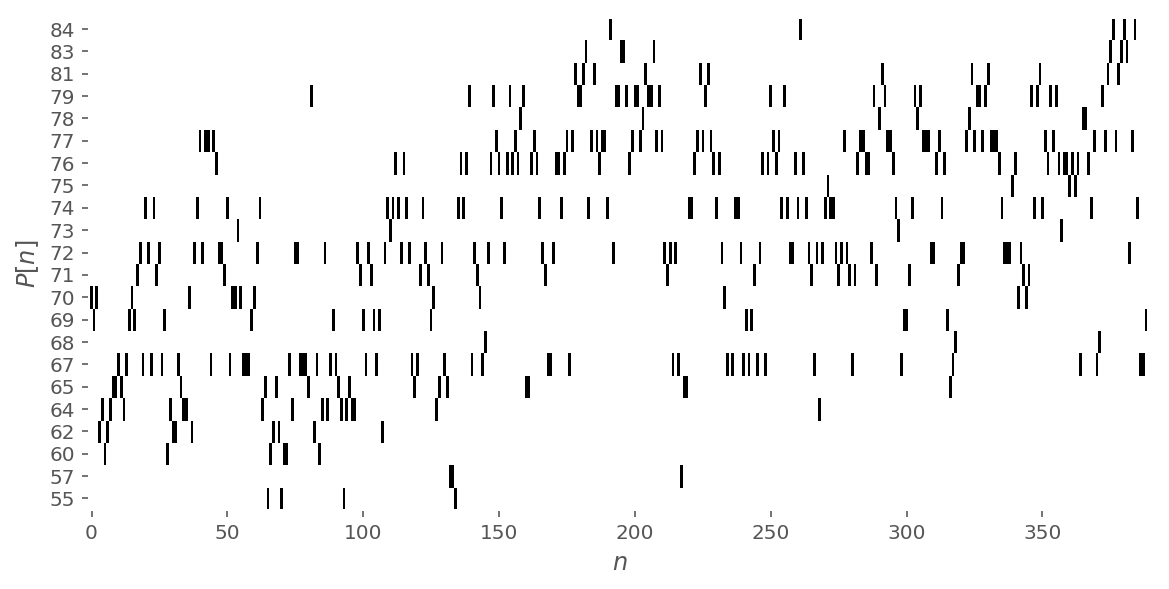

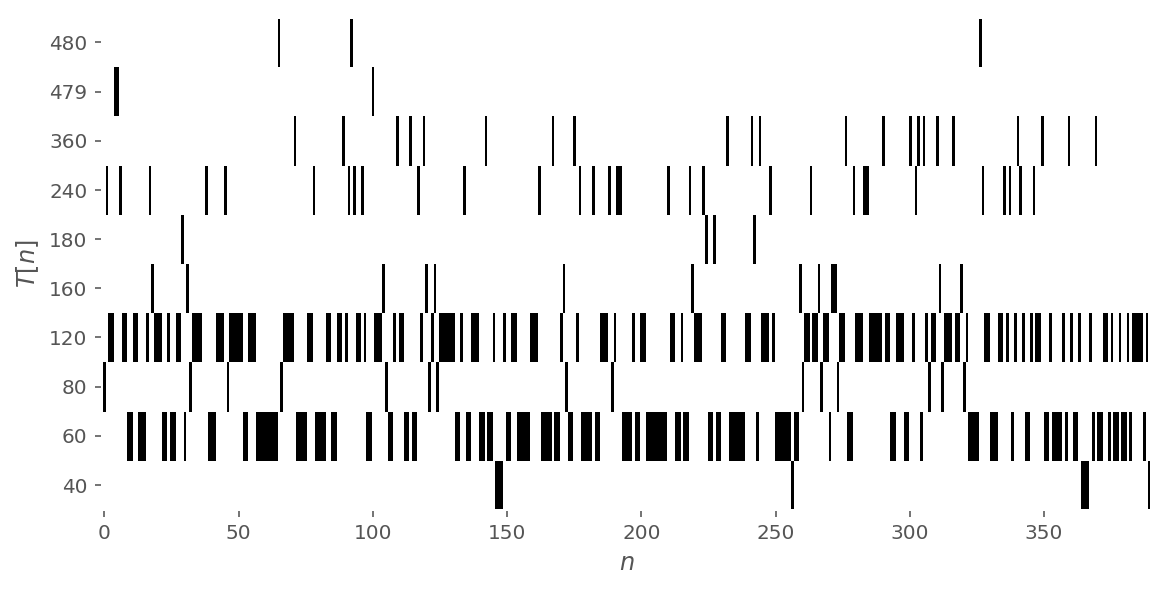

Testing different temperatures with RNN...
Temperature of 0.5 (RNN)


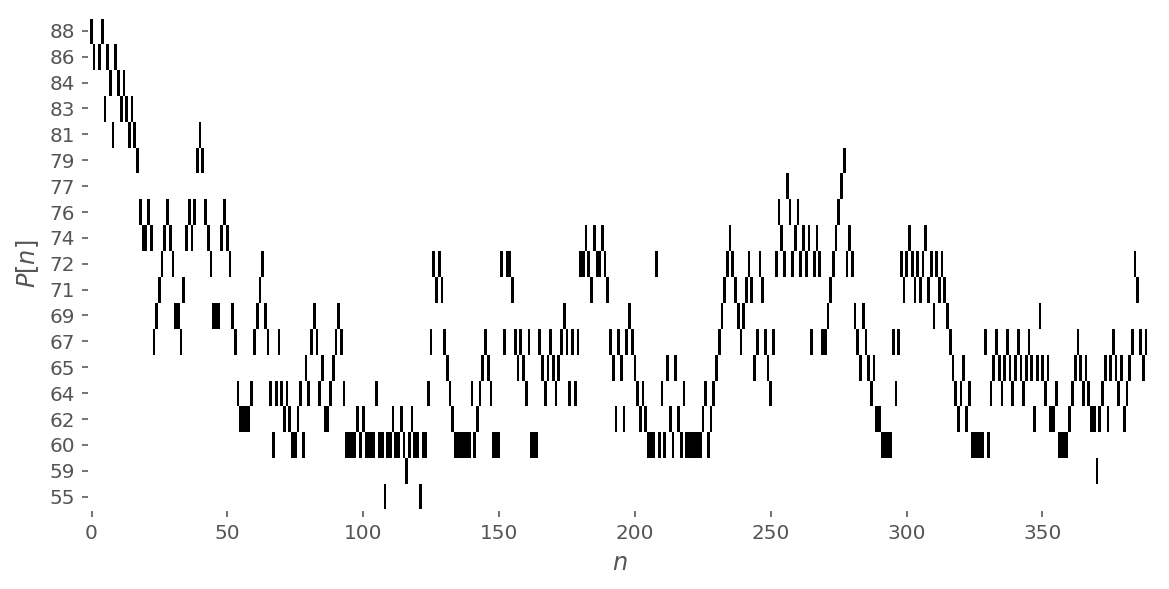

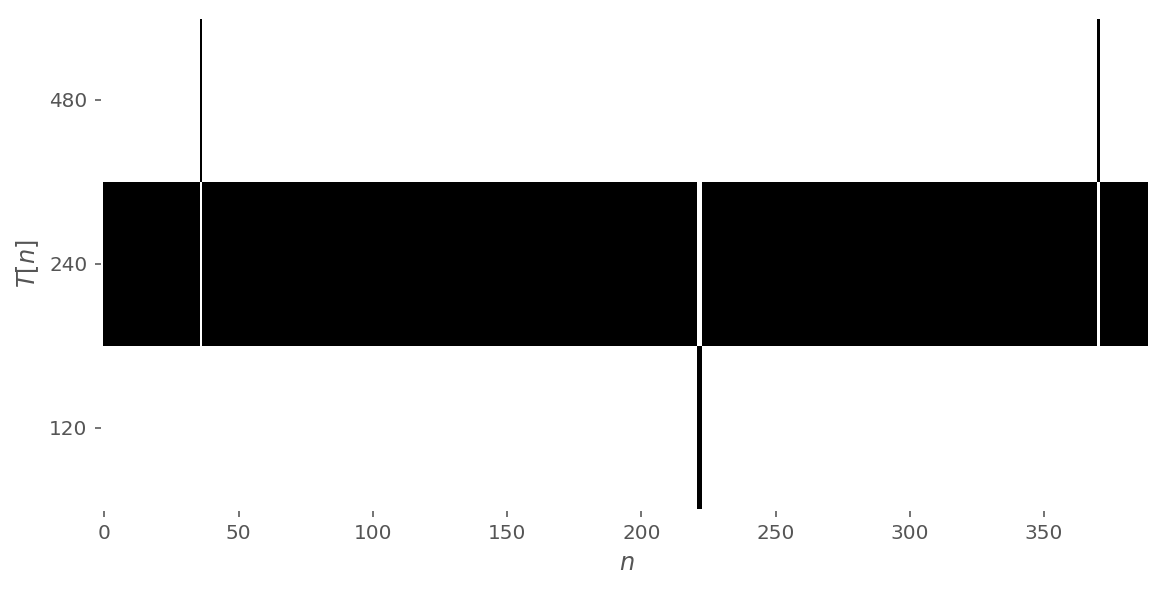

Temperature of 1.0 (RNN)


Temperature of 1.5 (RNN)


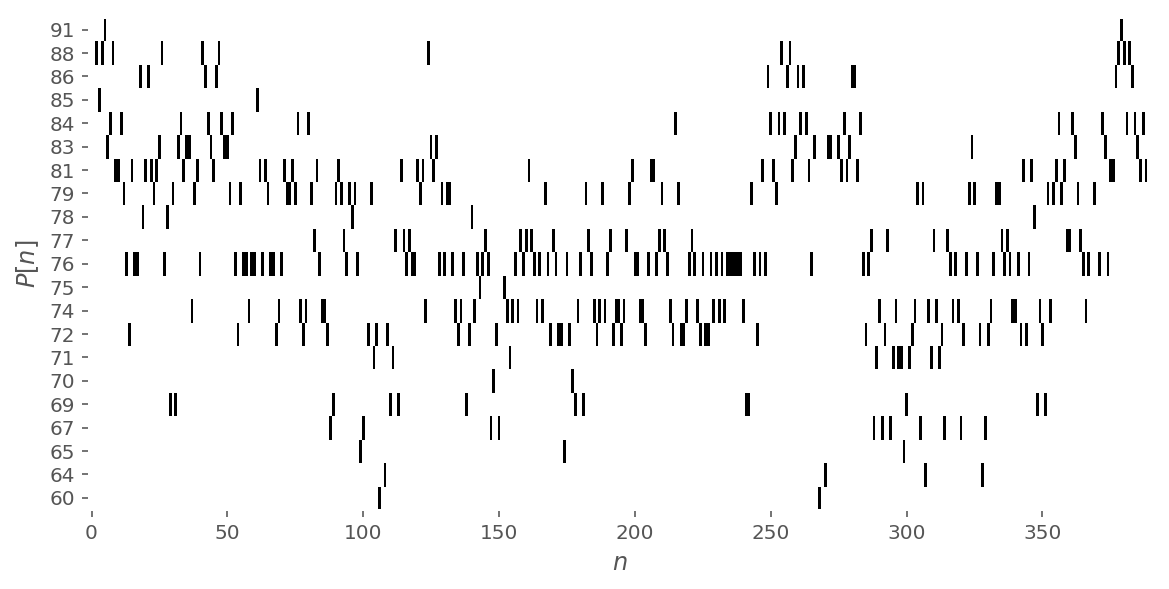

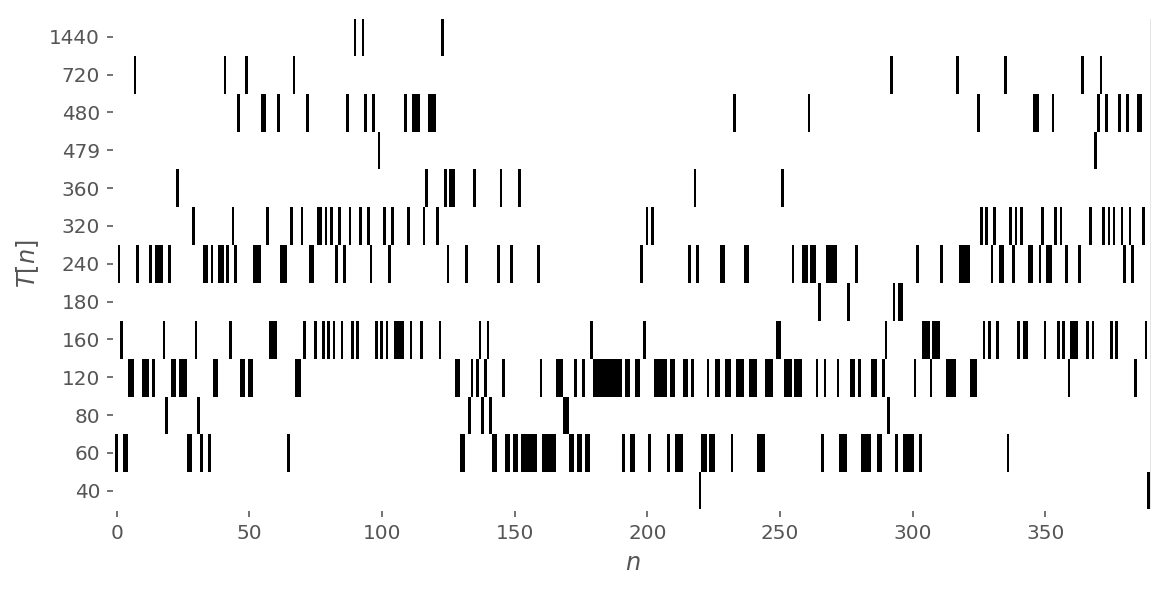

In [115]:
print('Testing different temperatures with GRU...')

temperatures = [0.5,1.0,1.5]
for temp in temperatures:
    print("Temperature of",temp,"(GRU)")
    integ_P, integ_T = createMusic(model=GRUmodelbis,desired_length=390,nbDegree=temp)
    writeMIDI(integ_P, integ_T, dictionaries, "generated_music/GRU_temp"+str(temp)+".mid")
    plotMelody(integ_P,integ_T,dictionaries)
    music21.midi.translate.midiFilePathToStream("generated_music/GRU_temp"+str(temp)+".mid").show('midi')
    
print('Testing different temperatures with RNN...')

temperatures = [0.5,1.0,1.5]
for temp in temperatures:
    print("Temperature of",temp,"(RNN)")
    integ_P, integ_T = createMusic(model=RNNmodelbis,desired_length=390,nbDegree=temp)
    writeMIDI(integ_P, integ_T, dictionaries, "generated_music/RNN_temp"+str(temp)+".mid")
    plotMelody(integ_P,integ_T,dictionaries)
    music21.midi.translate.midiFilePathToStream("generated_music/RNN_temp"+str(temp)+".mid").show('midi')
    

**Question 7.3**

In [119]:
print("Generating 64 melodies (32 with RNN, 32 with GRU)...")

for melody in range(32):
    print("Generating RNN melody #",melody+1)
    integ_P, integ_T = createMusic(model=RNNmodelbis,desired_length=390,nbDegree=1.)
    writeMIDI(integ_P, integ_T, dictionaries, "generated_music/RNN"+str(melody+1)+".mid")
    print("Generating GRU melody #",melody+1)
    integ_P, integ_T = createMusic(model=GRUmodelbis,desired_length=390,nbDegree=1.)
    writeMIDI(integ_P, integ_T, dictionaries, "generated_music/GRU"+str(melody+1)+".mid")

Generating 64 melodies (32 with RNN, 32 with GRU)...
Generating RNN melody # 1
Generating GRU melody # 1
Generating RNN melody # 2
Generating GRU melody # 2
Generating RNN melody # 3
Generating GRU melody # 3
Generating RNN melody # 4
Generating GRU melody # 4
Generating RNN melody # 5
Generating GRU melody # 5
Generating RNN melody # 6
Generating GRU melody # 6
Generating RNN melody # 7
Generating GRU melody # 7
Generating RNN melody # 8
Generating GRU melody # 8
Generating RNN melody # 9
Generating GRU melody # 9
Generating RNN melody # 10
Generating GRU melody # 10
Generating RNN melody # 11
Generating GRU melody # 11
Generating RNN melody # 12
Generating GRU melody # 12
Generating RNN melody # 13
Generating GRU melody # 13
Generating RNN melody # 14
Generating GRU melody # 14
Generating RNN melody # 15
Generating GRU melody # 15
Generating RNN melody # 16
Generating GRU melody # 16
Generating RNN melody # 17
Generating GRU melody # 17
Generating RNN melody # 18
Generating GRU melod

**Question 7.4**

In [161]:
indexesGRU = np.random.choice(32,2,replace=False)+1
indexesRNN = np.random.choice(32,2,replace=False)+1
    
print("The randomly chosen musics for GRU are :", indexesGRU)
print("With GRU, music #",indexesGRU[0])
music21.midi.translate.midiFilePathToStream("generated_music/GRU"+str(indexesGRU[0])+".mid").show('midi')
print("With GRU, music #",indexesGRU[1])
music21.midi.translate.midiFilePathToStream("generated_music/GRU"+str(indexesGRU[1])+".mid").show('midi')

print("The randomly chosen musics for RNN are :", indexesRNN)
print("With RNN, music #",indexesRNN[0])
music21.midi.translate.midiFilePathToStream("generated_music/RNN"+str(indexesRNN[0])+".mid").show('midi')
print("With RNN, music #",indexesRNN[1])
music21.midi.translate.midiFilePathToStream("generated_music/RNN"+str(indexesRNN[1])+".mid").show('midi')

The randomly chosen musics for GRU are : [11 14]
With GRU, music # 11


With GRU, music # 14


The randomly chosen musics for RNN are : [4 5]
With RNN, music # 4


With RNN, music # 5


**Question**: What is the effect of the sampling temperature on the generated melodies?
    
**Answer**: When we decrease temperature, the probability of the most probable pitches/durations are increased and the probabilities of less probable ones are decreased : for a given first note, the predicted melodies will more probably ressemble each other. For instance, with a temperature of 0.5, the duration of the notes is almost always the same.
Conversely, the higher the temperature, the more diverse results it gives.

**Question**: Are the generated melodies from the RNN model different from the one generated by the GRU model? If yes, what are the main differences?

**Answer**: The GRU model seems to be more "stable" : it predicts pitches and durations that are more similar to the previous ones than the RNN model.

